# Imports

In [1]:
cd /home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/

/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving


In [1]:
%load_ext autoreload
%autoreload 2

import sys 
import glob
import ray
import logging 
import gc
import cv2
import time
import itertools
import pickle
import pathlib 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import xarray as xr
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.signal import medfilt
from pathlib import Path
from scipy.optimize import minimize_scalar
from scipy.stats import binned_statistic


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from kornia.geometry.transform import Affine
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append(str(Path('.').absolute()))
from utils import *
import io_dict_to_hdf5 as ioh5
from format_data import *
from models import *
from fit_GLM import *
# pd.set_option('display.max_rows', None)

ray.init(
    ignore_reinit_error=True,
    logging_level=logging.ERROR,
)


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


{'node_ip_address': '184.171.84.86',
 'raylet_ip_address': '184.171.84.86',
 'redis_address': '184.171.84.86:25978',
 'object_store_address': '/tmp/ray/session_2021-12-18_16-13-19_479528_465899/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-12-18_16-13-19_479528_465899/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-12-18_16-13-19_479528_465899',
 'metrics_export_port': 64914,
 'node_id': '5b8539c69c896138661dbe478440c1a49c1888bd4240cb33fae160a4'}

tsp python fit_GLM.py --date_ani='070921/J553RT' --ModRun=0,1,2,3,4 --Nepochs=10000 
tsp python fit_GLM.py --date_ani='110421/J569LT' --ModRun=0,1,2,3,4 --Nepochs=10000 
tsp python fit_GLM.py --date_ani='102821/J570LT' --ModRun=0,1,2,3,4 --Nepochs=10000 
tsp python fit_GLM.py --date_ani='101521/J559NC' --ModRun=0,1,2,3,4 --Nepochs=10000 


In [3]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani'] = dates_all[0]
# args['date_ani'] = '070921/J553RT' 
# args['date_ani'] = '101521/J559NC'   
# args['date_ani'] = '102621/J558NC'
# args['date_ani'] = '110421/J569LT'
# yaml_path = sorted(list((Path(args['save_dir']).expanduser() / date_ani / stim_type / 'GLM_Network_NL/').rglob('*.yaml')))
# args['shiftn']=7
args['train_shifter']=False
args['NoL1'] = False
args['Nepochs'] = 10000
params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)


if args['NoL1'] == True: 
    L1 = 'NoL1'
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
else: 
    L1 = 'withL1'
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
ModelList = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))
model_info = params['date_ani2']+'_'+mod_name.replace('*', '')

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)

# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])

params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}'.format(params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter']))


Done Loading Unaligned data
Model: 1, LinMix: False, move_features: None, Ncells: 108, train_shifter: False


In [4]:
da = 0
MovModel = 1
Kfold = 0
##### Load Params #####
params_file = ModelList[MovModel].parent / 'model_params.yaml'
with open(params_file, "r") as paramsf:
    try:
        params = yaml.safe_load(paramsf)
    except yaml.YAMLError as exc:
        print(exc)
for key in params.keys():
    if (isinstance(params[key], str)):
        if ('/' in params[key]):
            params[key] = Path(params[key])


data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

##### Set Train Test Splits #####
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data, train_idx, test_idx, params)
locals().update(data)

params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}'.format(params['MovModel'], params['LinMix'], params['move_features'], params['Ncells'], params['train_shifter']))


Done Loading Unaligned data
Model: 1, LinMix: False, move_features: None, Ncells: 108, train_shifter: False


# HF predicts FM

In [ ]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #
date_exp = 0
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani'] = dates_all[date_exp]
# params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

# data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

# ##### Set Train Test Splits #####
# Kfold = 0
# train_idx = train_idx_list[Kfold]
# test_idx = test_idx_list[Kfold]
# data = load_Kfold_data(data,train_idx,test_idx,params)
# locals().update(data)

# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])


mod_titles = ['Mot','Vis','Add','Mul']
mod_clrs = ["#136f63","#e0ca3c","#f34213","#80a4ed"]
ModelList_FM = []
ModelList_HF = []
xtr_all, xtrm_all, xte_all, xtem_all, ytr_all, yte_all, shift_in_tr_all, shift_in_te_all,Ncells_tot = [],[],[],[],[],[],[],[],[]
for d,date_ani in enumerate(dates_all):
    ##### Free-Moving #####
    args['free_move']=True
    args['date_ani'] = date_ani
    args['NoL1']=False
    args['Nepochs'] = 5000
    params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)
    date_ani2 = params['save_dir_fm'].parent.parent.parent/date_ani
    data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
    ##### Set Train Test Splits #####
    train_idx = train_idx_list[Kfold]
    test_idx = test_idx_list[Kfold]
    data = load_Kfold_data(data,train_idx,test_idx,params)
    params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
    Ncells_tot.append(params['Ncells'])
    print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}'.format(params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter']))
    # xtr_all.append(xtr)
    # xtrm_all.append(xtrm)
    xte_all.append(xte)
    # xtem_all.append(xtem)
    # ytr_all.append(ytr)
    yte_all.append(yte)
    # shift_in_tr_all.append(shift_in_tr)
    # shift_in_te_all.append(shift_in_te)
    if args['NoL1'] == True: 
        L1 = 'NoL1'
        mod_name = '*Vis_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    else: 
        L1 = 'withL1'
        mod_name = '*Vis_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted(list(date_ani2.rglob(mod_name+'.h5'))))[0]
    ModelList_FM.append(ModelList)
    ModelList = np.array(sorted(list(date_ani2.rglob(mod_name+'.h5'))))[1]
    ModelList_HF.append(ModelList)
ModelList_FM = np.stack(ModelList_FM)
ModelList_HF = np.stack(ModelList_HF)
# xte_all = nn.utils.rnn.pad_sequence(xte_all).permute(0,2,1)
# xte_all = xte_all.reshape(xte_all.shape[0],-1)
# yte_all = torch.hstack([F.pad(yte_all[n],(0,0,0,xte_all.shape[0]-yte_all[n].shape[0]),'constant',0) for n in range(len(yte_all))])


date_exp = 0
modfm,modhf = ModelList_FM[date_exp],ModelList_HF[date_exp]
# for n,(modfm,modhf) in enumerate(zip(ModelList_FM,ModelList_HF)):
GLM_FM = ioh5.load(modfm)
GLM_HF = ioh5.load(modhf)
W_FM = torch.from_numpy(GLM_FM['Cell_NN.0.weight'].copy().astype(np.float32))
W_HF = torch.from_numpy(GLM_HF['Cell_NN.0.weight'].copy().astype(np.float32))
bias_FM = torch.from_numpy(GLM_FM['Cell_NN.0.bias'].copy().astype(np.float32))
bias_HF = torch.from_numpy(GLM_HF['Cell_NN.0.bias'].copy().astype(np.float32))
# W_all.append(np.stack((W_FM,W_HF)))
# bias_all.append(np.stack((bias_FM,bias_HF)))
# W_all = np.concatenate(W_all,axis=1)
input_size = xte_all[date_exp].shape[-1]
output_size = yte_all[date_exp].shape[-1]

In [ ]:

date_exp = 0
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani'] = dates_all[date_exp]
params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)
data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
##### Set Train Test Splits #####
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}'.format(params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter']))
modfm,modhf = ModelList_FM[date_exp],ModelList_HF[date_exp]
model_info = params['date_ani2'] +'_'+'_'.join(modfm.name.split('_')[2:-1])

# for n,(modfm,modhf) in enumerate(zip(ModelList_FM,ModelList_HF)):
GLM_FM = ioh5.load(modfm)
GLM_HF = ioh5.load(modhf)
sta_FM = GLM_FM['Cell_NN.0.weight'].reshape((GLM_FM['Cell_NN.0.weight'].shape[0],params_FM['nt_glm_lag'],)+params_FM['nks'])
sta_HF = GLM_HF['Cell_NN.0.weight'].reshape((GLM_HF['Cell_NN.0.weight'].shape[0],params_FM['nt_glm_lag'],)+params_FM['nks'])
W_FM = torch.from_numpy(GLM_FM['Cell_NN.0.weight'].copy().astype(np.float32))
W_HF = torch.from_numpy(GLM_HF['Cell_NN.0.weight'].copy().astype(np.float32))
bias_FM = torch.from_numpy(GLM_FM['Cell_NN.0.bias'].copy().astype(np.float32))
bias_HF = torch.from_numpy(GLM_HF['Cell_NN.0.bias'].copy().astype(np.float32))
# W_all.append(np.stack((W_FM,W_HF)))
# bias_all.append(np.stack((bias_FM,bias_HF)))
# W_all = np.concatenate(W_all,axis=1)
input_size = xte_all[date_exp].shape[-1]
output_size = yte_all[date_exp].shape[-1]

r2_HFFM_sta = np.zeros(params_FM['Ncells'])
for celln in np.arange(params_FM['Ncells']):
    r2_HFFM_sta[celln] = np.corrcoef(sta_HF[celln].flatten(),sta_FM[celln].flatten())[0,1]

In [ ]:
l1 = LinVisNetwork(input_size,output_size,
                    move_features=params['move_features'],
                    train_shifter=params['train_shifter'], shift_hidden=50,
                    LinMix=params['LinMix'], device=device,)
l1.Cell_NN[0].weight.data = W_HF
l1.Cell_NN[0].bias.data = bias_FM
l1.to(device)
pred = l1(xte).cpu().detach().numpy()
actual = yte.cpu().detach().numpy()

In [ ]:
actual2_sm = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=actual)[params['bin_length']:-params['bin_length']].T
pred2_sm = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=pred)[params['bin_length']:-params['bin_length']].T
r2 = np.array([(np.corrcoef(pred2_sm[celln],actual2_sm[celln])[0, 1])**2 for celln in range(pred2_sm.shape[0])])
sorted_r2 = np.argsort(r2)[::-1] ##### Sorted indecies for R2
sorted_r2

In [ ]:
save_pdf = True
pdf_name = params_FM['fig_dir']/ ('HF_predicts_HF'+model_info+'2.pdf')
if save_pdf:
    pdf = PdfPages(pdf_name)
    fig, ax = plt.subplots(figsize=(5,5))
    lim0=0
    dlim = .2
    xlab = 'cc'
    count,edges = np.histogram(np.abs(r2_HFFM_sta),bins=np.arange(lim0,1,hbins))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(r2_HFFM_sta),color=mod_clrs[n],width=hbins, alpha=1)
    ax.set_xticks(np.arange(lim0,1.2,dlim))
    ax.set_xticklabels(np.round(np.arange(lim0,1.2,dlim),decimals=1))
    ax.set_title('HF/FM CC')
    ax.set_xlabel(xlab)
    plt.tight_layout()
    pdf.savefig()
    plt.close()
for celln in tqdm(sorted_r2):
    fig = plt.figure(constrained_layout=False, figsize=(15,4))
    gs0 = gridspec.GridSpec(ncols=4, nrows=2, figure=fig,wspace=.5,hspace=.5)
    axs1 = np.array([fig.add_subplot(gs0[n,:1]) for n in range(2)])
    axs2 = fig.add_subplot(gs0[:,1:]) 

    ax = axs1[0]
    crange = np.max(np.abs(sta_FM[celln]))
    im = ax.imshow(sta_FM[celln,0],'RdBu_r',vmin=-crange,vmax=crange)
    cbar = add_colorbar(im)
    ax.set_title('FM RF')
    ax.axis('off')

    ax = axs1[1]
    crange = np.max(np.abs(sta_HF[celln]))
    im = ax.imshow(sta_HF[celln,0],'RdBu_r',vmin=-crange,vmax=crange)
    cbar = add_colorbar(im)
    ax.set_title('HF RF')
    ax.axis('off')

    ax = axs2
    ax.plot(actual2_sm[celln],c='k')
    ax.plot(pred2_sm[celln],c='r')
    ax.set_title('Cell:{}, $r^2$:{:.02f}, MSE:{:.02f}'.format(celln,r2[celln],np.mean((actual2_sm[celln]-pred2_sm[celln])**2)))
    # plt.tight_layout()

    if save_pdf:
        pdf.savefig()
        plt.close()
if save_pdf:
    pdf.close()


In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].scatter(r2_HM_FM[0,inds],r2_HM_FM[1,inds])
axs[0].set_xlabel('HF_W w/ HF_data $r^2$')
axs[0].set_ylabel('FM_W w/ HF_data $r^2$')
axs[0].set_ylim(-.05,.5)

axs[1].scatter(r2_HM_FM2[0,inds],r2_HM_FM2[1,inds])
axs[1].set_xlabel('FM_W w/ FM_data $r^2$')
axs[1].set_ylabel('HF_W w/ FM_data $r^2$')
axs[1].set_ylim(-.05,.5)
plt.tight_layout()
# fig.savefig(fig_dir/'SwappingWeights.png', facecolor='white', transparent=True, bbox_inches='tight')

# Shifter Network


## Save best shifter

In [ ]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
fm_dir = 'fm1' if args['prey_cap']==False else 'fm1_prey'
if args['free_move']:
    stim_type = fm_dir
else:
    stim_type = 'hf1_wn'  # 'fm1' #
    
dates_all = ['062921/G6HCK1ALTRN', '070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' 
args['date_ani'] = dates_all[3]
# args['date_ani'] = '062921/G6HCK1ALTRN'    
# args['date_ani'] = '070921/J553RT'    
# args['date_ani'] = '101521/J559NC'
# args['date_ani'] = '102621/J558NC'
# args['date_ani'] = '110421/J569LT'
# yaml_path = sorted(list((Path(args['save_dir']).expanduser() / date_ani / stim_type / 'GLM_Network_NL/').rglob('*.yaml')))
# args['shiftn']=7
args['train_shifter']=True
args['NoL1'] = True
args['do_norm']=True
params_m1,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params_m1)
ModelList = sorted(list(exp.save_dir.rglob('*_best.h5')))

if args['NoL1'] == True: 
    L1 = 'NoL1'
    ModelList = [ModelList[n] for n in range(len(ModelList)) if ('NoL1' in ModelList[n].as_posix()) &('Shifter' not in ModelList[n].as_posix())]
else: 
    L1 = 'withL1'
    ModelList = [ModelList[n] for n in range(len(ModelList)) if ('NoL1' not in ModelList[n].as_posix()) &('Shifter' not in ModelList[n].as_posix())]

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params_m1)
locals().update(data)

# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])

params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params_m1, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}'.format(params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter']))


In [ ]:
##### Load single shifter network and shift videos #####
reg_alph=a=0; l=best_shifter
print(best_shifter)
Kfold=0
shift_in=3
shift_hidden=50
shift_out=3
save_model_fm = params['save_model_shift'].parent.parent.parent / fm_dir / 'models/Shifter'

shifter_nn = nn.Sequential(
                nn.Linear(shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out))#.to(device)
model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format('Pytorch_VisShifter_NoL1','UC',int(.05*1000), 1, MovModel, 2000,a,l,Kfold)
# model_name = 'GLMShifter_WCUC_dt050_T01_MovModel1_NB5000_alph0_lam7.pth'
checkpoint = torch.load(save_model_fm/model_name)
pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
shifter_nn.load_state_dict(pretrained_dict)

shift_out = shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)))#.to(device))
shift = Affine(angle=torch.clamp(shift_out[:,-1],min=-45,max=45),translation=torch.clamp(shift_out[:,:2],min=-20,max=20))
vid_tensor=torch.from_numpy(data['model_vid_sm'][:,np.newaxis].astype(np.float32))#.to(device)
model_vid_sm_shift = shift(vid_tensor.contiguous()).detach().numpy().squeeze()
model_vid_sm_shift2 = {'model_vid_sm_shift':model_vid_sm_shift}
shift_vid_file = params['save_dir']/'ModelWC_shifted_dt{:03d}_MovModel{:d}.h5'.format(int(params['model_dt']*1000), 1)
ioh5.save(shift_vid_file,model_vid_sm_shift2)
print(shift_vid_file)

## HF & FM Move Checks

In [ ]:
hftofm_imu_file = '/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/110521_J569LT_control_Rig2_hf_to_fm_transfer_imu.nc'
imu_data = xr.open_dataset(hftofm_imu_file)
accT = imu_data.IMU_data.sample # imu timestamps
acc_chans = imu_data.IMU_data # imu dample data
# raw gyro values
gx = np.array(acc_chans.sel(channel='gyro_x_raw'))
gy = np.array(acc_chans.sel(channel='gyro_y_raw'))
gz = np.array(acc_chans.sel(channel='gyro_z_raw'))
# gyro values in degrees
gx_deg = np.array(acc_chans.sel(channel='gyro_x'))
gy_deg = np.array(acc_chans.sel(channel='gyro_y'))
gz_deg = np.array(acc_chans.sel(channel='gyro_z'))
# pitch and roll in deg
medfiltbins = 11
groll = medfilt(np.array(acc_chans.sel(channel='roll')),medfiltbins)
gpitch = medfilt(np.array(acc_chans.sel(channel='pitch')),medfiltbins)
eye_file = '/home/seuss/Goeppert/freely_moving_ephys/ephys_recordings/070921/J553RT/hf1_wn/070921_J553RT_control_Rig2_hf1_wn_REYE.nc'
eye_data = xr.open_dataset(eye_file)

eye_params = eye_data['REYE_ellipse_params']

th = np.array((eye_params.sel(ellipse_params = 'theta')*180/np.pi))#-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi')*180/np.pi))#-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)


In [ ]:
fmimu_file = list((params['data_dir'].parent / stim_type).glob('*imu.nc'))[0]
imu_data = xr.open_dataset(fmimu_file)
accT = imu_data.IMU_data.sample # imu timestamps
acc_chans = imu_data.IMU_data # imu dample data
# raw gyro values
gx = np.array(acc_chans.sel(channel='gyro_x_raw'))
gy = np.array(acc_chans.sel(channel='gyro_y_raw'))
gz = np.array(acc_chans.sel(channel='gyro_z_raw'))
# gyro values in degrees
gx_deg = np.array(acc_chans.sel(channel='gyro_x'))
gy_deg = np.array(acc_chans.sel(channel='gyro_y'))
gz_deg = np.array(acc_chans.sel(channel='gyro_z'))
# pitch and roll in deg
groll = medfilt(np.array(acc_chans.sel(channel='roll')),11)
gpitch = medfilt(np.array(acc_chans.sel(channel='pitch')),11)

eye_file = list((Path('~/Goeppert/freely_moving_ephys/ephys_recordings/').expanduser() / args['date_ani'] / stim_type).glob('*REYE.nc'))[0]
eye_data = xr.open_dataset(eye_file)
eyeT = eye_data.timestamps.copy()
eye_params = eye_data['REYE_ellipse_params']

th = np.array((eye_params.sel(ellipse_params = 'theta'))*180/np.pi)#-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi'))*180/np.pi)#-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)
# fm_eye = {'avg_th': np.nanmean(th),'avg_phi': np.nanmean(phi)}
# ioh5.save(save_dir/'FM_AvgEye_dt{:03d}.h5'.format(int(params['model_dt']*1000)),fm_eye)
FM_move_avg = np.zeros((2,4))
FM_move_avg[:,0] = np.array([np.nanmean(th),np.nanstd(th)])
FM_move_avg[:,1] = np.array([np.nanmean(phi),np.nanstd(phi)])
FM_move_avg[:,2] = np.array([np.nanmean(groll),np.nanstd(groll)])
FM_move_avg[:,3] = np.array([np.nanmean(gpitch),np.nanstd(gpitch)])
# np.save(params['save_dir']/'FM_MovAvg_dt{:03d}.npy'.format(int(params['model_dt']*1000)),FM_move_avg)

In [ ]:
plt.hist(model_th,bins=100,alpha=.5)
plt.hist(model_phi,bins=100,alpha=.5)
plt.hist(model_roll,bins=100,alpha=.5)
plt.hist(model_pitch,bins=100,alpha=.5)

plt.show()

## Plot shift matricies

In [ ]:
reg_alph=a=0; l=13
GLM_CV = {}
GLM_CV['loss_regcv']      = np.zeros((params['nalph'], params['nlam'], output_size))
GLM_CV['pred_cv']         = np.zeros((params['nalph'], params['nlam'], output_size, xte.shape[0]), dtype=np.float32)
GLM_CV['out_cv']          = np.zeros((params['nalph'], params['nlam'], output_size, xtr.shape[0]), dtype=np.float32)
for l in np.arange(params['nlam']):
    l1 = LinVisNetwork(input_size,output_size,
                        reg_alph=params['alphas'][a],reg_alphm=params['alphas_m'][a],move_features=params['move_features'],
                        train_shifter=params['train_shifter'], shift_hidden=50,
                        LinMix=params['LinMix'], device=device,).to(device)
    model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format('Pytorch_VisShifter_NoL1','UC',int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, 2000,a,l,Kfold)
    # model_name = 'GLMShifter_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_pretrain_xyz.pth'.format(WC_type,int(params['model_dt']*1000), params['nt_glm_lag'] MovModel, Nbatches)
    checkpoint = torch.load(params['save_model_shift']/model_name)
    l1.load_state_dict(checkpoint['model_state_dict'])
    if (a==0) & (l==0):
        for name, p in l1.named_parameters():
            GLM_CV[name] = np.zeros((params['nalph'],params['nlam'],) + p.shape, dtype=np.float32)
    for name, p in l1.named_parameters():
        GLM_CV[name][a,l] = p.clone().cpu().detach().numpy()
    pred = l1(xte, xtem, shift_in_te)
    GLM_CV['loss_regcv'][a, l] = l1.loss(pred, yte).cpu().detach().numpy()
    GLM_CV['pred_cv'][a, l] = pred.detach().cpu().numpy().squeeze().T
    out = l1(xtr, xtrm, shift_in_tr)
    GLM_CV['out_cv'][a, l] = out.detach().cpu().numpy().squeeze().T
malph, mlam, cellnum = np.where(GLM_CV['loss_regcv'] == np.nanmin(GLM_CV['loss_regcv'], axis=(0, 1), keepdims=True))
cellnum, m_cinds = np.unique(cellnum, return_index=True)
malph = malph[m_cinds]
mlam = mlam[m_cinds]
sortinds = cellnum.argsort()
cellnum = cellnum[sortinds]
malph = malph[sortinds]
mlam = mlam[sortinds]

GLM_Data = {}
for key in GLM_CV.keys():
    if 'shifter' in key:
        GLM_Data[key] = GLM_CV[key][malph,mlam]  
        # GLM_Data[key] = GLM_CV[key][0,23]
    else:
        GLM_Data[key] = GLM_CV[key][malph,mlam,cellnum]
        # GLM_Data[key] = GLM_CV[key][0,23,:]
GLM_Data['loss_regcv'] = GLM_CV['loss_regcv']
sp_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=data['test_nsp'])[params['bin_length']:-params['bin_length']]
pred_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_CV['pred_cv'][malph,mlam,cellnum])[:,params['bin_length']:-params['bin_length']].T
# pred_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_CV['pred_cv'][0,23,:])[:,params['bin_length']:-params['bin_length']].T
GLM_Data['r2_test']= np.array([(np.corrcoef(sp_smooth[:,celln],pred_smooth[:,celln])[0, 1])**2 for celln in range(params['Ncells'])])
save_datafile = params['save_dir']/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], params['MovModel'], params['Nepochs'],Kfold)
# ioh5.save(save_datafile, GLM_Data)

In [ ]:
l1.cpu()
FM_move_avg = np.load(params['save_dir_fm']/'FM_MovAvg_dt{:03d}.npy'.format(int(params['model_dt']*1000)))
th_range = 40/FM_move_avg[1,0]
phi_range = 40/FM_move_avg[1,1]
pitch_range = 40/FM_move_avg[1,2]
ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.linspace(-th_range,th_range,81),np.linspace(-phi_range,phi_range,81),np.linspace(-pitch_range,pitch_range,81),sparse=False,indexing='ij')
# ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.arange(-40,40),np.arange(-40,40),np.arange(-40,40),sparse=False,indexing='ij')

shift_mat = np.zeros((3,) + ang_sweepx.shape)
for i in range(ang_sweepx.shape[0]):
    for j in range(ang_sweepy.shape[1]):
        ang_sweep = torch.from_numpy(np.vstack((ang_sweepx[i,j,:],ang_sweepy[i,j,:],ang_sweepz[i,j,:])).astype(np.float32).T)
        shift_vec = shifter_nn(ang_sweep).detach().cpu().numpy()
        shift_mat[0,i,j] = shift_vec[:,0] #np.clip(shift_vec[:,0],a_min=-15,a_max=15)
        shift_mat[1,i,j] = shift_vec[:,1] #np.clip(shift_vec[:,1],a_min=-15,a_max=15)
        shift_mat[2,i,j] = shift_vec[:,2] #np.clip(shift_vec[:,2],a_min=-30,a_max=30)

    
fig, ax = plt.subplots(1,4,figsize=(20,5))
shift_titles = [r'$dx$',r'$dy$',r'$d\alpha,\phi=0$',r'$d\alpha,\theta=0$']
ticks=np.arange(0,90,20)
ticklabels=np.arange(-40,50,20)
shift_matshow=np.stack((shift_mat[0,:,:,40].T,shift_mat[1,:,:,40].T,shift_mat[2,:,40,:].T,shift_mat[2,40,:,:].T))
crange_list = np.stack((np.max(np.abs(shift_mat[:2])),np.max(np.abs(shift_mat[:2])), np.max(np.abs(shift_mat[2])), np.max(np.abs(shift_mat[2]))))
for n in range(4):
    im1=ax[n].imshow(shift_matshow[n],vmin=-crange_list[n], vmax=crange_list[n], origin='lower', cmap='RdBu_r')
    cbar1 = add_colorbar(im1)
    ax[n].set_xticks(ticks)
    ax[n].set_xticklabels(ticklabels)
    ax[n].set_yticks(ticks)
    ax[n].set_yticklabels(ticklabels)
    ax[n].set_xlabel(r'$\theta$')
    ax[n].set_ylabel(r'$\phi$')
    ax[n].set_title(shift_titles[n])

plt.tight_layout()


## Shifter Training

In [ ]:
l = 15
track_all = True
args['Nepochs'] = 2000
params, file_dict, exp = load_params(1,Kfold,args)
# params['lambdas'] = np.hstack((0, np.logspace(-2, 3, 20)))
data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)

params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}'.format(params['MovModel'],params['LinMix'], params['move_features']))

l1,optimizer,scheduler = get_model(input_size, output_size, meanbias, params['MovModel'], device, l, 0, params)

vloss_trace, tloss_trace, l1, optimizer, scheduler, Epoch_GLM = train_model(xtr,xte,xtrm,xtem,shift_in_tr,shift_in_te,ytr,yte,params['Nepochs'],l1,optimizer,scheduler,pbar=None,track_all=track_all)
pred = l1(xte, xtem, shift_in_te)
loss_regcv = l1.loss(pred, yte).cpu().detach().numpy()
pred_cv = pred.detach().cpu().numpy().squeeze().T
out = l1(xtr, xtrm, shift_in_tr)
out_cv = out.detach().cpu().numpy().squeeze().T
sp_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=data['test_nsp'])[params['bin_length']:-params['bin_length']]
pred_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=pred_cv)[:,params['bin_length']:-params['bin_length']].T
out_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=out_cv)[:,params['bin_length']:-params['bin_length']].T
r2_test = np.array([(np.corrcoef(sp_smooth[:,celln],pred_smooth[:,celln])[0, 1])**2 for celln in range(params['Ncells'])])


In [ ]:
plt.plot(r2_test)
celln = np.nanargmax(r2_test)
plt.plot(sp_smooth[:,celln])
plt.plot(pred_smooth[:,celln])
celln,r2_test[celln]
celln = 39
rf_all = l1.Cell_NN[0].weight.cpu().detach().numpy().reshape((params['Ncells'],params['nt_glm_lag'],)+params['nks'])
crange = np.max(np.abs(rf_all[celln]))
fig, axs = plt.subplots(figsize=(5,5))
ax = axs
im = ax.imshow(rf_all[celln,0],'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)
ax.set_title('FM STA')
Epoch_GLM.keys(),Epoch_GLM['shifter_nn.0.weight'].shape
# plt.plot(np.linalg.norm(Epoch_GLM['Cell_NN.0.weight'],axis=(1,2)))
# plt.plot(np.linalg.norm(Epoch_GLM['Cell_NN.0.bias'],axis=1))
plt.plot(np.linalg.norm(Epoch_GLM['shifter_nn.0.weight'],axis=(1,2)))
# plt.plot(np.linalg.norm(Epoch_GLM['shifter_nn.0.bias'],axis=(1)))
# plt.plot(np.linalg.norm(Epoch_GLM['shifter_nn.2.weight'],axis=(1,2)))
# plt.plot(np.linalg.norm(Epoch_GLM['shifter_nn.2.bias'],axis=(1)))

## Animation world cam

In [ ]:
@ray.remote
def make_plt_im(t, model_vid_sm, model_vid_sm_shift, pbar: ActorHandle,):  #
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(model_vid_sm[t], cmap='gray')
    axs[0].set_title('Uncorrected, Frame={}'.format(t))
    axs[1].imshow(model_vid_sm_shift[t], cmap='gray')
    axs[1].set_title('Corrected, Frame={}'.format(t))
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()

    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    
    plt.close()
    pbar.update.remote(1)
    return images


In [ ]:
mpl.use('agg')

start = time.time()
##### initialize time points for animation and progressbar #####
t = 0
time_range = np.arange(10000)# model_vid_sm_shift.shape[0])
num_ticks = np.size(time_range)
pb = ProgressBar(num_ticks)
actor = pb.actor

##### Put large arrays into shared memory #####
model_vid_sm_shfit_r = ray.put(model_vid_sm_shift)
model_vid_sm_r = ray.put(model_vid_sm)

##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(make_plt_im.remote(t, model_vid_sm_r, model_vid_sm_shfit_r, actor))

##### pring progressbar and get results #####
pb.print_until_done()
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = date_ani2+ '_WorldCamCorrection_dt{:03d}.mp4'.format(int(.05*1000))



vid_name = fig_dir / aniname
FPS = int(1/params['model_dt'])
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in tqdm(range(images.shape[0])):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, pb, model_vid_sm_r, model_vid_sm_shfit_r
gc.collect()


In [ ]:

##### Make video with opencv #####
aniname = date_ani2 + '_WorldCamCorrection_dt{:03d}.mp4'.format(int(.05*1000))



vid_name = fig_dir / aniname
FPS = int(1/params['model_dt'])
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in tqdm(range(images.shape[0])):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, pb, model_vid_sm_r, model_vid_sm_shfit_r
gc.collect()

# Paper Figures

In [5]:
paper_fig_dir = (params['fig_dir'].parent.parent.parent / 'PaperFigs')
paper_fig_dir.mkdir(parents=True, exist_ok=True)
titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$']
move_clrs = ['blue','orange','green','red']
q_clrs = ["#f72585","#7209b7","#3f37c9","#4cc9f0"]
mod_clrs = ["#003d36", "#a38d00", "#ff3b05", "#70a0ff"]#["#136f63", "#e0ca3c", "#f34213", "#80a4ed"]


In [6]:
celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
celltype = pickle.load(open(celltype_file,'rb'))

Kfold = 0
args['free_move']=True
mod_titles = ['Mot','Vis','Add','Mul','HF']
mod_clrs = ["#136f63","#e0ca3c","#f34213","#80a4ed"]
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' 
ModelList_all,test_std,tuning_sig_all,NCells_all,bad_cells_all,test_nsp_all,hf_nsp_all = [],[], [], [], [], [], []
for d,date_ani in enumerate(dates_all):
    args['free_move'] = True
    args['date_ani'] = date_ani
    args['NoL1']=False
    args['Nepochs'] = 10000
    params,_,_ = load_params(1,Kfold,args,debug=True)
    params['nt_glm_lag']=5
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    if args['NoL1'] == True: 
        L1 = 'NoL1'
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    else: 
        L1 = 'withL1'
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if ('VisNoShifter' not in path.stem) & ('SimRF' not in path.stem)]))
    ModelList_all.append(ModelList)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    test_nsp_all.append(data['test_nsp'])
    test_std.append(np.var(data['test_nsp'],axis=0))
    tuning_sig_all.append(tuning_sig2)
    NCells_all.append(len(tuning_sig2))
    args['free_move'] = False
    params,_,_ = load_params(0,Kfold,args,debug=True)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    hf_nsp_all.append(data['test_nsp'])

ModelList_all = np.stack(ModelList_all)
test_std=np.hstack(test_std)
tuning_sig_all = np.hstack(tuning_sig_all)


Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/format_data.py:664: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/format_data.py:664: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/format_data.py:664: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/format_data.py:664: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


In [7]:

sf=4
params['nt_glm_lag']=5
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
All_data = {date_ani2[n]:{} for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    All_data[date_ani]['actual_meanfr'] = np.mean(test_nsp_all[da],axis=0)/params['model_dt']
    All_data[date_ani]['actual_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_nsp_all[da])[params['bin_length']:-params['bin_length']]
    All_data[date_ani]['actual_HF_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=hf_nsp_all[da])[params['bin_length']:-params['bin_length']]
    for ModelRun,fmod in enumerate(ModelList_all[da]):
        GLM_Data = ioh5.load(fmod)
        All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
        All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = GLM_Data['r2_test'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_all'] = GLM_Data['vloss_trace_all'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_trace'] = np.nanmean(GLM_Data['vloss_trace_all'][:,-10:],axis=1)/np.nanvar(test_nsp_all[da],axis=0)
        if (ModelRun == 1) | (ModelRun == 4):
            All_data[date_ani][mod_titles[ModelRun]+'_loss_regcv'] = GLM_Data['loss_regcv'].copy()
            RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
            RF_all_up = np.zeros((RF_all.shape[:2] + ( sf*(RF_all.shape[-2]), sf*(RF_all.shape[-1]))))
            for celln in range(RF_all.shape[0]):
                for t in range(RF_all.shape[1]):
                    RF_all_up[celln,t] = cv2.resize(RF_all[celln,t], (sf*(RF_all.shape[-1]), sf*(RF_all.shape[-2])))
            All_data[date_ani][mod_titles[ModelRun]+'_rf_up'] = RF_all_up
            All_data[date_ani][mod_titles[ModelRun]+'_rf_all'] = RF_all
        if (ModelRun == 2) | (ModelRun==3):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['posNN.Layer0.weight'].copy()
        if (ModelRun == 4):
            r2_FMHF_RF = np.zeros(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0])
            for celln in np.arange(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0]):
                r2_FMHF_RF[celln] = np.corrcoef(All_data[date_ani][mod_titles[1]+'_rf_all'][celln,2].flatten(),All_data[date_ani][mod_titles[-1]+'_rf_all'][celln,2].flatten())[0,1]
            All_data[date_ani][mod_titles[ModelRun]+'_FMHF_r2'] = r2_FMHF_RF

celltypes_all = []
for n,date_exp in enumerate([2,4,7,9]):
    celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
    celltype2 = celltype2.drop(bad_cells_all[n])
    celltypes_all.append([celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])
celltypes_all = np.hstack(celltypes_all)

da = 0
fontsize=24
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(0,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


Done Loading Unaligned data


## Figure 2

### No Shifter RFs

In [8]:

Kfold = 0
args['free_move']=True
mod_titles = ['Mot','Vis','Add','Mul','HF']
mod_clrs = ["#136f63","#e0ca3c","#f34213","#80a4ed"]
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' 
ModelList_NoSh,NCells_all,bad_cells_all,test_nsp_all = [],[],[],[]
for d,date_ani in enumerate(dates_all):
    args['free_move'] = True
    args['date_ani'] = date_ani
    args['NoL1']=False
    args['Nepochs'] = 10000
    params,_,_ = load_params(1,Kfold,args,debug=True)
    params['nt_glm_lag']=3
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    if args['NoL1'] == True: 
        L1 = 'NoL1'
        mod_name = '*VisNoShifter_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    else: 
        L1 = 'withL1'
        mod_name = '*VisNoShifter_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted(list(date_ani_dir.rglob(mod_name+'.h5'))))
    ModelList_NoSh.append(ModelList)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    test_nsp_all.append(data['test_nsp'])
    NCells_all.append(data['test_nsp'].shape[-1])
ModelList_NoSh = np.stack(ModelList_NoSh)


Done Loading Unaligned data
Done Loading Unaligned data
Done Loading Unaligned data
Done Loading Unaligned data


In [9]:
NoSh_titles=['VisNoSh']
sf=4
params['nt_glm_lag']=3
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
NoSh_data = {date_ani2[n]:{} for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    NoSh_data[date_ani]['actual_meanfr'] = np.mean(test_nsp_all[da],axis=0)/params['model_dt']
    NoSh_data[date_ani]['actual_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_nsp_all[da])[params['bin_length']:-params['bin_length']]
    # NoSh_data[date_ani]['actual_HF_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=hf_nsp_all[da])[params['bin_length']:-params['bin_length']]
    for ModelRun,fmod in enumerate(ModelList_NoSh[da]):
        GLM_Data = ioh5.load(fmod)
        NoSh_data[date_ani][NoSh_titles[ModelRun]+'_pred_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
        NoSh_data[date_ani][NoSh_titles[ModelRun]+'_r2_test'] = GLM_Data['r2_test'].copy()
        NoSh_data[date_ani][NoSh_titles[ModelRun]+'_vloss_all'] = GLM_Data['vloss_trace_all'].copy()
        NoSh_data[date_ani][NoSh_titles[ModelRun]+'_vloss_trace'] = np.nanmean(GLM_Data['vloss_trace_all'][:,-10:],axis=1)/np.nanvar(test_nsp_all[da],axis=0)
    
        NoSh_data[date_ani][NoSh_titles[ModelRun]+'_loss_regcv'] = GLM_Data['loss_regcv'].copy()
        RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
        RF_all_up = np.zeros((RF_all.shape[:2] + ( sf*(RF_all.shape[-2]), sf*(RF_all.shape[-1]))))
        for celln in range(RF_all.shape[0]):
            for t in range(RF_all.shape[1]):
                RF_all_up[celln,t] = cv2.resize(RF_all[celln,t], (sf*(RF_all.shape[-1]), sf*(RF_all.shape[-2])))
        NoSh_data[date_ani][NoSh_titles[ModelRun]+'_rf_up'] = RF_all_up
        NoSh_data[date_ani][NoSh_titles[ModelRun]+'_rf_all'] = RF_all

celltypes_all = []
for n,date_exp in enumerate([2,4,7,9]):
    celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
    celltype2 = celltype2.drop(bad_cells_all[n])
    celltypes_all.append([celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])
celltypes_all = np.hstack(celltypes_all)

da = 0
fontsize=24
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


Done Loading Unaligned data


In [10]:

da = 0
fontsize=24
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


Done Loading Unaligned data


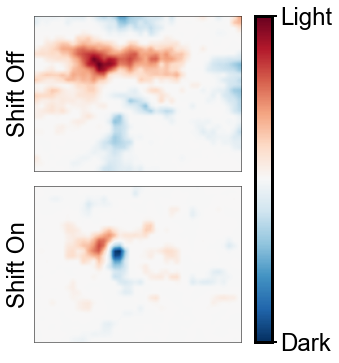

In [44]:
# cells = [25,70,90,117] # 49
cells = [22]#,25,73,74] #np.arange(18)
num_cells = len(cells)

fig1 = plt.figure(constrained_layout=False, figsize=(int(5*params['nt_glm_lag']),int(3*(num_cells*2))))
spec2 = gridspec.GridSpec(ncols=1, nrows=num_cells*2, figure=fig1, wspace=.05,hspace=.1)
axs1 = np.array([fig1.add_subplot(spec2[n,m]) for n in range(num_cells*2) for m in range(1)]).reshape(num_cells*2,1)
lag = 1
for n, cell in enumerate(cells):
    crange2 = np.max(np.abs(NoSh_data[date_ani2[da]]['VisNoSh_rf_up'][cell]))
    im2 = axs1[n,0].imshow(NoSh_data[date_ani2[da]]['VisNoSh_rf_up'][cell,lag],'RdBu_r', vmin=-crange2, vmax=crange2)
    axs1[n,0].set_ylabel('Shift Off',fontsize=fontsize)
    crange2 = np.max(np.abs(All_data[date_ani2[da]]['Vis_rf_up'][cell]))
    im2 = axs1[n+1,0].imshow(All_data[date_ani2[da]]['Vis_rf_up'][cell,lag],'RdBu_r', vmin=-crange2, vmax=crange2)
    axs1[n+1,0].set_ylabel('Shift On',fontsize=fontsize)
cbar2 = fig1.colorbar(im2, ax=axs1.ravel().tolist())
cbar2.set_ticks([-crange2, crange2])
cbar2.set_ticklabels(['Dark', 'Light'])
cbar2.ax.tick_params(labelsize=fontsize)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

# fig1.savefig(paper_fig_dir/('NoShifter_FM_RFs_'+model_info+'.pdf'), facecolor='white', transparent=True, bbox_inches='tight',dpi=300)
# print('Saved to: {}'.format(FigPath_SFN/'FM_RFs.png'))

In [ ]:
# Histogram of theta, phi, omega, next to shifter matrix grid. Justification for why some RF are there when shifter is off. Large receptive fields ~10 degrees, shifts are ~10 degrees.

### R2 for Shift/Non-shift

In [82]:

args['NoL1'] = False
if args['NoL1'] == True: 
    L1 = 'NoL1'
    mod_name = '*Vis_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_shuffled_best'.format(L1,int(params_FM['model_dt']*1000), 1, params_FM['Nepochs'],Kfold)
else: 
    L1 = 'withL1'
    mod_name = '*Vis_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_shuffled_best'.format(L1,int(params_FM['model_dt']*1000), 1, params_FM['Nepochs'],Kfold)
ModelList = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))


GLM_Shuff = ioh5.load(ModelList[0])
malph = 0*np.ones(params_FM['Ncells'],dtype=int)
mlam_FM_NoSh = np.nanargmin(GLM_FM_NoSh['loss_regcv'][0],axis=0) #11*np.ones(params['Ncells'],dtype=int)# 
mlam_FM = np.nanargmin(GLM_FM['loss_regcv'][0],axis=0) #11*np.ones(params['Ncells'],dtype=int)# 
cellnum = np.arange(params_FM['Ncells'])
r2_all = np.stack((GLM_Shuff['r2_test'],GLM_FM_NoSh['r2_test'][malph,mlam_FM_NoSh,cellnum],GLM_FM['r2_test'][malph,mlam_FM,cellnum]))

IndexError: list index out of range

NameError: name 'r2_all' is not defined

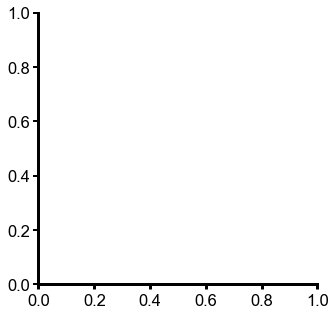

In [25]:
hbins = .02
sta_titles = ['Shuffle','Shifter Off','Shifter On']
mod_clrs = ['#ff0000',"#084c61","#db504a"]
move_clrs = ['blue','orange','green','red']
lim0 = 0
lim1 = .7
dlim = .2
xlab = r'$r^2$'
fig1, axs = plt.subplots(figsize=(5,5)) 
for n in range(r2_all.shape[0]):
    ax = axs
    count,edges = np.histogram(r2_all[n],bins=np.arange(lim0,lim1,hbins))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(r2_all[n]),color=mod_clrs[n],width=hbins, alpha=.75,label=sta_titles[n])
    ax.set_xticks(np.arange(lim0,lim1,dlim))
    ax.set_xticklabels(np.round(np.arange(lim0,lim1,dlim),decimals=1))
    ax.set_xlabel(xlab)
    ax.axvline(x=np.nanmean(r2_all,axis=1)[n],c=mod_clrs[n],ls='--')
ax.legend(labelcolor='linecolor', fontsize=12, handlelength=0, handletextpad=0, fancybox=True)

In [21]:
SimFit_smooth.shape,Sim_act_smooth.shape,

((9001, 64), (64, 9001))

In [22]:
SimRF_file = params['save_dir'].parent.parent.parent/'121521/SimRF/fm1/SimRF_{}_dt{:03d}_T{:02d}_Model1_NB{}_Kfold{:02d}_best.h5'.format(L1,int(params['model_dt']*1000), 1, params['Nepochs'],Kfold)
SimRFfit_file = '/home/seuss/Research/SensoryMotorPred_Data/data/121521/SimRF/fm1/GLM_Network/MovModel1/version_0/SimRF/GLM_Pytorch_Vis_withL1_SimRF_dt050_T01_MovModel1_NB10000_Kfold00_best.h5'
SimFit_Data = ioh5.load(SimRFfit_file)
SimRF_Data = ioh5.load(SimRF_file)
RF_SimFit = SimFit_Data['Cell_NN.0.weight'].reshape((SimFit_Data['Cell_NN.0.weight'].shape[0],1,)+(30,40))
SimFit_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=SimFit_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
Sim_act_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=SimRF_Data['yte'].copy())[params['bin_length']:-params['bin_length']].T
Sim_r2 = np.array([(np.corrcoef(SimFit_smooth[:,celln],Sim_act_smooth[celln])[0, 1])**2 for celln in range(Sim_act_smooth.shape[0])])

Sim_cc = np.array([(np.corrcoef(SimRF_Data['RF_actual'][celln].flatten(),RF_SimFit[celln,0].flatten())[0, 1]) for celln in range(Sim_act_smooth.shape[0])])

### Full Figure V1

/tmp/ipykernel_402327/1879103823.py:123: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig1.savefig(paper_fig_dir/('Figure2_draft.pdf'), facecolor='white', transparent=True, bbox_inches='tight',dpi=300)
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


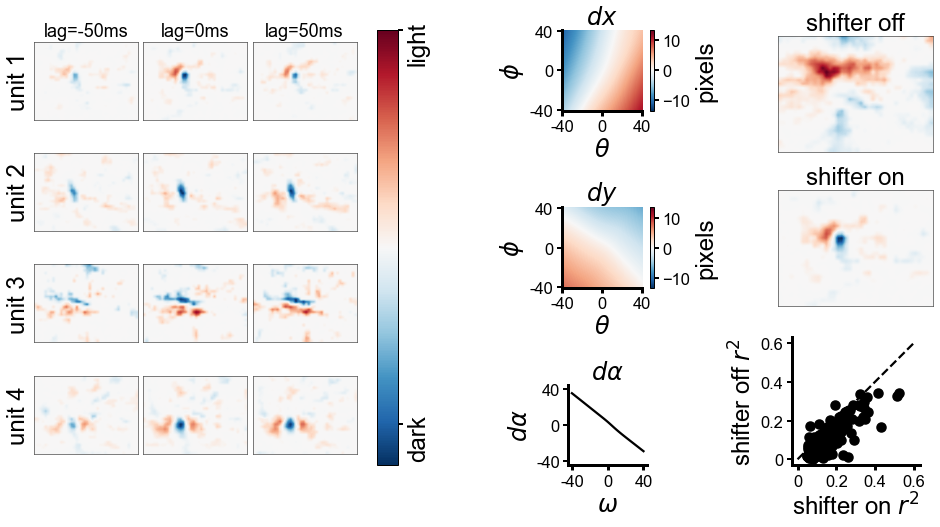

In [47]:
vals_Vis = np.hstack([All_data[date_ani2[da]]['Vis_r2_test'] for da in range(len(dates_all))])
vals_VisNoSh = np.hstack([NoSh_data[date_ani2[da]]['VisNoSh_r2_test'] for da in range(len(dates_all))])
r2_all = np.stack((vals_VisNoSh,vals_Vis))
params['nt_glm_lag']=3
fig1 = plt.figure(constrained_layout=True, figsize=(25,8))
gs0 = fig1.add_gridspec(nrows=2, ncols=6, wspace=.6, hspace=.4)
lag_ls = [-50,0,50]
########## Fig 2B ########## 
da=0
cells = [22,34,42,101] #np.arange(18)
gs00 = gs0[:,:2].subgridspec(nrows=len(cells),ncols=3,wspace=.05, hspace=.1)
axs1 = np.array([fig1.add_subplot(gs00[n,m]) for n in range(len(cells)) for m in range(3)]).reshape(len(cells),3)

for n, cell in enumerate(cells):
    crange = np.max(np.abs(All_data[date_ani2[da]]['Vis_rf_up'][cell]))
    for lag in range(params['nt_glm_lag']):
        ax = axs1[n,lag]
        im = ax.imshow(All_data[date_ani2[da]]['Vis_rf_up'][cell,lag],'RdBu_r',vmin=-crange,vmax=crange)
        axs1[0,lag].set_title('lag={}ms'.format(lag_ls[lag]))
        # cbar = add_colorbar(im)
        # ax.axis('off')
    axs1[n,0].set_ylabel('unit {}'.format(n+1),fontsize=fontsize)
cbar2 = fig1.colorbar(im, ax=axs1.ravel().tolist())
cbar2.set_ticks([-crange+.0015, crange])
# cbar2.set_ticks([])
# axs1[0,2].text(5,,'Light',rotation=90)
cbar2.set_ticklabels(['dark', 'light'])
cbar2.ax.tick_params(labelsize=fontsize, rotation=90)
cbar2.outline.set_linewidth(1)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

########## Fig 2C ########## 
gs01 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[:,2],wspace=.2,hspace=1.2)
axs2 = np.array([fig1.add_subplot(gs01[n,m]) for n in range(3) for m in range(1)])

shift_titles = [r'$dx$',r'$dy$',r'$d\alpha,\phi=0$',r'$d\alpha,\theta=0$']
cbar_label = ['pixels','pixels','deg','deg']
ticks=np.arange(0,90,40)
ticklabels=np.arange(-40,50,40)
shift_matshow=np.stack((shift_mat[0,:,:,40].T,shift_mat[1,:,:,40].T,shift_mat[2,:,40,:].T,shift_mat[2,40,:,:].T))
crange_list = np.stack((np.max(np.abs(shift_mat[:2])),np.max(np.abs(shift_mat[:2])), np.max(np.abs(shift_mat[2])), np.max(np.abs(shift_mat[2]))))
for n in range(2):
    ax = axs2[n]
    im1=ax.imshow(shift_matshow[n],vmin=-crange_list[n], vmax=crange_list[n], origin='lower', cmap='RdBu_r')
    cbar1 = add_colorbar(im1)
    cbar1.outline.set_linewidth(1)
    cbar1.set_label(cbar_label[n],fontsize=fontsize)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels)
    ax.set_xlabel(r'$\theta$',fontsize=fontsize)
    ax.set_ylabel(r'$\phi$',fontsize=fontsize)
    ax.set_title(shift_titles[n],fontsize=fontsize)
ax = axs2[2]
ax.plot(FM_move_avg[1, 2]*np.linspace(-pitch_range,pitch_range,81), shift_mat[2, 40, 40, :], 'k')
ax.set_xlabel(r'$\omega$',fontsize=fontsize)
ax.set_ylabel(r'$d\alpha$',fontsize=fontsize)
ax.set_title(r'$d\alpha$',fontsize=fontsize)
ax.set_xticks(ticklabels)
ax.set_xticklabels(ticklabels)
ax.set_yticks([-40,0,40])
ax.set_yticklabels([-40,0,40])
ax.axis('square')
ax.set_ylim(-45, 45)


########## Fig 2D ########## 
gs02 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[:,3:4],wspace=.5,hspace=.2)
axs3 = np.array([fig1.add_subplot(gs02[0,0]), fig1.add_subplot(gs02[1,0])])
lag = 1
da = 0
cells = [22]
for n, cell in enumerate(cells):
    ax = axs3[n]
    crange2 = np.max(np.abs(NoSh_data[date_ani2[da]]['VisNoSh_rf_up'][cell]))
    im2 = ax.imshow(NoSh_data[date_ani2[da]]['VisNoSh_rf_up'][cell,lag],'RdBu_r', vmin=-crange2, vmax=crange2)
    ax.set_title('shifter off',fontsize=fontsize)
    ax = axs3[n+1]
    crange2 = np.max(np.abs(All_data[date_ani2[da]]['Vis_rf_up'][cell]))
    im2 = ax.imshow(All_data[date_ani2[da]]['Vis_rf_up'][cell,lag],'RdBu_r', vmin=-crange2, vmax=crange2)
    ax.set_title('shifter on',fontsize=fontsize)

for ax in axs3.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])



########## Fig 2E ########## 
# gs03 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1,3:4],wspace=.05,hspace=.5)
axs4 = fig1.add_subplot(gs02[2, :])

ax = axs4
vis_th = r2_all[1] > .05
ax.scatter(r2_all[1][vis_th], r2_all[0][vis_th],c='k')
ax.plot(np.linspace(0, .6, 100), np.linspace(0, .6, 100), 'k--')
ax.set_xlabel(r'shifter on $r^2$',fontsize=fontsize)
ax.set_ylabel(r'shifter off $r^2$',fontsize=fontsize)
ax.set_xticks([0,.2,.4,.6])
ax.set_xticklabels([0,.2,.4,.6])
ax.set_yticks([0, .2, .4, .6])
ax.set_yticklabels([0, .2, .4, .6])
ax.axis('square')

# gs03 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[1:,4:],wspace=.1,hspace=.4)
# axs5 = np.array([fig1.add_subplot(gs03[n,m]) for n in range(1) for m in range(2)])


fig1.savefig(paper_fig_dir/('Figure2_draft.pdf'), facecolor='white', transparent=True, bbox_inches='tight',dpi=300)


### Full Figure V2

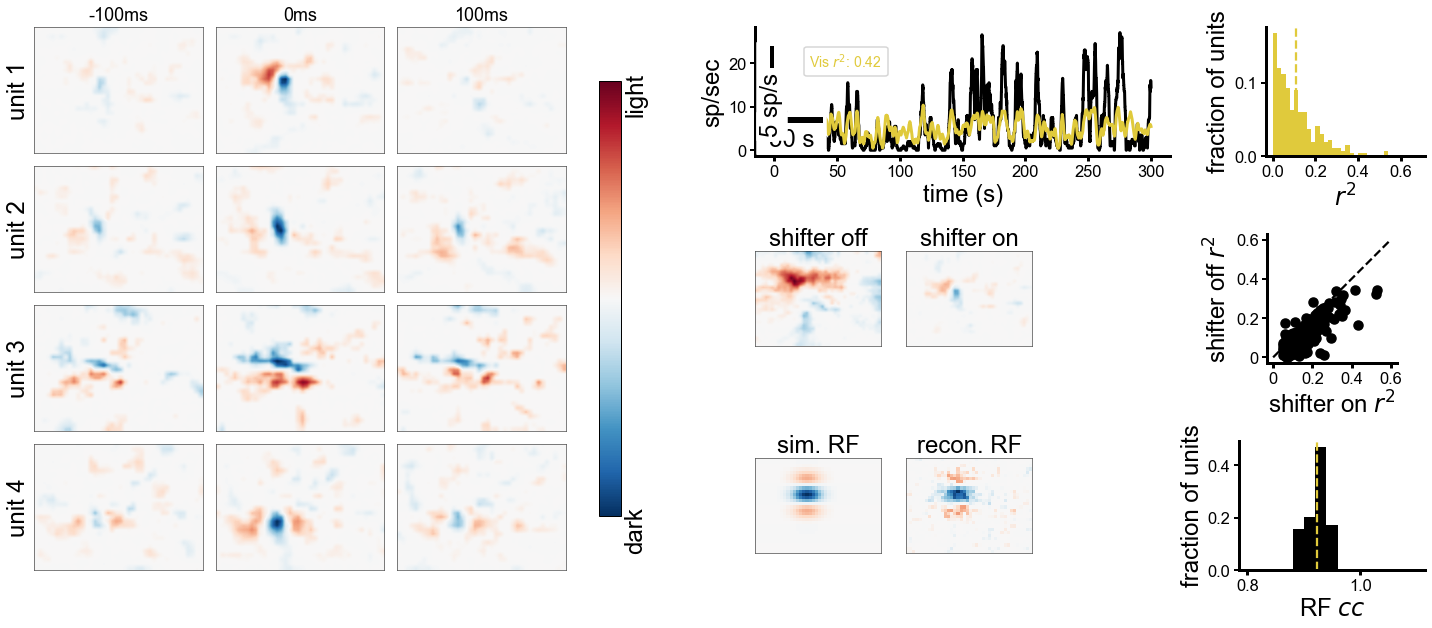

In [24]:
vals_Vis = np.hstack([All_data[date_ani2[da]]['Vis_r2_test'] for da in range(len(dates_all))])
vals_VisNoSh = np.hstack([NoSh_data[date_ani2[da]]['VisNoSh_r2_test'] for da in range(len(dates_all))])
r2_all = np.stack((vals_VisNoSh,vals_Vis))

fig1 = plt.figure(constrained_layout=False, figsize=(25,10))
gs0 = fig1.add_gridspec(nrows=3, ncols=6, wspace=.3, hspace=.6)
lag_ls = [-100,0,100]
lag_list = [0,2,4]
########## Fig 2B ########## 
da=0
cells = [22,34,42,101] #np.arange(18)
gs00 = gridspec.GridSpecFromSubplotSpec(nrows=len(cells),ncols=3, subplot_spec=gs0[:,:3], wspace=.05, hspace=.1)
axs1 = np.array([fig1.add_subplot(gs00[n,m]) for n in range(len(cells)) for m in range(3)]).reshape(len(cells),3)
params['nt_glm_lag']=5
for n, cell in enumerate(cells):
    crange = np.max(np.abs(All_data[date_ani2[da]]['Vis_rf_up'][cell]))
    for m,lag in enumerate(lag_list):
        ax = axs1[n,m]
        im = ax.imshow(All_data[date_ani2[da]]['Vis_rf_up'][cell,lag],'RdBu_r',vmin=-crange,vmax=crange)
        axs1[0,m].set_title('{}ms'.format(lag_ls[m]))
    axs1[n,0].set_ylabel('unit {}'.format(n+1),fontsize=fontsize)

cbar2 = fig1.colorbar(im, ax=axs1,shrink=.8)
cbar2.set_ticks([-crange, crange])
cbar2.set_ticklabels(['dark', 'light'])
cbar2.ax.tick_params(labelsize=fontsize, rotation=90,width=0,length=0)
cbar2.outline.set_linewidth(1)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

########## Fig 2C ########## 
gs02 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0,3:],wspace=.6,hspace=.2)
axs3 = np.array([fig1.add_subplot(gs02[0,:2]), fig1.add_subplot(gs02[0,2])])

celln = 42
da = 0
modN = 1
ax = axs3[0]
t = np.argmin(np.abs((np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])-0)) # 200 seconds in #6000
dt = int(300/params['model_dt']) #All_data[date_ani2[da]]['actual_smooth'].shape[0] # dt in seconds converted to time points
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax.plot(pred_time,All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln],c='k',lw=3,zorder=0)
ax.plot(pred_time,All_data[date_ani2[da]][mod_titles[modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=3,
            label='{} $r^2$: {:.02f}'.format(mod_titles[modN],All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln]),zorder=1)
ax.legend(labelcolor='linecolor', fontsize=14, handlelength=0, handletextpad=0,loc='upper left',ncol=4, bbox_to_anchor=(.1, .9))
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)
scale1 = ScaleBar(dx=1, width_fraction=.05,location='lower left',scale_formatter=lambda value, unit: f'{value} s')
scale2 = ScaleBar(dx=1, width_fraction=.01,rotation="vertical",location='center left',scale_formatter=lambda value, unit: f'{value} sp/s')
ax.add_artist(scale1)
ax.add_artist(scale2)

ax = axs3[1]
hbins = .02
sta_titles = ['Shifter Off','Shifter On']
NoShift_clrs = ["#050505", "#C41508"]
lim0 = 0
lim1 = .7
dlim = .2
xlab = r'$r^2$'
count,edges = np.histogram(r2_all[1],bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(r2_all[1]),color=mod_clrs[1],width=hbins, alpha=1)
ax.set_xticks(np.arange(lim0,lim1,dlim))
ax.set_xticklabels(np.round(np.arange(lim0,lim1,dlim),decimals=1))
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(r2_all[1]), c=mod_clrs[1], ls='--')
ax.set_ylabel('fraction of units',fontsize=fontsize)

########## Fig 2D ########## 
gs02 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1,3:5],wspace=.2,hspace=.2)
axs3 = np.array([fig1.add_subplot(gs02[0,0]), fig1.add_subplot(gs02[0,1])])
lag = 1
da = 0
cells = [22]
for n, cell in enumerate(cells):
    ax = axs3[n]
    crange2 = np.max(np.abs(NoSh_data[date_ani2[da]]['VisNoSh_rf_up'][cell]))
    im2 = ax.imshow(NoSh_data[date_ani2[da]]['VisNoSh_rf_up'][cell,lag],'RdBu_r', vmin=-crange2, vmax=crange2)
    ax.set_title('shifter off',fontsize=fontsize)
    ax = axs3[n+1]
    crange2 = np.max(np.abs(All_data[date_ani2[da]]['Vis_rf_up'][cell]))
    im2 = ax.imshow(All_data[date_ani2[da]]['Vis_rf_up'][cell,lag],'RdBu_r', vmin=-crange2, vmax=crange2)
    ax.set_title('shifter on',fontsize=fontsize)

for ax in axs3.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])



########## Fig 2E ########## 
gs03 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1,5],wspace=.1,hspace=.5)
axs4 = fig1.add_subplot(gs03[0, 0])

ax = axs4
vis_th = r2_all[1] > .05
ax.scatter(r2_all[1][vis_th], r2_all[0][vis_th],c='k')
ax.plot(np.linspace(0, .6, 100), np.linspace(0, .6, 100), 'k--')
ax.set_xlabel(r'shifter on $r^2$',fontsize=fontsize)
ax.set_ylabel(r'shifter off $r^2$',fontsize=fontsize)
ax.set_xticks([0,.2,.4,.6])
ax.set_xticklabels([0,.2,.4,.6])
ax.set_yticks([0, .2, .4, .6])
ax.set_yticklabels([0, .2, .4, .6])
ax.axis('square')


########## Fig 2F ########## 
gs03 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[2,3:5],wspace=.2,hspace=.1)
axs4 = np.array([fig1.add_subplot(gs03[n,m]) for n in range(1) for m in range(2)])

lag = 1
da = 0
cells = [22]
for n, cell in enumerate(cells):
    ax = axs4[n]
    crange2 = np.max(np.abs(SimRF_Data['RF_actual'][cell]))
    im2 = ax.imshow(SimRF_Data['RF_actual'][cell],'RdBu_r', vmin=-crange2, vmax=crange2)
    ax.set_title('sim. RF', fontsize=fontsize)
    ax = axs4[n+1]
    crange1 = np.max(np.abs(RF_SimFit[cell]))
    im2 = ax.imshow(RF_SimFit[cell,0],'RdBu_r', vmin=-crange1, vmax=crange1)
    ax.set_title('recon. RF', fontsize=fontsize)

for ax in axs4.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

########## Fig 2G ########## 
gs05 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[2,5],wspace=.1,hspace=.1)
axs5 = np.array([fig1.add_subplot(gs05[0,0])])
ax=axs5[0]
lim0 = .8
lim1 = 1.1
dlim = .2
xlab = r'RF $cc$'
count,edges = np.histogram(Sim_cc,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(Sim_cc),color='k',width=hbins, alpha=1)
ax.set_xticks(np.arange(lim0,lim1,dlim))
ax.set_xticklabels(np.round(np.arange(lim0,lim1,dlim),decimals=1))
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(Sim_cc), c=mod_clrs[1], ls='--')
ax.set_ylabel('fraction of units',fontsize=fontsize)


fig1.savefig(paper_fig_dir/('Figure2_draft_V2.pdf'), facecolor='white', transparent=True, bbox_inches='tight',dpi=300)


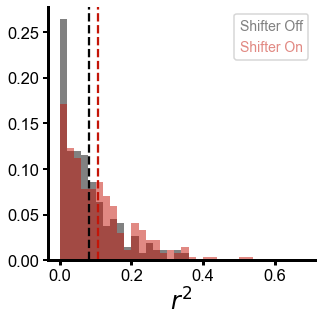

In [103]:
fig, axs4 = plt.subplots(figsize=(5,5))
hbins = .02
sta_titles = ['Shifter Off','Shifter On']
NoShift_clrs = ["#050505", "#C41508"]
move_clrs = ['blue','orange','green','red']
lim0 = 0
lim1 = .7
dlim = .2
xlab = r'$r^2$'
for n in range(r2_all.shape[0]):
    ax = axs4
    count,edges = np.histogram(r2_all[n],bins=np.arange(lim0,lim1,hbins))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(r2_all[n]),color=NoShift_clrs[n],width=hbins, alpha=.5,label=sta_titles[n])
    ax.set_xticks(np.arange(lim0,lim1,dlim))
    ax.set_xticklabels(np.round(np.arange(lim0,lim1,dlim),decimals=1))
    ax.set_xlabel(xlab,fontsize=fontsize)
    ax.axvline(x=np.nanmean(r2_all[n]), c=NoShift_clrs[n], ls='--')
ax.legend(labelcolor='linecolor', fontsize=14, handlelength=0, handletextpad=0, fancybox=True)
plt.tight_layout()


## Figure 3

### Full Figure

In [104]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani'] = dates_all[0]
args['train_shifter']=False
args['NoL1'] = False
args['Nepochs'] = 5000
params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)
params['nt_glm_lag']=1
data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}'.format(params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter']))

mod_titles = ['Mot','Vis','Add','Mul']
mod_clrs = ["#136f63","#e0ca3c","#f34213","#80a4ed"]
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' 
ModelList_FM = []
ModelList_HF = []
for d,date_ani in enumerate(dates_all):
    ##### Free-Moving #####
    args['free_move']=True
    args['date_ani'] = date_ani
    args['NoL1']=False
    args['Nepochs'] = 10000
    date_ani2 = params['save_dir_fm'].parent.parent.parent/date_ani
    if args['NoL1'] == True: 
        L1 = 'NoL1'
        mod_name = '*Vis_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    else: 
        L1 = 'withL1'
        mod_name = '*Vis_{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted(list(date_ani2.rglob(mod_name+'.h5'))))[0]
    ModelList_FM.append(ModelList)
    ModelList = np.array(sorted(list(date_ani2.rglob(mod_name+'.h5'))))[1]
    ModelList_HF.append(ModelList)
    
ModelList_FM = np.stack(ModelList_FM)
ModelList_HF = np.stack(ModelList_HF)

    
RF_all = []
r2_all = []
for n,(modfm,modhf) in enumerate(zip(ModelList_FM,ModelList_HF)):
    GLM_FM = ioh5.load(modfm)
    GLM_HF = ioh5.load(modhf)
    r2_all.append(np.stack((GLM_FM['r2_test'],GLM_HF['r2_test'])))
    RF_FM = GLM_FM['Cell_NN.0.weight'].reshape((GLM_FM['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
    RF_HF = GLM_HF['Cell_NN.0.weight'].reshape((GLM_HF['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
    RF_all.append(np.stack((RF_FM,RF_HF)))
RF_all = np.concatenate(RF_all,axis=1)

sf=4
RF_all_up = np.zeros((RF_all.shape[:3] + ( sf*(RF_all.shape[-2]), sf*(RF_all.shape[-1]))))
for n in range(RF_all.shape[0]):
    for celln in range(RF_all.shape[1]):
        for t in range(RF_all.shape[2]):
            RF_all_up[n,celln,t] = cv2.resize(RF_all[n,celln,t], (sf*(RF_all.shape[-1]), sf*(RF_all.shape[-2])))
r2_FMHF_RF = np.zeros(RF_all.shape[1])
for celln in np.arange(RF_all.shape[1]):
    r2_FMHF_RF[celln] = np.corrcoef(RF_all[0,celln,0].flatten(),RF_all[1,celln,0].flatten())[0,1]

Done Loading Unaligned data
Model: 1, LinMix: False, move_features: None, Ncells: 108, train_shifter: False


In [105]:
RF_all = []
r2_all = []
NCells_all = []
for n,(modfm,modhf) in enumerate(zip(ModelList_FM,ModelList_HF)):
    GLM_FM = ioh5.load(modfm)
    GLM_HF = ioh5.load(modhf)
    r2_all.append(np.stack((GLM_FM['r2_test'],GLM_HF['r2_test'])))
    RF_FM = GLM_FM['Cell_NN.0.weight'].reshape((GLM_FM['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
    RF_HF = GLM_HF['Cell_NN.0.weight'].reshape((GLM_HF['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
    RF_all.append(np.stack((RF_FM,RF_HF)))
    NCells_all.append(len(GLM_FM['r2_test']))
RF_all = np.concatenate(RF_all,axis=1)
r2_all = np.concatenate(r2_all,axis=1)

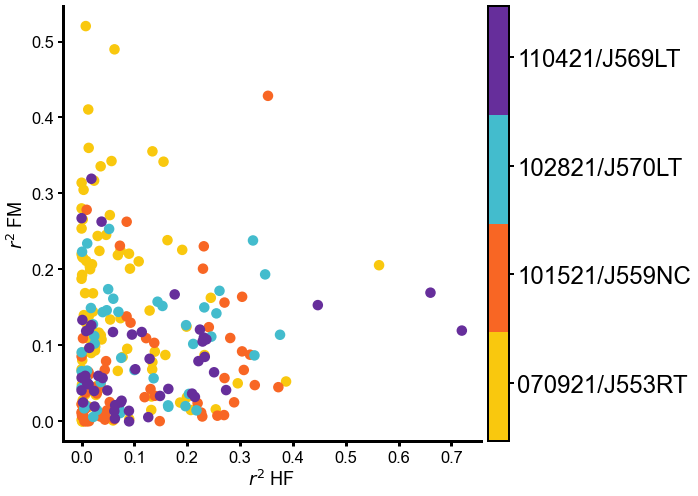

In [43]:
scat_clr = ["#f9c80e","#f86624","#43bccd","#662e9b"] # 
scat_clr_all = np.hstack([NCells_all[n]*[scat_clr[n]] for n in range(len(scat_clr))])
clrs_all, labels = pd.factorize(scat_clr_all)
cmap = mpl.colors.ListedColormap(scat_clr)
fig,ax = plt.subplots(figsize=(8,8))
im = ax.scatter(r2_all[1],r2_all[0],c=clrs_all,cmap=cmap)
ax.set_xlabel('$r^2$ HF')
ax.set_ylabel('$r^2$ FM')
cbar = add_colorbar(im)
cbar.set_ticks(np.arange(.4,3.25,.75))
cbar.set_ticklabels(dates_all)
cbar.ax.tick_params(labelsize=fontsize)
# fig.savefig(paper_fig_dir/'R2_all_HF_FM.png', facecolor='white', transparent=True, bbox_inches='tight')

In [124]:
celln = 6
sorted_r2 = np.argsort(vals_FMHF)[::-1]  # Sorted indecies for R2
vals_FMHF[celln], sorted_r2


(0.12717299062014434,
 array([244, 142, 264, 154, 118,  77, 130, 159, 133, 249, 254, 148, 156,
        224, 242,  18, 117, 143, 230, 141, 237, 168, 218, 250, 258,  57,
        212, 265, 101,  11,  34, 225, 138, 109,  87, 139, 191,  49, 124,
        236, 195, 175,  89, 192, 134, 247,  52,  64, 152, 251,  41,  44,
        233, 105, 205,  95, 176, 177, 132, 116, 100, 211,  65, 222, 125,
        174,  29,  81, 188,  99, 173, 136, 157,  61, 184, 179, 256,  68,
        140,  55, 197, 227, 259, 137, 185, 163,  60, 199,  59,  91,  90,
         67, 135,  88, 262, 119,  85,  10,  83, 213,  50, 106, 164, 151,
          3,  48,  66, 165, 246, 198,  33,   6,  62,  25,  21, 240,  97,
        231,  12, 241,  79,  38, 121, 111, 194,  96, 155, 178, 182,  42,
         58, 112,  35,  72, 267,  16,  80, 219, 228, 221,  75,  70,  53,
         17, 248, 181, 255, 127, 239,  14, 200, 108,  78, 149, 161,  69,
        171, 257, 122,  71, 232, 229, 266, 215,  54, 206, 187,  47,  13,
         84, 110,  51, 217, 2

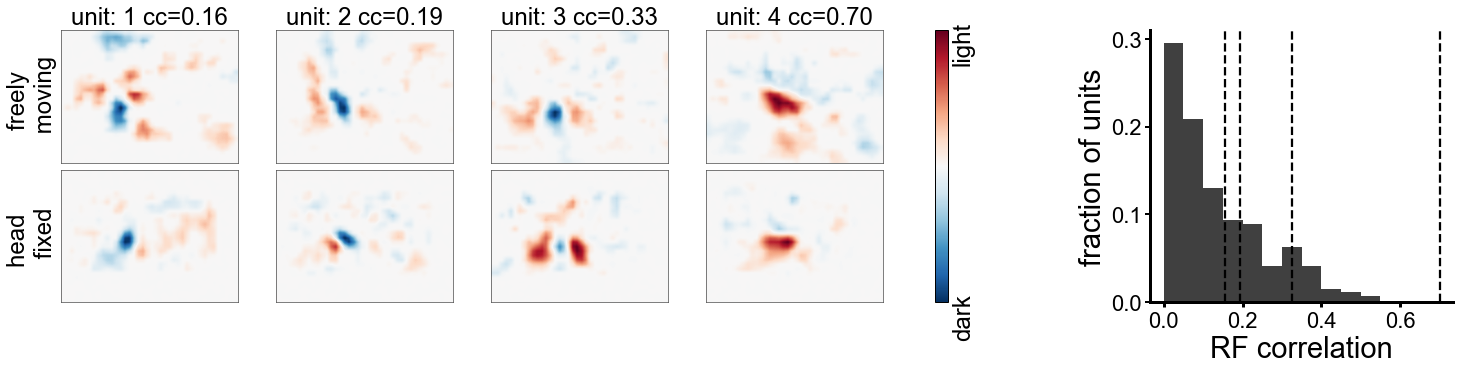

In [27]:
fontsize=24
da=0
vals_FMHF  = np.hstack([All_data[date_ani2[da]]['HF_FMHF_r2']  for da in range(len(dates_all))])
RF_all = np.stack((np.vstack([All_data[date_ani2[da]]['Vis_rf_up'] for da in range(len(dates_all))]),np.vstack([All_data[date_ani2[da]]['HF_rf_up'] for da in range(len(dates_all))])))
sorted_r2 = np.argsort(vals_FMHF)[::-1] ##### Sorted indecies for R2
fig1 = plt.figure(constrained_layout=False, figsize=(25,5))
gs0 = gridspec.GridSpec(ncols=4, nrows=2, figure=fig1,wspace=.2,hspace=.3)
lag_ls = [-50,0,50]

########## Fig 3A ########## 
cells = [53,61,101,244] # 
num_cells = len(cells)

gs00 = gridspec.GridSpecFromSubplotSpec(2, num_cells, subplot_spec=gs0[:,:3],wspace=.2,hspace=.05)
axs1 = np.array([fig1.add_subplot(gs00[n,m]) for n in range(2) for m in range(num_cells)]).reshape(2,num_cells)
xcut1=0
xcut2=-0
ycut1=0
ycut2=-0
for n, cell in enumerate(cells):
    crange2 = np.max(np.abs(RF_all[0,cell,2])) #int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)
    im2 = axs1[0,n].imshow(RF_all[0,cell, 2],'RdBu_r', vmin=-crange2, vmax=crange2) #int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)
    crange1 = np.max(np.abs(RF_all[1,cell,2])) #int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)
    im1 = axs1[1,n].imshow(RF_all[1,cell, 2], 'RdBu_r', vmin=-crange1, vmax=crange1) #int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)
    axs1[0,n].set_title('unit: {} cc={:.02f}'.format(n+1,vals_FMHF[cell]), fontsize=fontsize)

axs1[1,0].set_ylabel('head \n fixed', fontsize=fontsize)
axs1[0,0].set_ylabel('freely \n moving', fontsize=fontsize)

cbar2 = fig1.colorbar(im, ax=axs1)
cbar2.set_ticks([-crange, crange])
cbar2.set_ticklabels(['dark', 'light'])
cbar2.ax.tick_params(labelsize=fontsize, rotation=90,width=0,length=0)
cbar2.outline.set_linewidth(1)

for ax in axs1.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])   

########## Fig 3B ########## 
gs01 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[:,3:],wspace=.05,hspace=.1)
axs2 = fig1.add_subplot(gs01[0,0])
vals_Vis = np.hstack([All_data[date_ani2[da]]['Vis_r2_test'] for da in range(len(dates_all))])
vals_HF  = np.hstack([All_data[date_ani2[da]]['HF_r2_test'] for da in range(len(dates_all))])
# vals_FMHF_th = (vals_Vis>.05) & (vals_HF>.05)
ax = axs2
hbins=.05
lim0 = 0
lim1 = .75
dlim = .2
ylim = .4
dylim = .1
count,edges = np.histogram(np.abs(vals_FMHF),bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_FMHF),color='k',width=hbins, alpha=.75)
ax.set_xlabel('RF correlation',fontsize=fontsize+5)
ax.set_ylabel('fraction of units',fontsize=fontsize+5)
ax.set_yticks(np.arange(lim0,ylim,dylim))
ax.set_yticklabels(np.round(np.arange(lim0,ylim,dylim),decimals=3),fontsize=fontsize-2)
ax.set_xticks(np.arange(lim0,lim1,dlim))
ax.set_xticklabels(np.round(np.arange(lim0,lim1,dlim),decimals=1), fontsize=fontsize-2)
# axs2.set_xlim(0,.8)
# axs2.set_ylim(0,.25)
for cell in cells:
    ax.axvline(x=vals_FMHF[cell],ls='--',c='k')
ax.annotate("", xy=(.75, 0.25), xytext=(.2, .2), arrowprops=dict(arrowstyle="->"))

# plt.tight_layout()
plt.show()
fig1.savefig(paper_fig_dir/'Figure3_draft.pdf', facecolor='white', transparent=True, bbox_inches='tight')


## Figure 4

In [115]:
celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
celltype = pickle.load(open(celltype_file,'rb'))

Kfold = 0
args['free_move']=True
mod_titles = ['Mot','Vis','Add','Mul']
mod_clrs = ["#136f63","#e0ca3c","#f34213","#80a4ed"]
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' 
ModelList_all = []
test_std =[]
tuning_sig_all = []
tuning_sig_all2 = []
NCells_all = []
bad_cells_all = []
test_nsp_all = []
for d,date_ani in enumerate(dates_all):
    args['date_ani'] = date_ani
    args['NoL1']=False
    args['Nepochs'] = 10000
    params,_,_ = load_params(0,Kfold,args,debug=True)
    params['nt_glm_lag']=5
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    if args['NoL1'] == True: 
        L1 = 'NoL1'
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    else: 
        L1 = 'withL1'
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted(list(set(date_ani_dir.rglob(mod_name+'.h5')) - set(date_ani_dir.rglob('*VisNoShifter'+mod_name+'.h5')))))
    ModelList_all.append(ModelList)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    test_nsp_all.append(data['test_nsp'])
    test_std.append(np.var(data['test_nsp'],axis=0))
    tuning_sig_all.append(tuning_sig)
    tuning_sig_all2.append(tuning_sig2)
    NCells_all.append(len(tuning_sig2))
ModelList_all = np.stack(ModelList_all)
test_std=np.hstack(test_std)
tuning_sig_all2 = np.hstack(tuning_sig_all2)
tuning_sig_all = np.vstack(tuning_sig_all).squeeze()


Done Loading Unaligned data
Done Loading Unaligned data
Done Loading Unaligned data
Done Loading Unaligned data


In [116]:
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
All_data = {date_ani2[n]:{} for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    All_data[date_ani]['actual_meanfr'] = np.mean(test_nsp_all[da],axis=0)/params['model_dt']
    All_data[date_ani]['actual_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_nsp_all[da])[params['bin_length']:-params['bin_length']]
    for modeln,fmod in enumerate(ModelList_all[da][:-1]):
        GLM_Data = ioh5.load(fmod)
        All_data[date_ani][mod_titles[modeln]+'_pred_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
        All_data[date_ani][mod_titles[modeln]+'_r2_test'] = GLM_Data['r2_test'].copy()
        All_data[date_ani][mod_titles[modeln]+'_vloss_trace'] = np.nanmean(GLM_Data['vloss_trace_all'][:,-10:],axis=1)/np.nanvar(test_nsp_all[da],axis=0)
celltypes_all = []
for n,date_exp in enumerate([2,4,7,9]):
    celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
    celltype2 = celltype2.drop(bad_cells_all[n])
    celltypes_all.append([celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])
celltypes_all = np.hstack(celltypes_all)

In [117]:
da = 1
fontsize=24
args['date_ani'] = dates_all[da]
params,_,_ = load_params(0,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


Done Loading Unaligned data


### Full Figure V1

/tmp/ipykernel_402327/3048816689.py:210: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.round([-.05,0,.05],decimals=2))


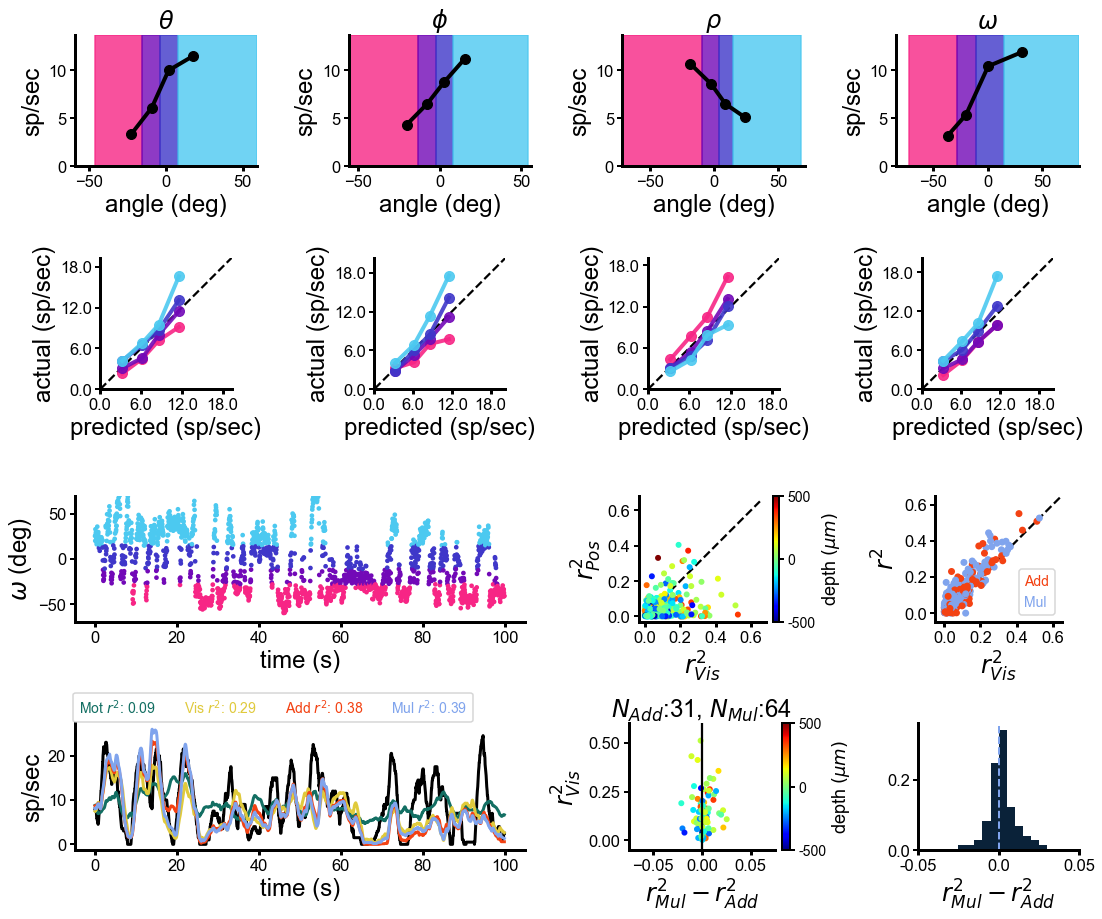

In [53]:
titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$']
celln = 52#106
modN = 1
da = 1
anglim = 70
quartiles = np.arange(0,1.25,.25)
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
ncells=All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'].shape[-1]
predcell = All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'][:,celln]#/params['model_dt']
nspcell = All_data[date_ani2[da]]['actual_smooth'][:,celln]#/params['model_dt']
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin)

fig = plt.figure(constrained_layout=False, figsize=(18,15))
gs0 = gridspec.GridSpec(ncols=4, nrows=2, figure=fig,wspace=.6,hspace=.3)
########## Fig 4A ########## 
gs00 = gridspec.GridSpecFromSubplotSpec(2, len(titles), subplot_spec=gs0[0,:4],wspace=.5,hspace=.7)
axs1 = np.array([fig.add_subplot(gs00[n,m]) for n in range(1) for m in range(len(titles))]).reshape(1,len(titles))
axs1b = np.array([fig.add_subplot(gs00[n,m]) for n in range(1,2) for m in range(len(titles))]).reshape(1,len(titles))

top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
for i,modeln in enumerate(range(len(titles))):
    metric = move_data[params['bin_length']:-params['bin_length'],modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#
    for m in range(len(nranges)-1):
        axs1[0,modeln].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=q_clrs[m],zorder=0)
    axs1[0,modeln].plot(edge_mids,stat_range/params['model_dt'],'.-', ms=20, lw=4,c='k',zorder=1)
    axs1[0,modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
    xlim_range = np.max(np.abs([nranges[0],nranges[-1]]))
    axs1[0,modeln].set_xlim(-xlim_range,xlim_range)
    axs1[0,modeln].set_xlabel('angle (deg)',fontsize=fontsize)
    axs1[0,modeln].set_ylabel('sp/sec',fontsize=fontsize)
    axs1[0,modeln].set_title(titles[modeln],fontsize=fontsize)

    
    stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts 
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]
        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        axs1b[0,modeln].plot(edge_mids, stat_range,'.-', c=q_clrs[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9,zorder=2)
        axs1b[0,modeln].set_xlabel('predicted (sp/sec)',fontsize=fontsize)
        axs1b[0,modeln].set_ylabel('actual (sp/sec)',fontsize=fontsize)
    
    lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
    lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
    axs1b[0,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    # axs1b[0,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8,zorder=1)
    axs1b[0,modeln].set_xticks(np.arange(0,lims[1],int(lims[1]/3)))
    axs1b[0,modeln].set_yticks(np.arange(0,lims[1],int(lims[1]/3)))
    axs1b[0,modeln].set_xticklabels(np.arange(0,lims[1],int(lims[1]/3)))
    axs1b[0,modeln].set_yticklabels(np.arange(0,lims[1],int(lims[1]/3)))
    axs1b[0,modeln].axis('square')
    axs1b[0,modeln].set(xlim=lims, ylim=lims)
    axs1b[0,modeln].set_ylim(bottom=0)
    axs1b[0, modeln].set_xlim(left=0)

########## Fig 4B ########## 
gs01 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[1,:2],wspace=.05,hspace=.8)
axs2 = np.array([fig.add_subplot(gs01[n,m]) for n in range(1) for m in range(1)]).reshape(1,1)
axs2b = np.array([fig.add_subplot(gs01[n,m]) for n in range(1,2) for m in range(1)]).reshape(1,1)

cmap = mpl.colors.ListedColormap(q_clrs)
##### Plotting Position Scatter #####
celln = 52#106
da = 1
t = np.argmin(np.abs((np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])-0)) # 200 seconds in #6000
dt = int(100/params['model_dt']) #All_data[date_ani2[da]]['actual_smooth'].shape[0] # dt in seconds converted to time points
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs2[0,0]
metric = move_data[params['bin_length']:-params['bin_length'],3]
ax.scatter(pred_time, metric[t:t+dt],s=10,c=np.digitize(metric,nranges)[t:t+dt],cmap=cmap)
ax.set_ylabel(r'$\omega$ (deg)',fontsize=fontsize)
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylim([-anglim,anglim])

# celln = 18#106
# da = 0
# t = 6000 #np.argmin(np.abs(pred_time-375)) # T seconds in 
# dt = 3000 #All_data[date_ani2[da]]['actual_smooth'].shape[0]
##### Plotting Firing Rate #####
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs2b[0,0]
zorder = np.argsort([All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln] for modN in range(len(mod_titles))])+1
ax.plot(pred_time,All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln],c='k',lw=3)
for modN in range(len(mod_titles)):
    ax.plot(pred_time,All_data[date_ani2[da]][mod_titles[modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=3,
            label='{} $r^2$: {:.02f}'.format(mod_titles[modN],All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln]),zorder=zorder[n])
ax.legend(labelcolor='linecolor', fontsize=14, handlelength=0, handletextpad=0,loc='upper right',ncol=4, bbox_to_anchor=(.9, 1.3))
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)

########## Fig 4c ########## 
fr_th = 1 # hz
vals_Mot = np.hstack([All_data[date_ani2[da]]['Mot_r2_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['Vis_r2_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['Add_r2_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['Mul_r2_test'] for da in range(len(dates_all))])
gs02 = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=gs0[1,2:4],wspace=.8,hspace=.8)
axs3a = np.array([fig.add_subplot(gs02[n,m]) for n in range(2) for m in range(2)]).reshape(2,2)

tuning_idx = np.where(tuning_sig_all)[0]
lims = (0, .65)
crange=500
##### Vis vs Mot #####
ax = axs3a[0,0]
im=ax.scatter(vals_Vis,vals_Mot,c=celltypes_all[1],cmap='jet',s=20,vmin=-crange,vmax=crange)
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel(r'$r^2_{Vis}$',fontsize=fontsize)
ax.set_ylabel(r'$r^2_{Pos}$',fontsize=fontsize)
ax.set_yticks(np.arange(0,lims[1],.2))
ax.set_yticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
ax.set_ylim(0,lims[1])
ax.set_xlim(0,lims[1])
ax.set_xticks(np.arange(0,lims[1],.2))
ax.set_xticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
ax.axis('square')
cbar = add_colorbar(im)
cbar.set_ticks([-crange,0,crange])
cbar.set_ticklabels([-crange,0,crange])
cbar.ax.tick_params(labelsize=fontsize-10)
cbar.set_label(r'depth $(\mu m)$')

##### Vis vs Add/Mul #####
cmap_mod = mpl.colors.ListedColormap(mod_clrs[2:])
vals_AM = np.max(np.stack((vals_Add,vals_Mul)),axis=0)
AvM = vals_Add<vals_Mul
ax = axs3a[0,1]
scatter=ax.scatter(vals_Vis,vals_AM,30,c=AvM,cmap=cmap_mod)
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel(r'$r^2_{Vis}$',fontsize=fontsize)
ax.set_ylabel(r'$r^2$',fontsize=fontsize)
ax.set_yticks(np.arange(0,lims[1],.2))
ax.set_yticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
ax.set_xticks(np.arange(0,lims[1],.2))
ax.set_xticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
ax.axis('square')
ax.set_ylim(-.05, lims[1])
ax.set_xlim(-.05, lims[1])
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),fontsize=14,markerscale=0, handlelength=0, handletextpad=0,loc="lower right")
legend1.get_texts()[0].set_text('Add')
legend1.get_texts()[0].set_color(mod_clrs[2])
legend1.get_texts()[1].set_text('Mul')
legend1.get_texts()[1].set_color(mod_clrs[3])

move_r2_th = (vals_Mot>.05) # & (vals_Add>vals_Vis) & (vals_Mul>vals_Vis)
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
celltypes_all2 = celltypes_all[:,move_r2_th]

##### R2 Explained Variance #####
diff = vals_Mul-vals_Add
increase = vals_Vis
th = increase>0

NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)
ax=axs3a[1,0]
im = ax.scatter(diff[th],increase[th],c=celltypes_all2[1,th],cmap='jet',s=20,vmin=-500,vmax=500)
ax.axvline(x=0,c='k')
ax.set_ylabel(r'$r^2_{Vis}$',fontsize=fontsize)
ax.set_xlabel(r'$r^2_{Mul}-r^2_{Add}$',fontsize=fontsize)
ax.set_title(r'$N_{{Add}}$:{}, $N_{{Mul}}$:{}'.format(NAdd,NMul),fontsize=fontsize)
ax.set_ylim(-.05,.6)
ax.set_xlim(-.075,.075)
cbar = add_colorbar(im)
cbar.set_ticks([-crange,0,crange])
cbar.set_ticklabels([-crange,0,crange])
cbar.ax.tick_params(labelsize=fontsize-10)
cbar.set_label(r'depth $(\mu m)$')

vals_Mot = np.hstack([All_data[date_ani2[da]]['Mot_r2_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['Vis_r2_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['Add_r2_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['Mul_r2_test'] for da in range(len(dates_all))])
move_r2_th = (vals_Mot>.05) & (vals_Vis>.05) # & (vals_Mul>vals_Vis)
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
celltypes_all2 = celltypes_all[:,move_r2_th]
ax=axs3a[1,1]
hbins=.005
count,edges = np.histogram(vals_Mul-vals_Add,bins=np.arange(-.05,.05,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Mul),color='#0A2239',width=hbins, alpha=1)
ax.axvline(x=0,c=mod_clrs[3],ls='--',lw=2)

ax.set_xticklabels(np.round([-.05,0,.05],decimals=2))
# ax.set_title(mod_titles[n])
ax.set_xlabel(r'$r^2_{Mul}-r^2_{Add}$',fontsize=fontsize)
ax.set_xticks([-.05, 0, .05])
ax.set_xlim([-.05, .05])
plt.show()
gs0.tight_layout(fig)

fig.savefig(paper_fig_dir/'Fig4_draft_Cell52_101521.pdf', facecolor='white', transparent=True, bbox_inches='tight')


### Full Figure V2

<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/colors.py:1159: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/ticker.py:633: UserWarning: Warning: converting a masked element to nan.
  if self._useLocale else fmt % arg)
/tmp/ipykernel_435255/3714320637.py:247: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.round([-.03,0,.03],decimals=2))


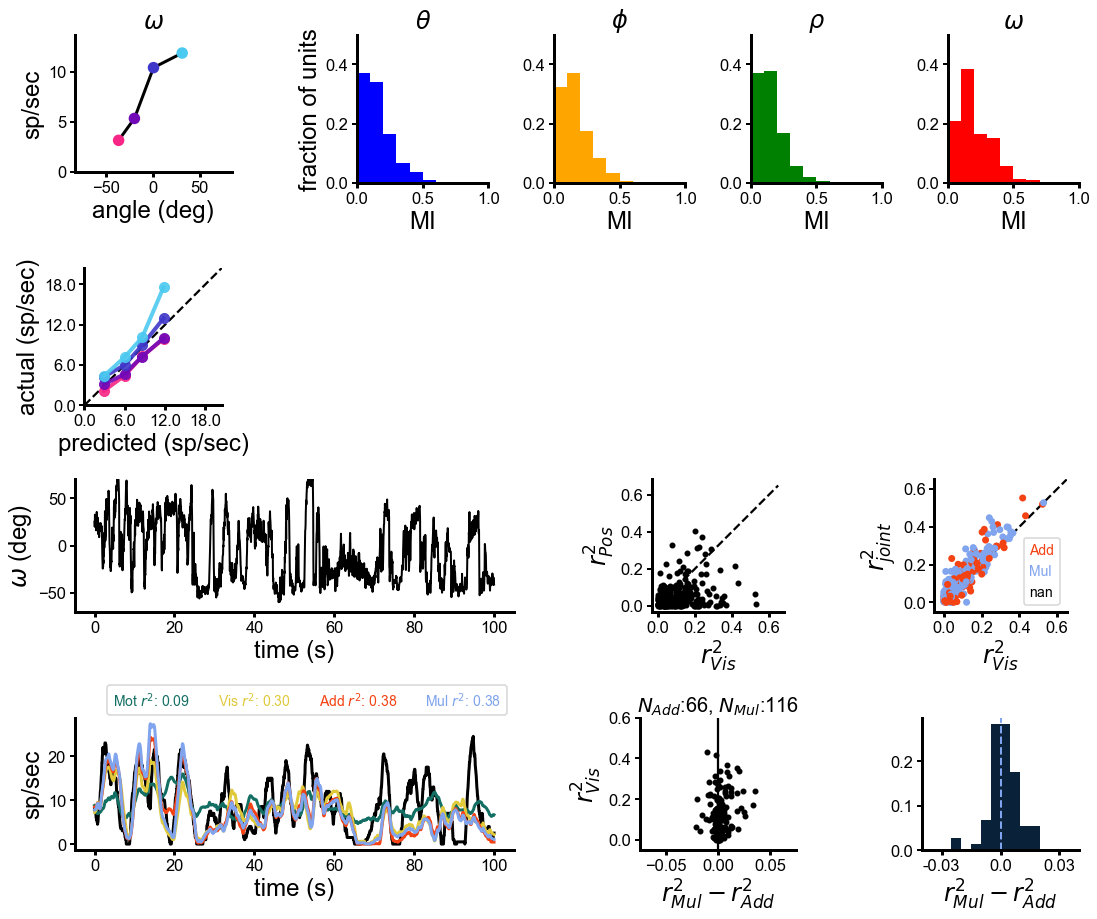

In [130]:
titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$']
celln = 52#106
modN = 1
da = 1
anglim = 70
quartiles = np.arange(0,1.25,.25)
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
ncells=All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'].shape[-1]
predcell = All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'][:,celln]#/params['model_dt']
nspcell = All_data[date_ani2[da]]['actual_smooth'][:,celln]#/params['model_dt']
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin)

fig = plt.figure(constrained_layout=False, figsize=(18,15))
gs0 = gridspec.GridSpec(ncols=4, nrows=4, figure=fig,wspace=.8,hspace=.5)

########## Fig 4A ########## 
gs00 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[:2,:1],wspace=.5,hspace=.7)
axs0a = np.array([fig.add_subplot(gs00[0,0]),fig.add_subplot(gs00[1,0])])
# axs0b = np.array([fig.add_subplot(gs00[n,m]) for n in range(1,2) for m in range(len(titles))]).reshape(1,len(titles))

top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))

modeln = 3
ax = axs0a[0]
metric = move_data[params['bin_length']:-params['bin_length'],modeln]
nranges = np.quantile(metric,quartiles)
stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
edge_mids = np.quantile(metric,spk_percentile2)#
ax.plot(edge_mids,stat_range/params['model_dt'],'-', lw=3,c='k',zorder=0)
ax.scatter(edge_mids,stat_range/params['model_dt'],s=100, c=q_clrs,zorder=1)
ax.set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
xlim_range = np.max(np.abs([nranges[0],nranges[-1]]))
ax.set_xlim(-xlim_range,xlim_range)
ax.set_xlabel('angle (deg)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)
ax.set_title(titles[modeln],fontsize=fontsize)

########## Fig 4C ########## 
ax = axs0a[1]
stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
edge_mids = xbin_pts 
traces_mean[celln,modeln]=stat_all
max_fr = np.max(stat_all)
for n in range(len(nranges)-1):
    ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
    pred = predcell[ind]
    sp = nspcell[ind]
    stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts
    traces[celln,modeln,n]=stat_range
    edges_all[celln,modeln,n]=edge_mids
    ax.plot(edge_mids, stat_range,'.-', c=q_clrs[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9,zorder=2)
    ax.set_xlabel('predicted (sp/sec)',fontsize=fontsize)
    ax.set_ylabel('actual (sp/sec)',fontsize=fontsize)

lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
# ax.plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8,zorder=1)
ax.set_xticks(np.arange(0,lims[1],int(lims[1]/3)))
ax.set_yticks(np.arange(0,lims[1],int(lims[1]/3)))
ax.set_xticklabels(np.arange(0,lims[1],int(lims[1]/3)))
ax.set_yticklabels(np.arange(0,lims[1],int(lims[1]/3)))
ax.axis('square')
ax.set(xlim=lims, ylim=lims)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)


########## Fig 4B ########## 
gs01 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs0[0,1:],wspace=.5,hspace=.7)
axs1a = np.array([fig.add_subplot(gs01[0,n]) for n in range(4)])
dwidth = .1
for modeln in np.arange(len(titles)):
    ax = axs1a[modeln]
    count,edges = np.histogram(tuning_sig_all[:,modeln], bins=np.arange(0,1.1,dwidth))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(tuning_sig_all[:,modeln]),color=clrs[modeln],width=dwidth)
    ax.set_title(r'{}'.format(titles[modeln].lower()), fontsize=fontsize)
    ax.set_xlabel('MI', fontsize=fontsize)
    # ax.set_ylabel('fraction of units', fontsize=fontsize)
    ax.set_xlim(0,1)
    ax.set_yticks(np.round(np.arange(0,.6,.2),decimals=1))
    ax.set_yticklabels(np.round(np.arange(0,.6,.2),decimals=1))
    ax.set_ylim(0,.5)
axs1a[0].set_ylabel('fraction of units', fontsize=fontsize)

########## Fig 4E ########## 
gs02 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[2:,:2],wspace=.05,hspace=.8)
axs2a = np.array([fig.add_subplot(gs02[n,m]) for n in range(1) for m in range(1)]).reshape(1,1)
axs2b = np.array([fig.add_subplot(gs02[n,m]) for n in range(1,2) for m in range(1)]).reshape(1,1)

cmap = mpl.colors.ListedColormap(q_clrs)
##### Plotting Position (Pitch) Scatter #####
celln = 52#106
da = 1
t = np.argmin(np.abs((np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])-0)) # 200 seconds in #6000
dt = int(100/params['model_dt']) #All_data[date_ani2[da]]['actual_smooth'].shape[0] # dt in seconds converted to time points
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs2a[0,0]
metric = move_data[params['bin_length']:-params['bin_length'],3]
ax.plot(pred_time, metric[t:t+dt],lw=2,c='k')
ax.set_ylabel(r'$\omega$ (deg)',fontsize=fontsize)
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylim([-anglim,anglim])

########## Fig 4F ########## 

##### Plotting Firing Rate #####
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs2b[0,0]
zorder = np.argsort([All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln] for modN in range(len(mod_titles))])+1
ax.plot(pred_time,All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln],c='k',lw=3)
for modN in range(len(mod_titles)):
    ax.plot(pred_time,All_data[date_ani2[da]][mod_titles[modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=3,
            label='{} $r^2$: {:.02f}'.format(mod_titles[modN],All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln]),zorder=zorder[n])
ax.legend(labelcolor='linecolor', fontsize=14, handlelength=0, handletextpad=0,loc='upper right',ncol=4, bbox_to_anchor=(1, 1.3))
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)

########## Fig 4G ########## 
fr_th = 1 # hz
vals_Mot = np.hstack([All_data[date_ani2[da]]['Mot_r2_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['Vis_r2_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['Add_r2_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['Mul_r2_test'] for da in range(len(dates_all))])
gs03 = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=gs0[2:,2:4],wspace=.8,hspace=.8)
axs3a = np.array([fig.add_subplot(gs03[n,m]) for n in range(2) for m in range(2)]).reshape(2,2)

tuning_idx = np.where(tuning_sig_all2)[0]
lims = (0, .65)
crange=500
##### Vis vs Mot #####
ax = axs3a[0,0]
# im=ax.scatter(vals_Vis,vals_Mot,c=celltypes_all[1],cmap='jet',s=20,vmin=-crange,vmax=crange)
im=ax.scatter(vals_Vis,vals_Mot,c='k',s=20)
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel(r'$r^2_{Vis}$',fontsize=fontsize)
ax.set_ylabel(r'$r^2_{Pos}$',fontsize=fontsize)
ax.set_yticks(np.arange(0,lims[1],.2))
ax.set_yticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
ax.set_ylim(0,lims[1])
ax.set_xlim(0,lims[1])
ax.set_xticks(np.arange(0,lims[1],.2))
ax.set_xticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
ax.axis('square')
# cbar = add_colorbar(im)
# cbar.set_ticks([-crange,0,crange])
# cbar.set_ticklabels([-crange,0,crange])
# cbar.ax.tick_params(labelsize=fontsize-10)
# cbar.set_label(r'depth $(\mu m)$')

##### Vis vs Add/Mul #####
cmap_mod = mpl.colors.ListedColormap(mod_clrs[2:])
vals_AM = np.nanmax(np.stack((vals_Add,vals_Mul)),axis=0)
AvM = vals_Add<vals_Mul
ax = axs3a[0,1]
scatter=ax.scatter(vals_Vis,vals_AM,30,c=AvM,cmap=cmap_mod)
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel(r'$r^2_{Vis}$',fontsize=fontsize)
ax.set_ylabel(r'$r^2_{joint}$',fontsize=fontsize)
ax.set_yticks(np.arange(0,lims[1],.2))
ax.set_yticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
ax.set_xticks(np.arange(0,lims[1],.2))
ax.set_xticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
ax.axis('square')
ax.set_ylim(-.05, lims[1])
ax.set_xlim(-.05, lims[1])
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),fontsize=14,markerscale=0, handlelength=0, handletextpad=0,loc="lower right")
legend1.get_texts()[0].set_text('Add')
legend1.get_texts()[0].set_color(mod_clrs[2])
legend1.get_texts()[1].set_text('Mul')
legend1.get_texts()[1].set_color(mod_clrs[3])

move_r2_th = ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) # (vals_Mot>.05) & (vals_Vis>.05) &
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
celltypes_all2 = celltypes_all[:,move_r2_th]

##### R2 Explained Variance #####
# xvals = vals_Add-vals_Vis
# yvals = vals_Mul-vals_Vis
# diff = vals_Mul-vals_Add
# th = vals_Vis>0

# NMul = np.sum(xvals[th]<yvals[th])
# NAdd = np.sum(xvals[th]>yvals[th])
# ax=axs3a[1,0]
# im = ax.scatter(xvals[th],yvals[th],c='k',s=20)
# ax.plot(np.linspace(0,.2,100),np.linspace(0,.2,100),'k--',lw=2,zorder=0)
# ax.set_ylabel(r'$r^2_{Mul} - r^2_{Vis}$',fontsize=fontsize)
# ax.set_xlabel(r'$r^2_{Add}-r^2_{Vis}$',fontsize=fontsize)
# ax.set_title(r'$N_{{Add}}$:{}, $N_{{Mul}}$:{}'.format(NAdd,NMul),fontsize=18)

##### R2 Explained Variance V2 #####
diff = vals_Mul-vals_Add
increase = vals_Vis
th = increase>0

NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)
ax=axs3a[1,0]
im = ax.scatter(diff[th],increase[th],s=20,c='k')
# im = ax.scatter(diff[th],increase[th],c=celltypes_all2[1,th],cmap='jet',s=20,vmin=-500,vmax=500)
ax.axvline(x=0,c='k')
ax.set_ylabel(r'$r^2_{Vis}$',fontsize=fontsize)
ax.set_xlabel(r'$r^2_{Mul}-r^2_{Add}$',fontsize=fontsize)
ax.set_title(r'$N_{{Add}}$:{}, $N_{{Mul}}$:{}'.format(NAdd,NMul),fontsize=20)
ax.set_ylim(-.05,.6)
ax.set_xlim(-.075,.075)
# cbar = add_colorbar(im)
# cbar.set_ticks([-crange,0,crange])
# cbar.set_ticklabels([-crange,0,crange])
# cbar.ax.tick_params(labelsize=fontsize-10)
# cbar.set_label(r'depth $(\mu m)$')

##### Hist of Add-Mul #####
vals_Mot = np.hstack([All_data[date_ani2[da]]['Mot_r2_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['Vis_r2_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['Add_r2_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['Mul_r2_test'] for da in range(len(dates_all))])
move_r2_th = (vals_Mot>.05) & (vals_Vis>.05) # & (vals_Mul>vals_Vis)
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
celltypes_all2 = celltypes_all[:,move_r2_th]
ax=axs3a[1,1]
hbins=.005
count,edges = np.histogram(vals_Mul-vals_Add,bins=np.arange(-.025,.025,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Mul),color='#0A2239',width=hbins, alpha=1)
ax.axvline(x=0,c=mod_clrs[3],ls='--',lw=2)
ax.set_xticklabels(np.round([-.03,0,.03],decimals=2))
ax.set_xlabel(r'$r^2_{Mul}-r^2_{Add}$',fontsize=fontsize)
ax.set_xticks([-.03, 0, .03])
ax.set_xlim([-.04, .04])
plt.show()
gs0.tight_layout(fig)

fig.savefig(paper_fig_dir/'Fig4_draft_V2_Cell52_101521.pdf', facecolor='white', transparent=True, bbox_inches='tight')


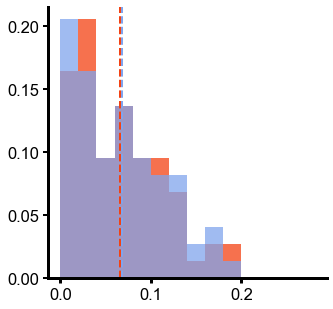

In [73]:
fig, ax = plt.subplots(figsize=(5,5))
hbins = .02
count,edges = np.histogram(xvals,bins=np.arange(0,.3,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Mul),color=mod_clrs[2],width=hbins, alpha=.75)
ax.axvline(x=np.nanmean(xvals),c=mod_clrs[2],ls='--',lw=2)

count,edges = np.histogram(yvals,bins=np.arange(0,.3,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Mul),color=mod_clrs[3],width=hbins, alpha=.75)
ax.axvline(x=np.nanmean(yvals),c=mod_clrs[3],ls='--',lw=2)

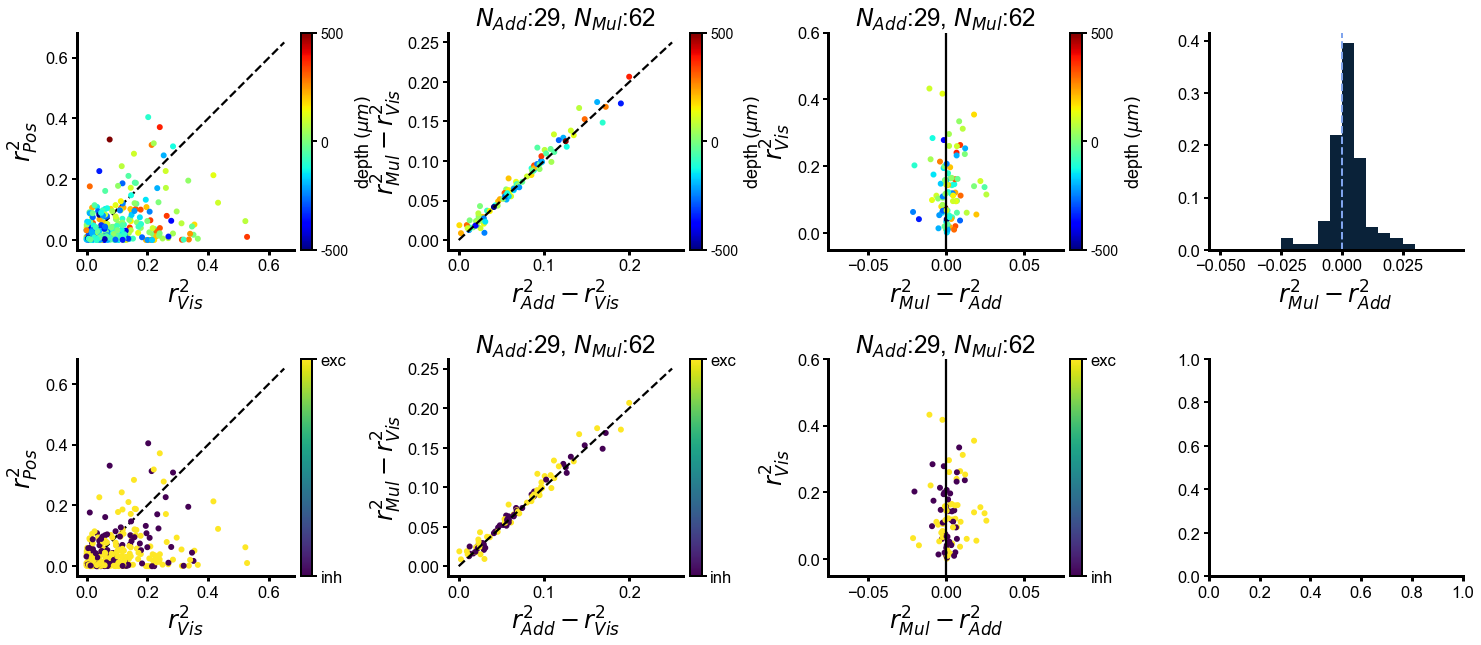

In [150]:
fig = plt.figure(constrained_layout=False, figsize=(25,10))
gs0 = gridspec.GridSpec(ncols=4, nrows=2, figure=fig,wspace=.5,hspace=.5)
########## Fig 4c ########## 
fr_th = 1 # hz
vals_Mot = np.hstack([All_data[date_ani2[da]]['Mot_r2_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['Vis_r2_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['Add_r2_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['Mul_r2_test'] for da in range(len(dates_all))])

axs3a = np.array([fig.add_subplot(gs0[n,m]) for n in range(2) for m in range(4)]).reshape(2,4)

tuning_idx = np.where(tuning_sig_all)[0]
lims = (0, .65)
crange=500
##### Vis vs Mot #####
ax = axs3a[0,0]
im=ax.scatter(vals_Vis,vals_Mot,c=celltypes_all[1],cmap='jet',s=20,vmin=-crange,vmax=crange)
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel(r'$r^2_{Vis}$',fontsize=fontsize)
ax.set_ylabel(r'$r^2_{Pos}$',fontsize=fontsize)
ax.set_yticks(np.arange(0,lims[1],.2))
ax.set_yticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
ax.set_ylim(0,lims[1])
ax.set_xlim(0,lims[1])
ax.set_xticks(np.arange(0,lims[1],.2))
ax.set_xticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
ax.axis('square')
cbar = add_colorbar(im)
cbar.set_ticks([-crange,0,crange])
cbar.set_ticklabels([-crange,0,crange])
cbar.ax.tick_params(labelsize=fontsize-10)
cbar.set_label(r'depth $(\mu m)$')


##### R2 Explained Variance #####
vals_Mot = np.hstack([All_data[date_ani2[da]]['Mot_r2_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['Vis_r2_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['Add_r2_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['Mul_r2_test'] for da in range(len(dates_all))])
move_r2_th = (vals_Mot>.05) & ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) # (vals_Mot>.05) & (vals_Vis>.05) &
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
celltypes_all2 = celltypes_all[:,move_r2_th]
xvals = vals_Add - vals_Vis
yvals = vals_Mul - vals_Vis
# diff = vals_Mul-vals_Add
# increase = vals_Vis
# th = increase>0

NMul = np.sum(xvals<yvals)
NAdd = np.sum(xvals>yvals)
ax=axs3a[0,1]
im = ax.scatter(xvals,yvals,c=celltypes_all2[1],cmap='jet',s=20,vmin=-500,vmax=500)
ax.plot(np.linspace(0,.25,100),np.linspace(0,.25,100),'k--')
# ax.axvline(x=0,c='k')
ax.set_ylabel(r'$r^2_{Mul}-r^2_{Vis}$',fontsize=fontsize)
ax.set_xlabel(r'$r^2_{Add}-r^2_{Vis}$',fontsize=fontsize)
ax.set_title(r'$N_{{Add}}$:{}, $N_{{Mul}}$:{}'.format(NAdd,NMul),fontsize=fontsize)
# ax.set_ylim(-.05,.6)
# ax.set_xlim(0,.1)
cbar = add_colorbar(im)
cbar.set_ticks([-crange,0,crange])
cbar.set_ticklabels([-crange,0,crange])
cbar.ax.tick_params(labelsize=fontsize-10)
cbar.set_label(r'depth $(\mu m)$')


##### R2 Explained Variance #####
vals_Mot = np.hstack([All_data[date_ani2[da]]['Mot_r2_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['Vis_r2_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['Add_r2_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['Mul_r2_test'] for da in range(len(dates_all))])
move_r2_th = (vals_Mot>.05) & ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) # (vals_Mot>.05) & (vals_Vis>.05) &
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
celltypes_all2 = celltypes_all[:,move_r2_th]
diff = vals_Mul-vals_Add
increase = vals_Vis
th = increase>0

NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)
ax=axs3a[0,2]
im = ax.scatter(diff[th],increase[th],c=celltypes_all2[1,th],cmap='jet',s=20,vmin=-500,vmax=500)
ax.axvline(x=0,c='k')
ax.set_ylabel(r'$r^2_{Vis}$',fontsize=fontsize)
ax.set_xlabel(r'$r^2_{Mul}-r^2_{Add}$',fontsize=fontsize)
ax.set_title(r'$N_{{Add}}$:{}, $N_{{Mul}}$:{}'.format(NAdd,NMul),fontsize=fontsize)
ax.set_ylim(-.05,.6)
ax.set_xlim(-.075,.075)
cbar = add_colorbar(im)
cbar.set_ticks([-crange,0,crange])
cbar.set_ticklabels([-crange,0,crange])
cbar.ax.tick_params(labelsize=fontsize-10)
cbar.set_label(r'depth $(\mu m)$')


vals_Mot = np.hstack([All_data[date_ani2[da]]['Mot_r2_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['Vis_r2_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['Add_r2_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['Mul_r2_test'] for da in range(len(dates_all))])
move_r2_th = (vals_Mot>.05) & ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) # (vals_Mot>.05) & (vals_Vis>.05) &
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
celltypes_all2 = celltypes_all[:,move_r2_th]
ax=axs3a[0,3]
hbins=.005
count,edges = np.histogram(vals_Mul-vals_Add,bins=np.arange(-.05,.05,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(vals_Mul),color='#0A2239',width=hbins, alpha=1)
ax.axvline(x=0,c=mod_clrs[3],ls='--',lw=2)
# ax.set_xticks(np.arange(0,1.2,.2))
# ax.set_xticklabels(np.round(np.arange(0,1.2,.2),decimals=1))
# ax.set_title(mod_titles[n])
ax.set_xlabel(r'$r^2_{Mul}-r^2_{Add}$',fontsize=fontsize)



##############################################################################
vals_Mot = np.hstack([All_data[date_ani2[da]]['Mot_r2_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['Vis_r2_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['Add_r2_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['Mul_r2_test'] for da in range(len(dates_all))])

tuning_idx = np.where(tuning_sig_all)[0]
lims = (0, .65)
crange=500
##### Vis vs Mot #####
ax = axs3a[1,0]
im=ax.scatter(vals_Vis,vals_Mot,c=celltypes_all[0],s=20)
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel(r'$r^2_{Vis}$',fontsize=fontsize)
ax.set_ylabel(r'$r^2_{Pos}$',fontsize=fontsize)
ax.set_yticks(np.arange(0,lims[1],.2))
ax.set_yticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
ax.set_ylim(0,lims[1])
ax.set_xlim(0,lims[1])
ax.set_xticks(np.arange(0,lims[1],.2))
ax.set_xticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
ax.axis('square')
cbar = add_colorbar(im)
cbar.set_ticks([0,1])
cbar.set_ticklabels(['inh','exc'])


##### R2 Explained Variance #####
vals_Mot = np.hstack([All_data[date_ani2[da]]['Mot_r2_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['Vis_r2_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['Add_r2_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['Mul_r2_test'] for da in range(len(dates_all))])
move_r2_th = (vals_Mot>.05) & ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) # (vals_Mot>.05) & (vals_Vis>.05) &
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
celltypes_all2 = celltypes_all[:,move_r2_th]
xvals = vals_Add - vals_Vis
yvals = vals_Mul - vals_Vis
# diff = vals_Mul-vals_Add
# increase = vals_Vis
# th = increase>0

NMul = np.sum(xvals<yvals)
NAdd = np.sum(xvals>yvals)
ax=axs3a[1,1]
im = ax.scatter(xvals,yvals,c=celltypes_all2[0],s=20)
ax.plot(np.linspace(0,.25,100),np.linspace(0,.25,100),'k--')
# ax.axvline(x=0,c='k')
ax.set_ylabel(r'$r^2_{Mul}-r^2_{Vis}$',fontsize=fontsize)
ax.set_xlabel(r'$r^2_{Add}-r^2_{Vis}$',fontsize=fontsize)
ax.set_title(r'$N_{{Add}}$:{}, $N_{{Mul}}$:{}'.format(NAdd,NMul),fontsize=fontsize)
# ax.set_ylim(-.05,.6)
# ax.set_xlim(0,.1)
cbar = add_colorbar(im)
cbar.set_ticks([0,1])
cbar.set_ticklabels(['inh','exc'])
# cbar.ax.tick_params(labelsize=fontsize-10)
# cbar.set_label(r'depth $(\mu m)$')



##### R2 Explained Variance #####
vals_Mot = np.hstack([All_data[date_ani2[da]]['Mot_r2_test'] for da in range(len(dates_all))])
vals_Vis = np.hstack([All_data[date_ani2[da]]['Vis_r2_test'] for da in range(len(dates_all))])
vals_Add = np.hstack([All_data[date_ani2[da]]['Add_r2_test'] for da in range(len(dates_all))])
vals_Mul = np.hstack([All_data[date_ani2[da]]['Mul_r2_test'] for da in range(len(dates_all))])
move_r2_th = (vals_Mot>.05) & ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) # (vals_Mot>.05) & (vals_Vis>.05) &
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
celltypes_all2 = celltypes_all[:,move_r2_th]
diff = vals_Mul-vals_Add
increase = vals_Vis
th = increase>0

NMul = np.sum(diff[th]>0)
NAdd = np.sum(diff[th]<0)
ax=axs3a[1,2]
im = ax.scatter(diff[th],increase[th],c=celltypes_all2[0,th],s=20)
ax.axvline(x=0,c='k')
ax.set_ylabel(r'$r^2_{Vis}$',fontsize=fontsize)
ax.set_xlabel(r'$r^2_{Mul}-r^2_{Add}$',fontsize=fontsize)
ax.set_title(r'$N_{{Add}}$:{}, $N_{{Mul}}$:{}'.format(NAdd,NMul),fontsize=fontsize)
ax.set_ylim(-.05,.6)
ax.set_xlim(-.075,.075)
cbar = add_colorbar(im)
cbar.set_ticks([0,1])
cbar.set_ticklabels(['inh','exc'])


fig.savefig(paper_fig_dir/'Scatter_comparision.png', facecolor='white', transparent=True, bbox_inches='tight')


In [234]:
(vals_Mul-vals_Add).shape

(73,)

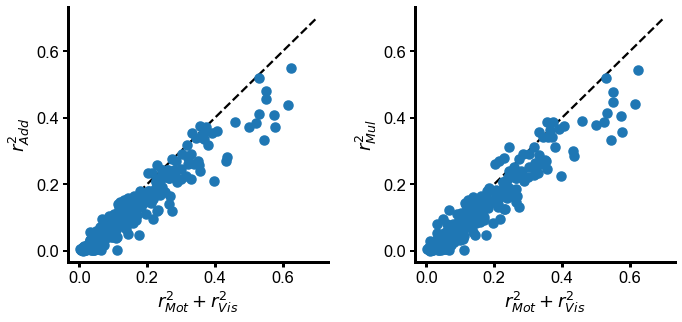

In [194]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
ax=axs[0]
ax.scatter(vals_Mot+vals_Vis,vals_Add)
ax.plot(np.linspace(0,.7),np.linspace(0,.7),'k--',zorder=0)
ax.set_xlabel(r'$r^2_{Mot}+r^2_{Vis}$')
ax.set_ylabel(r'$r^2_{Add}$')
ax=axs[1]
ax.scatter(vals_Mot+vals_Vis,vals_Mul)
ax.plot(np.linspace(0,.7),np.linspace(0,.7),'k--',zorder=0)
ax.set_xlabel(r'$r^2_{Mot}+r^2_{Vis}$')
ax.set_ylabel(r'$r^2_{Mul}$')
plt.tight_layout()
# fig.savefig(paper_fig_dir/'SumR2_Vs_Joint.png', facecolor='white', transparent=True, bbox_inches='tight')

## Supplementary Figures

### SFig for Fig 2

#### Shifter Matricies

/tmp/ipykernel_402327/4208914022.py:6: RuntimeWarning: Mean of empty slice
  best_shifter = np.nanargmin(np.nanmean(GLM_CV['loss_regcv'][0,:],axis=-1))


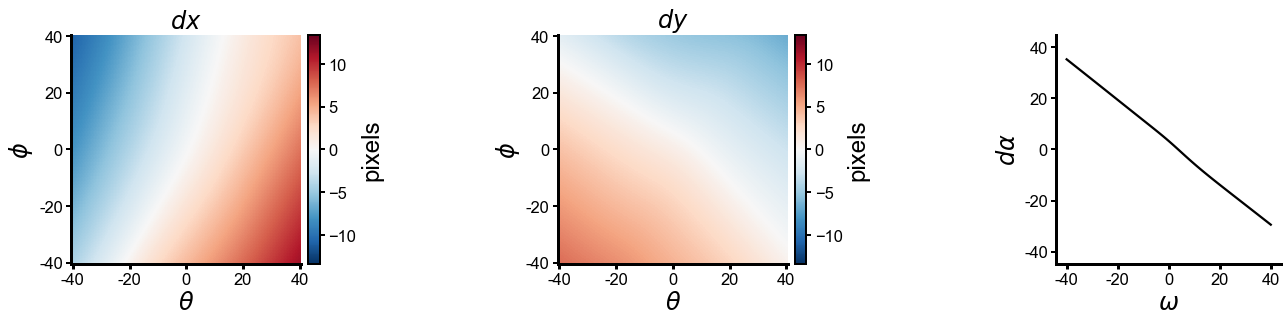

In [31]:
save_dir_fm = params['save_dir_fm'] /'GLM_Network/MovModel1/version_0'

save_datafile = save_dir_fm/'GLM_Pytorch_VisShifter_NoL1_dt050_T01_MovModel1_NB5000_Kfold00.h5'
GLM_CV = ioh5.load(save_datafile)

best_shifter = np.nanargmin(np.nanmean(GLM_CV['loss_regcv'][0,:],axis=-1))

##### Load single shifter network and shift videos #####
reg_alph=a=0; l=best_shifter
Kfold=0
shift_in=3
shift_hidden=20
shift_out=3
save_model_fm =params['save_dir'] / 'models/Shifter'

shifter_nn = nn.Sequential(
                nn.Linear(shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out))#.to(device)
model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format('Pytorch_VisShifter_NoL1','UC',int(.05*1000), 1, MovModel, 5000,a,l,Kfold)
# model_name = 'GLMShifter_WCUC_dt050_T01_MovModel1_NB5000_alph0_lam7.pth'
checkpoint = torch.load(save_model_fm/model_name)
pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
shifter_nn.load_state_dict(pretrained_dict)

FM_move_avg = np.load(params['save_dir_fm']/'FM_MovAvg_dt{:03d}.npy'.format(int(params['model_dt']*1000)))
th_range = 40/FM_move_avg[1,0]
phi_range = 40/FM_move_avg[1,1]
pitch_range = 40/FM_move_avg[1,2]
ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.linspace(-th_range,th_range,81),np.linspace(-phi_range,phi_range,81),np.linspace(-pitch_range,pitch_range,81),sparse=False,indexing='ij')
# ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.arange(-40,40),np.arange(-40,40),np.arange(-40,40),sparse=False,indexing='ij')

shift_mat = np.zeros((3,) + ang_sweepx.shape)
for i in range(ang_sweepx.shape[0]):
    for j in range(ang_sweepy.shape[1]):
        ang_sweep = torch.from_numpy(np.vstack((ang_sweepx[i,j,:],ang_sweepy[i,j,:],ang_sweepz[i,j,:])).astype(np.float32).T)
        shift_vec = shifter_nn(ang_sweep).detach().cpu().numpy()
        shift_mat[0,i,j] = shift_vec[:,0] #np.clip(shift_vec[:,0],a_min=-15,a_max=15)
        shift_mat[1,i,j] = shift_vec[:,1] #np.clip(shift_vec[:,1],a_min=-15,a_max=15)
        shift_mat[2,i,j] = shift_vec[:,2] #np.clip(shift_vec[:,2],a_min=-30,a_max=30)

    
fig, axs = plt.subplots(1,3,figsize=(20,5))
shift_titles = [r'$dx$',r'$dy$',r'$d\alpha,\phi=0$',r'$d\alpha,\theta=0$']
cbar_label = ['pixels','pixels','deg','deg']
ticks=np.arange(0,90,20)
ticklabels=np.arange(-40,50,20)
shift_matshow=np.stack((shift_mat[0,:,:,40].T,shift_mat[1,:,:,40].T,shift_mat[2,:,40,:].T,shift_mat[2,40,:,:].T))
crange_list = np.stack((np.max(np.abs(shift_mat[:2])),np.max(np.abs(shift_mat[:2])), np.max(np.abs(shift_mat[2])), np.max(np.abs(shift_mat[2]))))
for n in range(2):
    ax = axs[n]
    im1=ax.imshow(shift_matshow[n],vmin=-crange_list[n], vmax=crange_list[n], origin='lower', cmap='RdBu_r')
    cbar1 = add_colorbar(im1)
    cbar1.set_label(cbar_label[n],fontsize=fontsize)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels)
    ax.set_xlabel(r'$\theta$',fontsize=fontsize)
    ax.set_ylabel(r'$\phi$',fontsize=fontsize)
    ax.set_title(shift_titles[n],fontsize=fontsize)
ax = axs[2]
ax.plot(FM_move_avg[1, 2]*np.linspace(-pitch_range,pitch_range,81), shift_mat[2, 40, 40, :], 'k')
ax.set_xlabel(r'$\omega$',fontsize=fontsize)
ax.set_ylabel(r'$d\alpha$',fontsize=fontsize)
ax.set_xticks(ticklabels)
ax.set_xticklabels(ticklabels)
ax.set_yticks([-40,-20,0,20,40])
ax.set_yticklabels([-40, -20, 0, 20, 40])
ax.axis('square')
ax.set_ylim(-45, 45)


plt.tight_layout()


#### SimRF 

In [32]:
SimRF_file = params['save_dir'].parent.parent.parent/'121521/SimRF/fm1/SimRF_{}_dt{:03d}_T{:02d}_Model1_NB{}_Kfold{:02d}_best.h5'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
SimRF_GLM_file = '/home/seuss/Research/SensoryMotorPred_Data/data/121521/SimRF/fm1/GLM_Network/MovModel1/version_0/SimRF/GLM_Pytorch_Vis_withL1_SimRF_dt050_T01_MovModel1_NB10000_Kfold00_best.h5'
GLM_Data = ioh5.load(SimRF_GLM_file)
SimRF_data = ioh5.load(SimRF_file)
RF_Sim = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0], params['nt_glm_lag'],)+(30,40))
Sim_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
Sim_act_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=SimRF_data['yte'].copy())[params['bin_length']:-params['bin_length']].T
Sim_r2 = np.array([(np.corrcoef(Sim_smooth[:,celln],Sim_act_smooth[celln])[0, 1])**2 for celln in range(Sim_act_smooth.shape[0])])


Text(0, 0.5, 'sp/sec')

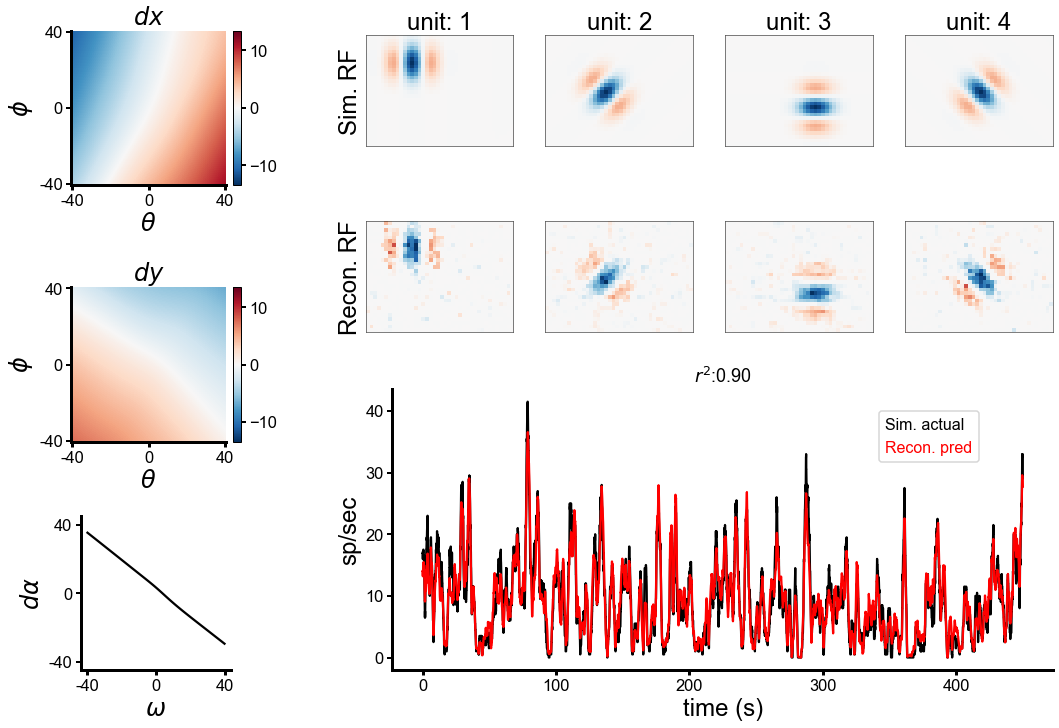

In [136]:
fig1 = plt.figure(constrained_layout=True, figsize=(15,10))
gs0 = fig1.add_gridspec(nrows=2, ncols=3, wspace=.6, hspace=.2)

gs01 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[:,0],wspace=1,hspace=.1)
axs1 = np.array([fig1.add_subplot(gs01[n,m]) for n in range(3) for m in range(1)]).reshape(3)

shift_titles = [r'$dx$',r'$dy$',r'$d\alpha,\phi=0$',r'$d\alpha,\theta=0$']
cbar_label = ['pixels','pixels','deg','deg']
ticks=np.arange(0,90,40)
ticklabels=np.arange(-40,50,40)
shift_matshow=np.stack((shift_mat[0,:,:,40].T,shift_mat[1,:,:,40].T,shift_mat[2,:,40,:].T,shift_mat[2,40,:,:].T))
crange_list = np.stack((np.max(np.abs(shift_mat[:2])),np.max(np.abs(shift_mat[:2])), np.max(np.abs(shift_mat[2])), np.max(np.abs(shift_mat[2]))))
for n in range(2):
    ax = axs1[n]
    im1=ax.imshow(shift_matshow[n],vmin=-crange_list[n], vmax=crange_list[n], origin='lower', cmap='RdBu_r')
    cbar1 = add_colorbar(im1)
    cbar1.outline.set_linewidth(1)
    # cbar1.set_label(cbar_label[n],fontsize=fontsize)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticklabels)
    ax.set_xlabel(r'$\theta$',fontsize=fontsize)
    ax.set_ylabel(r'$\phi$',fontsize=fontsize)
    ax.set_title(shift_titles[n],fontsize=fontsize)
ax = axs1[2]
ax.plot(FM_move_avg[1, 2]*np.linspace(-pitch_range,pitch_range,81), shift_mat[2, 40, 40, :], 'k')
ax.set_xlabel(r'$\omega$',fontsize=fontsize)
ax.set_ylabel(r'$d\alpha$',fontsize=fontsize)
ax.set_xticks(ticklabels)
ax.set_xticklabels(ticklabels)
ax.set_yticks([-40,0,40])
ax.set_yticklabels([-40,0,40])
ax.axis('square')
ax.set_ylim(-45, 45)


cells = [0,25,62,43]
gs02 = gridspec.GridSpecFromSubplotSpec(2, len(cells), subplot_spec=gs0[:1,1:],wspace=.1,hspace=.05)
axs2 = np.array([fig1.add_subplot(gs02[n,m]) for n in range(2) for m in range(len(cells))]).reshape(2,len(cells))
for n, cell in enumerate(cells):
    ax = axs2[0,n]
    crange2 = np.max(np.abs(SimRF_data['RF_actual'][cell]))
    im2 = ax.imshow(SimRF_data['RF_actual'][cell],'RdBu_r', vmin=-crange2, vmax=crange2)
    ax = axs2[1,n]
    crange1 = np.max(np.abs(RF_Sim[cell]))
    im2 = ax.imshow(RF_Sim[cell,0],'RdBu_r', vmin=-crange1, vmax=crange1)


    # crange2 = np.max(np.abs(RF_all[0,cell,2,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)]))
    # im2 = axs1[0,n].imshow(RF_all[0,cell, 2,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)],'RdBu_r', vmin=-crange2, vmax=crange2)
    # crange1 = np.max(np.abs(RF_all[1,cell,2,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)]))
    # im1 = axs1[1,n].imshow(RF_all[1,cell, 2,int(sf*xcut1):int(sf*xcut2),int(sf*ycut1):int(sf*ycut2)], 'RdBu_r', vmin=-crange1, vmax=crange1)
    axs2[0,n].set_title('unit: {}'.format(n+1), fontsize=fontsize)

axs2[1,0].set_ylabel('Recon. RF', fontsize=fontsize)
axs2[0,0].set_ylabel('Sim. RF', fontsize=fontsize)
for ax in axs2.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])   
# cbar2 = fig1.colorbar(im1, ax=axs1.ravel().tolist())
# cbar2.set_ticks([-crange1, crange1])
# cbar2.set_ticklabels(['Dark', 'Light'])
# cbar2.ax.tick_params(labelsize=fontsize)


gs03 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1,1:],wspace=.1,hspace=.1)
axs3 = np.array([fig1.add_subplot(gs03[0,:])])

cell = 62
ax = axs3[0]
pred_time = (np.arange(Sim_act_smooth.shape[1])*params['model_dt'])
ax.plot(pred_time,Sim_act_smooth[cell],c='k', label='Sim. actual')
ax.plot(pred_time,Sim_smooth[:,cell],c='r', label='Recon. pred')
ax.legend(labelcolor='linecolor', fontsize=16, handlelength=0, handletextpad=0,loc='upper right',ncol=1, bbox_to_anchor=(.9, .95))
ax.set_title('$r^2$:{:.02f}'.format(Sim_r2[cell]))
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)

In [ ]:
#Histogram 
# Simulated shifter network data. 

## Other Plots

### Comparison of all Plots

In [96]:
celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
celltype = pickle.load(open(celltype_file,'rb'))

Kfold = 0
args['free_move']=True
mod_titles = ['Mot','Vis','Add','Mul','HF']
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' 
ModelList_all,test_std,tuning_sig_all,tuning_sig_all2,NCells_all,bad_cells_all,test_nsp_all,hf_nsp_all = [],[], [], [], [], [], [], []
for d,date_ani in enumerate(dates_all):
    args['free_move'] = True
    args['date_ani'] = date_ani
    args['NoL1']=False
    args['Nepochs'] = 10000
    params,_,_ = load_params(1,Kfold,args,debug=True)
    params['nt_glm_lag'] = 5
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    if args['NoL1'] == True: 
        L1 = 'NoL1'
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    else: 
        L1 = 'withL1'
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted(list(set(date_ani_dir.rglob(mod_name+'.h5')) - set(date_ani_dir.rglob('*VisNoShifter'+mod_name+'.h5')))))
    ModelList_all.append(ModelList)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    test_nsp_all.append(data['test_nsp'])
    test_std.append(np.var(data['test_nsp'],axis=0))
    tuning_sig_all.append(tuning_sig)
    tuning_sig_all2.append(tuning_sig2)
    NCells_all.append(len(tuning_sig2))
    args['free_move'] = False
    params,_,_ = load_params(0,Kfold,args,debug=True)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    hf_nsp_all.append(data['test_nsp'])

ModelList_all = np.stack(ModelList_all)
test_std=np.hstack(test_std)
tuning_sig_all2 = np.hstack(tuning_sig_all2)
tuning_sig_all = np.vstack(tuning_sig_all)



Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/format_data.py:664: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/format_data.py:664: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/format_data.py:664: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


Done Loading Unaligned data
Done Loading Unaligned data


/home/seuss/Research/MyRepos/NonLinearMixedSel_FreelyMoving/format_data.py:664: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


In [99]:
sf=4
params['nt_glm_lag']=5
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
All_data = {date_ani2[n]:{} for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    All_data[date_ani]['actual_meanfr'] = np.mean(test_nsp_all[da],axis=0)/params['model_dt']
    All_data[date_ani]['actual_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_nsp_all[da])[params['bin_length']:-params['bin_length']]
    All_data[date_ani]['actual_HF_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=hf_nsp_all[da])[params['bin_length']:-params['bin_length']]
    for ModelRun,fmod in enumerate(ModelList_all[da]):
        GLM_Data = ioh5.load(fmod)
        All_data[date_ani][mod_titles[ModelRun]+'_pred_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
        All_data[date_ani][mod_titles[ModelRun]+'_r2_test'] = GLM_Data['r2_test'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_all'] = GLM_Data['vloss_trace_all'].copy()
        All_data[date_ani][mod_titles[ModelRun]+'_vloss_trace'] = np.nanmean(GLM_Data['vloss_trace_all'][:,-10:],axis=1)/np.nanvar(test_nsp_all[da],axis=0)
        if (ModelRun == 1) | (ModelRun == 4):
            All_data[date_ani][mod_titles[ModelRun]+'_loss_regcv'] = GLM_Data['loss_regcv'].copy()
            RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
            RF_all_up = np.zeros((RF_all.shape[:2] + ( sf*(RF_all.shape[-2]), sf*(RF_all.shape[-1]))))
            for celln in range(RF_all.shape[0]):
                for t in range(RF_all.shape[1]):
                    RF_all_up[celln,t] = cv2.resize(RF_all[celln,t], (sf*(RF_all.shape[-1]), sf*(RF_all.shape[-2])))
            All_data[date_ani][mod_titles[ModelRun]+'_rf_up'] = RF_all_up
            All_data[date_ani][mod_titles[ModelRun]+'_rf_all'] = RF_all
        if (ModelRun == 2) | (ModelRun==3):
            All_data[date_ani][mod_titles[ModelRun]+'_moveW'] = GLM_Data['posNN.Layer0.weight'].copy()
        if (ModelRun == 4):
            r2_FMHF_RF = np.zeros(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0])
            for celln in np.arange(All_data[date_ani][mod_titles[1]+'_rf_all'].shape[0]):
                r2_FMHF_RF[celln] = np.corrcoef(All_data[date_ani][mod_titles[1]+'_rf_all'][celln,2].flatten(),All_data[date_ani][mod_titles[-1]+'_rf_all'][celln,2].flatten())[0,1]
            All_data[date_ani][mod_titles[ModelRun]+'_FMHF_r2'] = r2_FMHF_RF

celltypes_all = []
for n,date_exp in enumerate([2,4,7,9]):
    celltype2 = celltype[celltype['session']==celltype['session'].unique()[date_exp]].reset_index(drop=True)
    celltype2 = celltype2.drop(bad_cells_all[n])
    celltypes_all.append([celltype2['exc_or_inh'] == 'exc',celltype2['hf1_wn_depth_from_layer5']])
celltypes_all = np.hstack(celltypes_all)


In [159]:
save_pdf = True
anglim = 65
fontsize=24
titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$']
quartiles = np.arange(0,1.25,.25)
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
paper_fig_dir = (params['fig_dir'].parent.parent.parent / 'PaperFigs')
paper_fig_dir.mkdir(parents=True, exist_ok=True)
pdf_name = paper_fig_dir/ ('MoViAdMuHF_AllCells_CellSummary.pdf')
totcelln = 0
if save_pdf:
    pdf = PdfPages(pdf_name)
    fig = plt.figure(constrained_layout=False, figsize=(30,10))
    gs0 = gridspec.GridSpec(nrows=2, ncols=5, figure=fig,wspace=.8,hspace=.3)

    ########## Histograms of R2 ##########
    axs0a = np.array([fig.add_subplot(gs0[0, n]) for n in range(gs0.ncols)])
    axs0b = np.array([fig.add_subplot(gs0[1, n]) for n in range(gs0.ncols)])

    vals_Mot = np.hstack([All_data[date_ani2[da]]['Mot_r2_test'] for da in range(len(dates_all))])
    vals_Vis = np.hstack([All_data[date_ani2[da]]['Vis_r2_test'] for da in range(len(dates_all))])
    vals_Add = np.hstack([All_data[date_ani2[da]]['Add_r2_test'] for da in range(len(dates_all))])
    vals_Mul = np.hstack([All_data[date_ani2[da]]['Mul_r2_test'] for da in range(len(dates_all))])
    vals_HF  = np.hstack([All_data[date_ani2[da]]['HF_r2_test'] for da in range(len(dates_all))])
    vals_FMHF  = np.hstack([All_data[date_ani2[da]]['HF_FMHF_r2']  for da in range(len(dates_all))])

    r2_all = np.stack((vals_Mot,vals_Vis,vals_Add,vals_Mul,vals_HF))
    hbins=.05
    for n in range(len(mod_titles)):
        ax = axs0a[n]
        count,edges = np.histogram(r2_all[n],bins=np.arange(0,1,hbins))
        edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        ax.bar(edges_mid, count/len(r2_all[n]),color=mod_clrs[n],width=hbins, alpha=1)
        ax.set_xticks(np.arange(0,1.2,.2))
        ax.set_xticklabels(np.round(np.arange(0,1.2,.2),decimals=1))
        ax.set_title(mod_titles[n])
        ax.set_xlabel(r'$r^2$')

    ax=axs0b[-1]
    count,edges = np.histogram(np.abs(vals_FMHF),bins=np.arange(0,1,hbins))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(r2_all[n]),color=mod_clrs[n],width=hbins, alpha=1)
    ax.set_xticks(np.arange(0,1.2,.2))
    ax.set_xticklabels(np.round(np.arange(0,1.2,.2),decimals=1))
    ax.set_title('FM_HF_CC')
    ax.set_xlabel('cc')
    ########## Scatter of all R2 ########## 

    tuning_idx = np.where(tuning_sig_all)[0]
    lims = (0, .65)
    crange=500
    ##### Vis vs Mot #####
    ax = axs0b[0]
    im=ax.scatter(vals_Vis,vals_Mot,c=celltypes_all[1],cmap='jet',s=20,vmin=-crange,vmax=crange)
    ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
    ax.set_ylabel('Position: $r^2$',fontsize=fontsize)
    ax.set_yticks(np.arange(0,lims[1],.2))
    ax.set_yticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
    ax.set_ylim(0,lims[1])
    ax.set_xlim(0,lims[1])
    ax.set_xticks(np.arange(0,lims[1],.2))
    ax.set_xticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
    ax.axis('equal')
    cbar = add_colorbar(im)
    cbar.set_ticks([-crange,0,crange])
    cbar.set_ticklabels([-crange,0,crange])
    cbar.ax.tick_params(labelsize=fontsize-10)
    cbar.set_label(r'depth $(\mu m)$')

    ##### Vis vs Add/Mul #####
    cmap_mod = mpl.colors.ListedColormap(mod_clrs[2:4])
    vals_AM = np.max(np.stack((vals_Add,vals_Mul)),axis=0)
    AvM = vals_Add<vals_Mul
    ax = axs0b[1]
    scatter=ax.scatter(vals_Vis,vals_AM,30,c=AvM,cmap=cmap_mod)
    ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    ax.set_xlabel('Visual: $r^2$',fontsize=fontsize)
    ax.set_ylabel('$r^2$',fontsize=fontsize)
    ax.set_yticks(np.arange(0,lims[1],.2))
    ax.set_yticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
    ax.set_ylim(0,lims[1])
    ax.set_xlim(0,lims[1])
    ax.set_xticks(np.arange(0,lims[1],.2))
    ax.set_xticklabels(np.round(np.arange(0,lims[1],.2),decimals=1))
    ax.axis('equal')
    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),fontsize=14,markerscale=0, handlelength=0, handletextpad=0,loc="best")
    legend1.get_texts()[0].set_text('Add') 
    legend1.get_texts()[0].set_color(mod_clrs[2])
    legend1.get_texts()[1].set_text('Mul')
    legend1.get_texts()[1].set_color(mod_clrs[3])

    vloss_Mot = np.hstack([All_data[date_ani2[da]]['Mot_vloss_trace'] for da in range(len(dates_all))])
    vloss_Vis = np.hstack([All_data[date_ani2[da]]['Vis_vloss_trace'] for da in range(len(dates_all))])
    vloss_Add = np.hstack([All_data[date_ani2[da]]['Add_vloss_trace'] for da in range(len(dates_all))])
    vloss_Mul = np.hstack([All_data[date_ani2[da]]['Mul_vloss_trace'] for da in range(len(dates_all))])

    ##### MSE #####
    diff = vloss_Add-vloss_Mul
    increase = 1-vloss_Vis
    th = increase>-0

    NMul = np.sum(diff[th]>0)
    NAdd = np.sum(diff[th]<0)
    ax=axs0b[2]
    im=ax.scatter(diff[th],increase[th],c=celltypes_all[1,th],cmap='jet',s=20,vmin=-500,vmax=500)
    ax.axvline(x=0,c='k')
    ax.set_ylabel(r'$1-(MSE_{Vis}/Var)$',fontsize=fontsize)
    ax.set_xlabel('MSE: Add-Mul',fontsize=fontsize)
    ax.set_title(r'$N_{{Add}}$:{}, $N_{{Mul}}$:{}'.format(NAdd,NMul),fontsize=fontsize)
    ax.set_ylim(-.05,.25)
    ax.set_xlim(-.02,.02)
    cbar = add_colorbar(im)
    cbar.set_ticks([-crange,0,crange])
    cbar.set_ticklabels([-crange,0,crange])
    cbar.ax.tick_params(labelsize=fontsize-10)
    cbar.set_label(r'depth $(\mu m)$')

    ##### R2 Explained Variance #####
    diff = vals_Mul-vals_Add
    increase = 1-vloss_Vis
    th = increase>-0

    NMul = np.sum(diff[th]>0)
    NAdd = np.sum(diff[th]<0)
    ax=axs0b[3]
    im = ax.scatter(diff[th],increase[th],c=celltypes_all[1,th],cmap='jet',s=20,vmin=-500,vmax=500)
    ax.axvline(x=0,c='k')
    ax.set_ylabel(r'$1-(MSE_{Vis}/Var)$',fontsize=fontsize)
    ax.set_xlabel('R2: Mul-Add',fontsize=fontsize)
    ax.set_title(r'$N_{{Add}}$:{}, $N_{{Mul}}$:{}'.format(NAdd,NMul),fontsize=fontsize)
    ax.set_ylim(-.05,.25)
    ax.set_xlim(-.075,.075)
    cbar = add_colorbar(im)
    cbar.set_ticks([-crange,0,crange])
    cbar.set_ticklabels([-crange,0,crange])
    cbar.ax.tick_params(labelsize=fontsize-10)
    cbar.set_label(r'depth $(\mu m)$')

    plt.tight_layout()
    pdf.savefig()
    plt.close()
for da in tqdm(np.arange(len(date_ani2))):
    args['date_ani'] = dates_all[da]
    args['free_move'] = True
    params,_,_ = load_params(0,Kfold,args,debug=True)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    ncells=All_data[date_ani2[da]][mod_titles[0]+'_pred_smooth'].shape[-1]
    for celln in tqdm(np.arange(ncells)):
        predcell = All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'][:,celln]#/params['model_dt']
        nspcell = All_data[date_ani2[da]]['actual_smooth'][:,celln]#/params['model_dt']
        pred_range = np.quantile(predcell,[.1,.9])
        test_nsp_range = np.quantile(nspcell,[.01,1])
        pred_rangelin = np.quantile(predcell,spike_percentiles)
        xbin_pts = np.quantile(predcell,spk_percentile2)
        stat_bins = len(pred_rangelin)
        fig = plt.figure(constrained_layout=False, figsize=(30,25))
        gs0 = gridspec.GridSpec(nrows=3, ncols=4, figure=fig,wspace=.5,hspace=.3)

        ########## Plotting FM/HF RFs ##########
        gs00a = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs0[:1,:4],wspace=.5,hspace=.5)
        axs0a = np.array([fig.add_subplot(gs00a[0, n]) for n in range(gs00a.ncols)])
        axs0b = np.array([fig.add_subplot(gs00a[1, n]) for n in range(gs00a.ncols)])

        ax = axs0a[0]
        crange = np.max(np.abs(All_data[date_ani2[da]]['Vis_rf_up'][celln]))
        im = ax.imshow(All_data[date_ani2[da]]['Vis_rf_up'][celln,0],'RdBu_r',vmin=-crange,vmax=crange)
        cbar = add_colorbar(im)
        ax.axis('off')
        ax.set_title('FM RF')

        ax = axs0a[1]
        ax.plot(All_data[date_ani2[da]]['actual_smooth'][:,celln])
        ax.plot(All_data[date_ani2[da]]['Vis_pred_smooth'][:,celln])
        # ax.set_title('$r^2$: {:.03f}'.format(r2_FM[celln]))

        ax = axs0a[2]
        ax.plot(All_data[date_ani2[da]]['Vis_loss_regcv'][0,:,celln])
        ax.set_ylabel('MSE')
        ax.set_xlabel(r'$\lambda_n$')
        ax.set_title('Best lam:{}'.format(np.nanargmin(All_data[date_ani2[da]]['Vis_loss_regcv'][0,:,celln])))

        ax =axs0a[3]
        for modN in range(len(mod_titles)-1):
            ax.plot(All_data[date_ani2[da]][mod_titles[modN]+'_vloss_all'][celln],c=mod_clrs[modN])
        ax.set_ylabel('MSE')
        ax.set_xlabel('batches')

        ########### Head Fixed plots ###########
        ax = axs0b[0]
        crange = np.max(np.abs(All_data[date_ani2[da]]['HF_rf_up'][celln]))
        im = ax.imshow(All_data[date_ani2[da]]['HF_rf_up'][celln,0],'RdBu_r',vmin=-crange,vmax=crange)
        cbar = add_colorbar(im)
        ax.set_title('HF RF')
        ax.axis('off')

        ax = axs0b[1]
        ax.plot(All_data[date_ani2[da]]['actual_HF_smooth'][:,celln])
        ax.plot(All_data[date_ani2[da]]['HF_pred_smooth'][:,celln])
        # ax.set_title('$r^2$: {:.03f}'.format(r2_HF[celln]))

        ax = axs0b[2]
        ax.plot(All_data[date_ani2[da]]['HF_loss_regcv'][0,:,celln])
        ax.set_ylabel('MSE')
        ax.set_xlabel(r'$\lambda_n$')
        ax.set_title('Best lam:{}'.format(np.nanargmin(All_data[date_ani2[da]]['HF_loss_regcv'][0,:,celln])))

        ax =axs0b[3]
        ax.plot(All_data[date_ani2[da]][mod_titles[-1]+'_vloss_all'][celln],c='k')
        ax.set_ylabel('MSE')
        ax.set_xlabel('batches')

        ######### Position Weights ##########

        w_move_Add = All_data[date_ani2[da]][mod_titles[2]+'_moveW']
        w_move_Mov = All_data[date_ani2[da]][mod_titles[3]+'_moveW']
        for modeln in range(len(titles)):
            axs0a[4].bar(modeln, w_move_Add[celln,modeln], color=move_clrs[modeln])
            axs0a[4].set_xticks(np.arange(0,len(titles)))
            axs0a[4].set_xticklabels(titles)
            axs0a[4].set_ylabel('GLM Weight')
            axs0a[4].set_title('Add Weights')

            axs0b[4].bar(modeln, w_move_Mov[celln,modeln], color=move_clrs[modeln])
            axs0b[4].set_xticks(np.arange(0,len(titles)))
            axs0b[4].set_xticklabels(titles)
            axs0b[4].set_ylabel('GLM Weight')
            axs0b[4].set_title('Mul Weights')



        ########## Fig 4A ########## 
        gs00 = gridspec.GridSpecFromSubplotSpec(2, len(titles), subplot_spec=gs0[1,:4],wspace=.5,hspace=.7)
        axs1 = np.array([fig.add_subplot(gs00[n,m]) for n in range(1) for m in range(len(titles))]).reshape(1,len(titles))
        axs1b = np.array([fig.add_subplot(gs00[n,m]) for n in range(1,2) for m in range(len(titles))]).reshape(1,len(titles))

        top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
        traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
        traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
        edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
        for i,modeln in enumerate(range(len(titles))):
            metric = move_data[params['bin_length']:-params['bin_length'],modeln]
            nranges = np.quantile(metric,quartiles)
            stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
            edge_mids = np.quantile(metric,spk_percentile2)#
            for m in range(len(nranges)-1):
                axs1[0,modeln].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=q_clrs[m],zorder=0)
            axs1[0,modeln].plot(edge_mids,stat_range/params['model_dt'],'.-', ms=20, lw=4,c=move_clrs[modeln])
            axs1[0,modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
            xlim_range = np.max(np.abs([nranges[0],nranges[-1]]))
            axs1[0,modeln].set_xlim(-xlim_range,xlim_range)
            axs1[0,modeln].set_xlabel('angle (deg)',fontsize=fontsize)
            axs1[0,modeln].set_ylabel('sp/sec',fontsize=fontsize)
            axs1[0,modeln].set_title(titles[modeln],fontsize=fontsize)

            
            stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
            edge_mids = xbin_pts 
            traces_mean[celln,modeln]=stat_all
            max_fr = np.max(stat_all)
            for n in range(len(nranges)-1):
                ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
                pred = predcell[ind]
                sp = nspcell[ind]
                stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
                edge_mids = xbin_pts
                traces[celln,modeln,n]=stat_range
                edges_all[celln,modeln,n]=edge_mids
                axs1b[0,modeln].plot(edge_mids, stat_range,'.-', c=q_clrs[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
                axs1b[0,modeln].set_xlabel('predicted (sp/sec)',fontsize=fontsize)
                axs1b[0,modeln].set_ylabel('actual (sp/sec)',fontsize=fontsize)
            
            lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
            lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
            lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
            axs1b[0,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
            axs1b[0,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
            # axs1b[0,modeln].axis('equal')
            axs1b[0,modeln].set(xlim=lims, ylim=lims)
            # axs1b[0,modeln].set_ylim(bottom=0)



        ########## Fig 4B ########## 
        gs01 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[2,:4],wspace=.05,hspace=.5)
        axs2 = np.array([fig.add_subplot(gs01[n,m]) for n in range(1) for m in range(1)]).reshape(1,1)
        axs2b = np.array([fig.add_subplot(gs01[n,m]) for n in range(1,2) for m in range(1)]).reshape(1,1)

        cmap = mpl.colors.ListedColormap(q_clrs)
        ##### Plotting Position Scatter #####
        t = np.argmin(np.abs((np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])-0)) # 200 seconds in #6000
        dt = int(200/params['model_dt']) #All_data[date_ani2[da]]['actual_smooth'].shape[0] # dt in seconds converted to time points
        pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
        ax = axs2[0,0]
        metric = move_data[params['bin_length']:-params['bin_length'],3]
        ax.scatter(pred_time, metric[t:t+dt],s=10,c=np.digitize(metric,nranges)[t:t+dt],cmap=cmap)
        ax.set_ylabel(r'$\omega$ (deg)',fontsize=fontsize)
        ax.set_xlabel('time (s)',fontsize=fontsize)
        ax.set_ylim([-anglim,anglim])

        # celln = 18#106
        # da = 0
        # t = 6000 #np.argmin(np.abs(pred_time-375)) # T seconds in 
        # dt = 3000 #All_data[date_ani2[da]]['actual_smooth'].shape[0]
        ##### Plotting Firing Rate #####
        pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
        ax = axs2b[0,0]
        zorder = np.argsort([All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln] for modN in range(len(mod_titles))])+1
        ax.plot(pred_time,All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln],c='k',lw=3)
        for modN in range(len(mod_titles)-1):
            ax.plot(pred_time,All_data[date_ani2[da]][mod_titles[modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=3,
                    label='{} $r^2$: {:.02f}'.format(mod_titles[modN],All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln]),zorder=zorder[n])
        ax.legend(labelcolor='linecolor', fontsize=14, handlelength=0, handletextpad=0,loc='upper right', bbox_to_anchor=(1.05, 1))
        ax.set_xlabel('time (s)',fontsize=fontsize)
        ax.set_ylabel('sp/sec',fontsize=fontsize)

        Mot_r2 = All_data[date_ani2[da]]['Mot_r2_test'][celln]
        Vis_r2 = All_data[date_ani2[da]]['Vis_r2_test'][celln]
        Add_r2 = All_data[date_ani2[da]]['Add_r2_test'][celln]
        Mul_r2 = All_data[date_ani2[da]]['Mul_r2_test'][celln]
        FMHF_r2 = All_data[date_ani2[da]]['HF_FMHF_r2'][celln]
        plt.suptitle('{} celln: {} ({}) \n Mot $r^2$:{:.03f}, Vis $r^2$:{:.03f}, Add $r^2$:{:.03f}, Mult $r^2$:{:.03f} \n FM_HF_CC: {:.02f}'.format(date_ani2[da],celln,totcelln,Mot_r2,Vis_r2,Add_r2,Mul_r2,FMHF_r2))
        totcelln = totcelln+1
        # fig.savefig(paper_fig_dir/'Fig4_draft_Cell52_101521.png', facecolor='white', transparent=True, bbox_inches='tight')
        # plt.tight_layout()
        if save_pdf:
            pdf.savefig()
            plt.close()
if save_pdf:
    pdf.close()


/tmp/ipykernel_253358/679273344.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


  0%|          | 0/4 [00:00<?, ?it/s]

Done Loading Unaligned data


  0%|          | 0/108 [00:00<?, ?it/s]

Done Loading Unaligned data


  0%|          | 0/63 [00:00<?, ?it/s]

Done Loading Unaligned data


  0%|          | 0/45 [00:00<?, ?it/s]

Done Loading Unaligned data


  0%|          | 0/52 [00:00<?, ?it/s]

In [100]:
vals_Add = np.vstack([All_data[date_ani2[da]]['Add_moveW'] for da in range(len(dates_all))])
vals_Mul = np.vstack([All_data[date_ani2[da]]['Mul_moveW'] for da in range(len(dates_all))])


In [101]:
vals_Add2 = np.abs(vals_Add)/np.sum(np.abs(vals_Add),axis=1,keepdims=True)
vals_Mul2 = np.abs(vals_Mul)/np.sum(np.abs(vals_Mul),axis=1,keepdims=True)

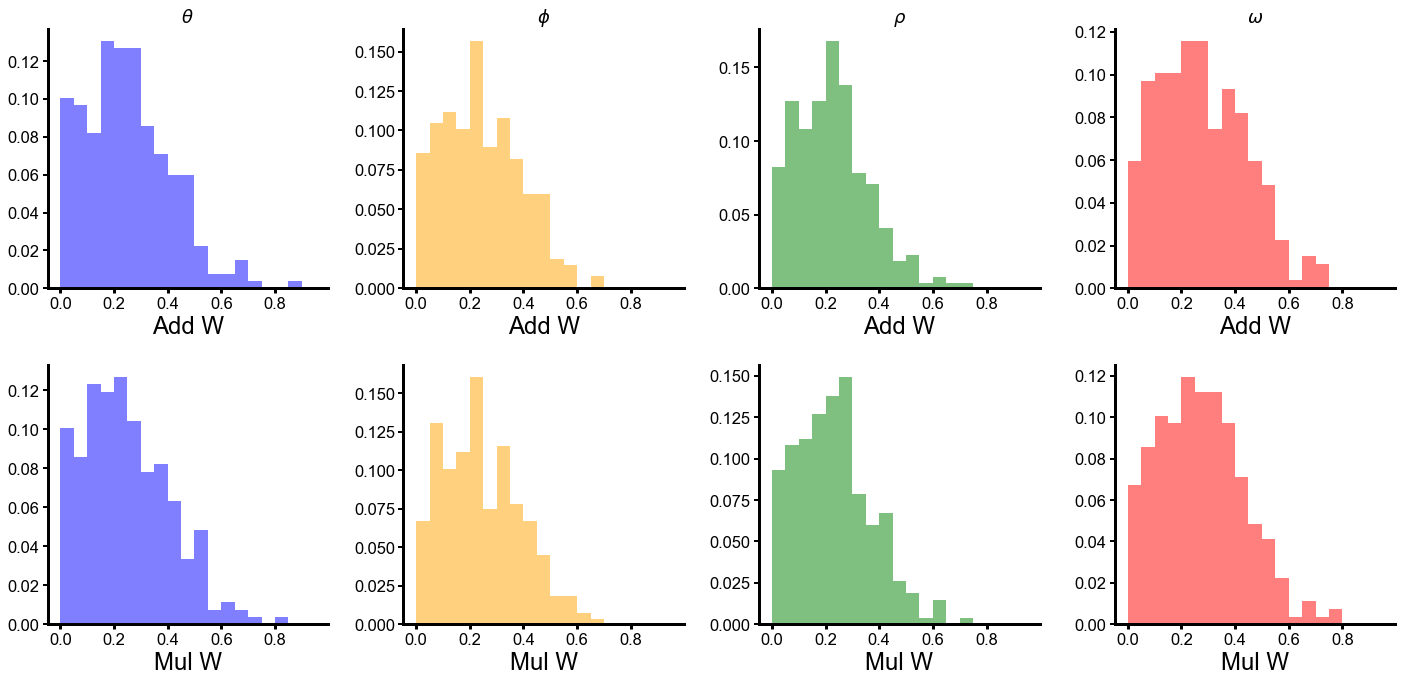

In [120]:
fig, axs = plt.subplots(2,4, figsize=(20,10))
move_clrs = ['blue','orange','green','red']
hbins = .05
lim0 = 0
lim1 = 1
dlim = .2
xlab = 'W'
for modeln in range(len(titles)):
    ax = axs[0,modeln]
    count,edges = np.histogram(vals_Add2[:,modeln],bins=np.arange(lim0,lim1,hbins))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(vals_Add2[:,modeln]),color=move_clrs[modeln],width=hbins, alpha=.5)
    ax.set_xticks(np.arange(lim0,lim1,dlim))
    ax.set_xticklabels(np.round(np.arange(lim0,lim1,dlim),decimals=1))
    ax.set_xlabel('Add W',fontsize=fontsize)
    ax.set_title(titles[modeln])

    ax = axs[1,modeln]
    count,edges = np.histogram(vals_Mul2[:,modeln],bins=np.arange(lim0,lim1,hbins))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(vals_Mul2[:,modeln]),color=move_clrs[modeln],width=hbins, alpha=.5)
    ax.set_xticks(np.arange(lim0,lim1,dlim))
    ax.set_xticklabels(np.round(np.arange(lim0,lim1,dlim),decimals=1))
    ax.set_xlabel('Mul W',fontsize=fontsize)
    # ax.axvline(x=np.nanmean(r2_all[n]), c=NoShift_clrs[n], ls='--')

plt.tight_layout()
fig.savefig(paper_fig_dir/'MoveW_propotions.png', facecolor='white', transparent=True, bbox_inches='tight')

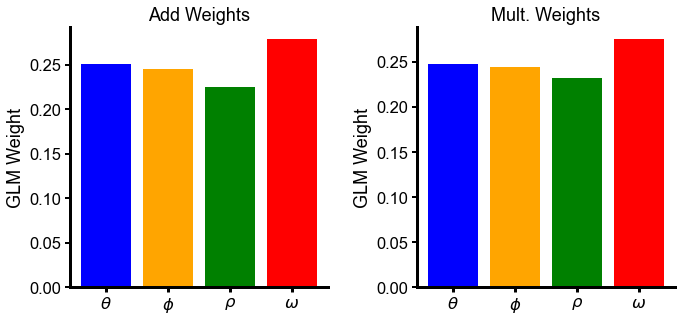

In [113]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
for modeln in range(len(titles)):
    axs[0].bar(modeln, np.nanmean(vals_Add2,axis=0)[modeln], color=move_clrs[modeln])
    axs[0].set_xticks(np.arange(0,len(titles)))
    axs[0].set_xticklabels(titles)
    axs[0].set_ylabel('GLM Weight')
    axs[0].set_title('Add Weights')

    axs[1].bar(modeln, np.nanmean(vals_Mul2,axis=0)[modeln], color=move_clrs[modeln])
    axs[1].set_xticks(np.arange(0,len(titles)))
    axs[1].set_xticklabels(titles)
    axs[1].set_ylabel('GLM Weight')
    axs[1].set_title('Mult. Weights')
plt.tight_layout()

### Single Cell Comparison

In [6]:
da = 0
args['date_ani'] = dates_all[da]
args['free_move'] = True
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
ncells=All_data[date_ani2[da]][mod_titles[0]+'_pred_smooth'].shape[-1]


Done Loading Unaligned data


In [ ]:
celln = 105
modN = 1
fontsize=24
anglim=65
titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$']
quartiles = np.arange(0,1.25,.25)
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
predcell = All_data[date_ani2[da]][mod_titles[1]+'_pred_smooth'][:,celln]#/params['model_dt']
nspcell = All_data[date_ani2[da]]['actual_smooth'][:,celln]#/params['model_dt']
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin)
fig = plt.figure(constrained_layout=False, figsize=(30,25))
gs0 = gridspec.GridSpec(nrows=3, ncols=4, figure=fig,wspace=.5,hspace=.3)

########## Plotting FM/HF RFs ##########
gs00a = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs0[:1,:4],wspace=.5,hspace=.5)
axs0a = np.array([fig.add_subplot(gs00a[0, n]) for n in range(gs00a.ncols)])
axs0b = np.array([fig.add_subplot(gs00a[1, n]) for n in range(gs00a.ncols)])

ax = axs0a[0]
crange = np.max(np.abs(All_data[date_ani2[da]]['Vis_rf_up'][celln]))
im = ax.imshow(All_data[date_ani2[da]]['Vis_rf_up'][celln,2],'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)
ax.axis('off')
ax.set_title('FM RF')

ax = axs0a[1]
ax.plot(All_data[date_ani2[da]]['actual_smooth'][:,celln])
ax.plot(All_data[date_ani2[da]]['Vis_pred_smooth'][:,celln])
ax.set_title('$r^2$: {:.03f}'.format(All_data[date_ani2[da]]['Vis_r2_test'][celln]))

ax = axs0a[2]
ax.plot(All_data[date_ani2[da]]['Vis_loss_regcv'][0,:,celln])
ax.set_ylabel('MSE')
ax.set_xlabel(r'$\lambda_n$')
ax.set_title('Best lam:{}'.format(np.nanargmin(All_data[date_ani2[da]]['Vis_loss_regcv'][0,:,celln])))

ax =axs0a[3]
for modN in range(len(mod_titles)-1):
    ax.plot(All_data[date_ani2[da]][mod_titles[modN]+'_vloss_all'][celln],c=mod_clrs[modN])
ax.set_ylabel('MSE')
ax.set_xlabel('batches')

########### Head Fixed plots ###########
ax = axs0b[0]
crange = np.max(np.abs(All_data[date_ani2[da]]['HF_rf_up'][celln]))
im = ax.imshow(All_data[date_ani2[da]]['HF_rf_up'][celln,2],'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)
ax.set_title('HF RF')
ax.axis('off')

ax = axs0b[1]
ax.plot(All_data[date_ani2[da]]['actual_HF_smooth'][:,celln])
ax.plot(All_data[date_ani2[da]]['HF_pred_smooth'][:,celln])
ax.set_title('$r^2$: {:.03f}'.format(All_data[date_ani2[da]]['HF_r2_test'][celln]))

ax = axs0b[2]
ax.plot(All_data[date_ani2[da]]['HF_loss_regcv'][0,:,celln])
ax.set_ylabel('MSE')
ax.set_xlabel(r'$\lambda_n$')
ax.set_title('Best lam:{}'.format(np.nanargmin(All_data[date_ani2[da]]['HF_loss_regcv'][0,:,celln])))

ax =axs0b[3]
ax.plot(All_data[date_ani2[da]][mod_titles[-1]+'_vloss_all'][celln],c='k')
ax.set_ylabel('MSE')
ax.set_xlabel('batches')

######### Position Weights ##########

w_move_Add = All_data[date_ani2[da]][mod_titles[2]+'_moveW']
w_move_Mov = All_data[date_ani2[da]][mod_titles[3]+'_moveW']
for modeln in range(len(titles)):
    axs0a[4].bar(modeln, w_move_Add[celln,modeln], color=move_clrs[modeln])
    axs0a[4].set_xticks(np.arange(0,len(titles)))
    axs0a[4].set_xticklabels(titles)
    axs0a[4].set_ylabel('GLM Weight')
    axs0a[4].set_title('Add Weights')

    axs0b[4].bar(modeln, w_move_Mov[celln,modeln], color=move_clrs[modeln])
    axs0b[4].set_xticks(np.arange(0,len(titles)))
    axs0b[4].set_xticklabels(titles)
    axs0b[4].set_ylabel('GLM Weight')
    axs0b[4].set_title('Mul Weights')



########## Fig 4A ########## 
gs00 = gridspec.GridSpecFromSubplotSpec(2, len(titles), subplot_spec=gs0[1,:4],wspace=.5,hspace=.7)
axs1 = np.array([fig.add_subplot(gs00[n,m]) for n in range(1) for m in range(len(titles))]).reshape(1,len(titles))
axs1b = np.array([fig.add_subplot(gs00[n,m]) for n in range(1,2) for m in range(len(titles))]).reshape(1,len(titles))

top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
traces_mean = np.zeros((ncells,len(titles),stat_bins-1))
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1))
for i,modeln in enumerate(range(len(titles))):
    metric = move_data[params['bin_length']:-params['bin_length'],modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,nsp_raw[params['bin_length']:-params['bin_length'],celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#
    for m in range(len(nranges)-1):
        axs1[0,modeln].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=q_clrs[m],zorder=0)
    axs1[0,modeln].plot(edge_mids,stat_range/params['model_dt'],'.-', ms=20, lw=4,c=move_clrs[modeln])
    axs1[0,modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
    xlim_range = np.max(np.abs([nranges[0],nranges[-1]]))
    axs1[0,modeln].set_xlim(-xlim_range,xlim_range)
    axs1[0,modeln].set_xlabel('angle (deg)',fontsize=fontsize)
    axs1[0,modeln].set_ylabel('sp/sec',fontsize=fontsize)
    axs1[0,modeln].set_title(titles[modeln],fontsize=fontsize)

    
    stat_all, edges, _ = binned_statistic(predcell,nspcell,statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts 
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]
        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        axs1b[0,modeln].plot(edge_mids, stat_range,'.-', c=q_clrs[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
        axs1b[0,modeln].set_xlabel('predicted (sp/sec)',fontsize=fontsize)
        axs1b[0,modeln].set_ylabel('actual (sp/sec)',fontsize=fontsize)
        axs1b[0,modeln].axis('square')
    
    lim_max = np.nanmax(np.hstack((edge_mids,traces[celln,modeln].flatten())))+.5*np.std(edges)
    lim_min = np.nanmin(np.hstack((edge_mids,traces[celln,modeln].flatten())))-.5*np.std(edges)
    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
    axs1b[0,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    axs1b[0,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    # axs1b[0,modeln].axis('equal')
    axs1b[0,modeln].set(xlim=lims, ylim=lims)
    # axs1b[0,modeln].set_ylim(bottom=0)



########## Fig 4B ########## 
gs01 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[2,:4],wspace=.05,hspace=.5)
axs2 = np.array([fig.add_subplot(gs01[n,m]) for n in range(1) for m in range(1)]).reshape(1,1)
axs2b = np.array([fig.add_subplot(gs01[n,m]) for n in range(1,2) for m in range(1)]).reshape(1,1)

cmap = mpl.colors.ListedColormap(q_clrs)
##### Plotting Position Scatter #####
t0=300
t = np.argmin(np.abs((np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])-t0)) # 200 seconds in #6000
dt = int(150/params['model_dt']) # All_data[date_ani2[da]]['actual_smooth'].shape[0] # dt in seconds converted to time points
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs2[0,0]
metric = move_data[params['bin_length']:-params['bin_length'],3]
ax.scatter(pred_time, metric[t:t+dt],s=10,c=np.digitize(metric,nranges)[t:t+dt],cmap=cmap)
ax.set_ylabel(r'$\omega$ (deg)',fontsize=fontsize)
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylim([-anglim,anglim])

# celln = 18#106
# da = 0
# t = 6000 #np.argmin(np.abs(pred_time-375)) # T seconds in 
# dt = 3000 #All_data[date_ani2[da]]['actual_smooth'].shape[0]
##### Plotting Firing Rate #####
pred_time = (np.arange(All_data[date_ani2[da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs2b[0,0]
zorder = np.argsort([All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln] for modN in range(len(mod_titles))])+1
ax.plot(pred_time,All_data[date_ani2[da]]['actual_smooth'][t:t+dt,celln],c='k',lw=3)
for modN in range(len(mod_titles)-1):
    ax.plot(pred_time,All_data[date_ani2[da]][mod_titles[modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=3,
            label='{} $r^2$: {:.02f}'.format(mod_titles[modN],All_data[date_ani2[da]][mod_titles[modN]+'_r2_test'][celln]),zorder=zorder[n])
ax.legend(labelcolor='linecolor', fontsize=14, handlelength=0, handletextpad=0,loc='upper right', bbox_to_anchor=(1.05, 1))
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)

Mot_r2 = All_data[date_ani2[da]]['Mot_r2_test'][celln]
Vis_r2 = All_data[date_ani2[da]]['Vis_r2_test'][celln]
Add_r2 = All_data[date_ani2[da]]['Add_r2_test'][celln]
Mul_r2 = All_data[date_ani2[da]]['Mul_r2_test'][celln]
FMHF_r2 = All_data[date_ani2[da]]['HF_FMHF_r2'][celln]
plt.suptitle('{} celln: {} ({}) \n Mot $r^2$:{:.03f}, Vis $r^2$:{:.03f}, Add $r^2$:{:.03f}, Mult $r^2$:{:.03f} \n FM_HF_CC: {:.02f}'.format(date_ani2[da],celln,celln,Mot_r2,Vis_r2,Add_r2,Mul_r2,FMHF_r2))
plt.show()

### Simulated RF

In [100]:
def myimshow(I, **kwargs):
    # utility function to show image
    plt.figure();
    plt.axis('off')
    plt.imshow(I, cmap='RdBu_r',vmin=-1,vmax=1, **kwargs)

In [196]:
def gabor(sz, offset, sigma=4, theta=0, Lambda=4*np.pi, psi=np.pi, gamma=1.25, nstds=3):
    """Gabor feature extraction."""
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # # Bounding box
    # xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    # xmax = np.ceil(max(1, xmax))
    # ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    # ymax = np.ceil(max(1, ymax))
    # xmin = -xmax
    # ymin = -ymax
    radius = (int(sz[0]/2.0), int(sz[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1))

    # Rotation
    x_theta =  (x-offset[0]) * np.cos(theta) + (y-offset[1]) * np.sin(theta)
    y_theta = -(x-offset[0]) * np.sin(theta) + (y-offset[1]) * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb


In [859]:

args['date_ani'] = '121521/SimRF' #
args['SimRF'] = True
params,_,_ = load_params(1,Kfold,args,file_dict={},debug=True)
params['nt_glm_lag'] = 1
data, train_idx_list, test_idx_list = load_train_test({}, **params)

##### Set Train Test Splits #####
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data, train_idx, test_idx, params)
locals().update(data)

params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, model_type, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}'.format(params['MovModel'], params['LinMix'], params['move_features'], params['Ncells'], params['train_shifter']))
yte2 = yte.cpu().detach().numpy()

Done Loading Unaligned data
Model: 1, LinMix: False, move_features: None, Ncells: 64, train_shifter: False


In [ ]:
fig, axs = plt.subplots(16,4, figsize=(10,20))
axs = axs.flatten()
for n,ax in enumerate(axs):
    ax.axis('off')
    crange = np.max(np.abs(FilterBank[n]))
    im = ax.imshow(FilterBank[n], cmap='RdBu_r',vmin=-crange,vmax=crange)
    add_colorbar(im)

In [857]:
theta = np.arange(0, np.pi, np.pi/4) # range of theta
offsetx = np.arange(-8,8,4)
offsety = np.arange(-8,8,4)
FilterBank = []
gaborParams = []
for ox in offsetx:
    for oy in offsety:
        for th in theta:
            gaborParam = {'offset':(ox,oy), 'theta':th, 'sz':(40, 30)}
            g = gabor(**gaborParam)[:-1,:-1]
            FilterBank.append(g)
            gaborParams.append(gaborParam)
FilterBank=np.stack(FilterBank)


output_size = 64
input_size = 1200
bias_sim = np.random.rand(64)
scale_w = np.random.randint(8,10,64)[:,np.newaxis] # 5,6 10 Hz average did great
FilterBank = FilterBank/scale_w[:,:,np.newaxis]
FilterBank_flt = FilterBank.reshape(output_size,-1)/scale_w
l1 = LinVisNetwork(input_size,output_size)
l1.Cell_NN[0].weight.data = torch.from_numpy((FilterBank_flt).astype(np.float32))
l1.Cell_NN[0].bias.data = torch.from_numpy(bias_sim.astype(np.float32))

In [860]:
lag_list = [0]
# model_vid = rolled_vid.reshape(data['model_vid_sm'].shape[0],-1)
Ncells = out.shape[-1]
model_vid = xtr.cpu().detach().numpy()
sta = (model_vid.T @ out)/np.sum(out,0,keepdims=True)
sta_im = sta.T.reshape((Ncells,len(lag_list)) + data['model_vid_sm'].shape[1:])

In [861]:
out = l1(xtr.cpu())
pred = l1(xte.cpu())
out = np.random.poisson(out.cpu().detach().numpy())
pred = np.random.poisson(pred.cpu().detach().numpy())

Kfold=0
SimRF_file = params['save_dir'].parent.parent.parent/'121521/SimRF/fm1/SimRF_{}_dt{:03d}_T{:02d}_Model1_NB{}_Kfold{:02d}_best.h5'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
# ioh5.save(SimRF_file,{'ytr':out,'yte':pred,'RF_actual':FilterBank,'bias_sim':bias_sim,'sta':sta})

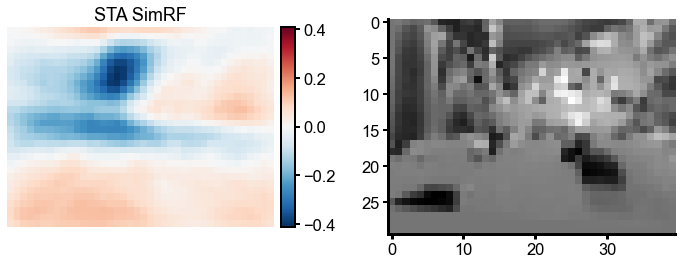

In [869]:
cell = 17
fig, axs = plt.subplots(1,2,figsize=(10,5))
ax = axs[0]
crange2 = np.max(np.abs(sta_im[cell]))
im2 = ax.imshow(sta_im[cell,0],'RdBu_r', vmin=-crange2, vmax=crange2)
ax.set_title('STA SimRF')
ax.axis('off')
cbar = add_colorbar(im2)

ax = axs[1]
plt.imshow(model_vid.reshape((xtr.shape[0],)+data['model_vid_sm'].shape[1:])[500])
plt.tight_layout()

In [ ]:
np.logspace(-2,3,20)[10:],np.logspace(-4,3,20)[0:8]

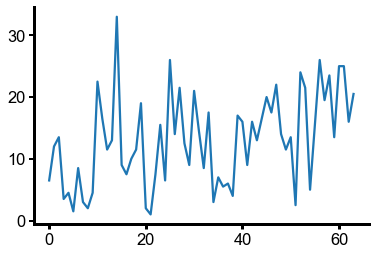

In [848]:
# Sim_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
Sim_act_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=pred)[params['bin_length']:-params['bin_length']].T
plt.plot(Sim_act_smooth[:,24])

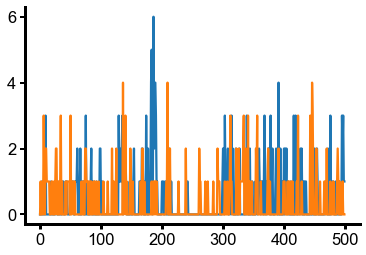

In [842]:
plt.plot(pred[:500,49])
plt.plot(yte[:500,12].cpu().detach().numpy())

In [747]:
track_all=True
GLM_CV = {}
GLM_CV['loss_regcv']      = np.zeros((params['nalph'], params['nlam'], output_size), dtype=np.float32)
GLM_CV['pred_cv']         = np.zeros((params['nalph'], params['nlam'], output_size, xte.shape[0]), dtype=np.float32)
GLM_CV['out_cv']          = np.zeros((params['nalph'], params['nlam'], output_size, xtr.shape[0]), dtype=np.float32)
GLM_CV['tloss_trace_all'] = np.zeros((params['nalph'], params['nlam'], output_size, params['Nepochs']), dtype=np.float32)
GLM_CV['vloss_trace_all'] = np.zeros((params['nalph'], params['nlam'], output_size, params['Nepochs']), dtype=np.float32)
GLM_CV['r2_test']         = np.zeros((params['nalph'], params['nlam'], output_size), dtype=np.float32)

# for a, reg_alph in enumerate(params['alphas']):
#     if params['MovModel'] == 1:
#         pbar = tqdm(range(len(params['lambdas'])))
#     elif (params['MovModel'] != 1):
#         pbar = tqdm(range(len(params['lambdas_m'])))
    
#     for reg_lam, l in enumerate(pbar):
a = 0
l = 13
VisNepochs=10000
l1,optimizer,scheduler = get_model(input_size, output_size, meanbias, params['MovModel'], device, l, a, params,NepochVis=VisNepochs)
# if (a==0) & (l==0):
for name, p in l1.named_parameters():
    GLM_CV[name] = np.zeros((params['nalph'],params['nlam'],) + p.shape, dtype=np.float32)
# elif (l!=0) & (params['MovModel']==1) & (params['train_shifter']==False):
#     l1.load_state_dict(state_dict)

vloss_trace, tloss_trace, l1, optimizer, scheduler, Epoch_GLM = train_model(xtr,xte,xtrm,xtem,shift_in_tr,shift_in_te,ytr,yte,params['Nepochs'],l1,optimizer,scheduler,pbar=None,track_all=track_all)
model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{}.pth'.format(model_type, params['WC_type'], int(params['model_dt']*1000), params['nt_glm_lag'], params['MovModel'], params['Nepochs'], a, l, Kfold)

for name, p in l1.named_parameters():
    GLM_CV[name][a,l] = p.clone().cpu().detach().numpy()

# if (l == 0) & (params['MovModel']==1):
#     state_dict = l1.state_dict()

GLM_CV['tloss_trace_all'][a, l] = tloss_trace.T
GLM_CV['vloss_trace_all'][a, l] = vloss_trace.T

pred = l1(xte, xtem, shift_in_te)
GLM_CV['loss_regcv'][a, l] = l1.loss(pred, yte).cpu().detach().numpy()
GLM_CV['pred_cv'][a, l] = pred.detach().cpu().numpy().squeeze().T
out = l1(xtr, xtrm, shift_in_tr)
GLM_CV['out_cv'][a, l] = out.detach().cpu().numpy().squeeze().T

sp_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=data['test_nsp'])[params['bin_length']:-params['bin_length']]
pred_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_CV['pred_cv'][a, l])[:,params['bin_length']:-params['bin_length']].T
GLM_CV['r2_test'][a,l] = np.array([(np.corrcoef(sp_smooth[:,celln],pred_smooth[:,celln])[0, 1])**2 for celln in range(params['Ncells'])])

if params['train_shifter']:
    torch.save({'reg_alph': reg_alph, 'reg_lam':l, 'model_state_dict': l1.state_dict(),'optimizer_state_dict': optimizer.state_dict(),}, (params['save_model_shift'] / model_name))
        
if (params['MovModel'] ==1):
    GLM_CV['loss_regcv'][:, 0, :] = np.nan

malph, mlam, cellnum = np.where(GLM_CV['loss_regcv'] == np.nanmin(GLM_CV['loss_regcv'], axis=(0, 1), keepdims=True))
cellnum, m_cinds = np.unique(cellnum, return_index=True)
malph = malph[m_cinds]
mlam = mlam[m_cinds]
sortinds = cellnum.argsort()
cellnum = cellnum[sortinds]
malph = malph[sortinds]
mlam = mlam[sortinds]

GLM_Data = {}
for key in GLM_CV.keys():
    if 'shifter' in key:
        GLM_Data[key] = GLM_CV[key][malph,mlam]    
    else:
        GLM_Data[key] = GLM_CV[key][malph,mlam,cellnum]
GLM_Data['loss_regcv']=GLM_CV['loss_regcv']
# if params['do_shuffle']:
#     save_datafile_all = params['save_model']/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}_shuffled_all.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], params['MovModel'], params['Nepochs'],Kfold)
#     save_datafile_best = params['save_model']/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}_shuffled_best.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], params['MovModel'], params['Nepochs'],Kfold)
# else:
#     save_datafile_all = params['save_model']/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}_all.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], params['MovModel'], params['Nepochs'],Kfold)
#     save_datafile_best = params['save_model']/'GLM_{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}_best.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], params['MovModel'], params['Nepochs'],Kfold)
# ioh5.save(save_datafile_all, GLM_CV)
# ioh5.save(save_datafile_best, GLM_Data)
# print(save_datafile_all)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

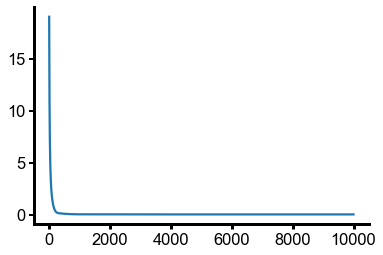

In [721]:
plt.plot(np.linalg.norm(Epoch_GLM['Cell_NN.0.weight'],axis=(1,2)))
# plt.plot(np.linalg.norm(Epoch_GLM['Cell_NN.0.bias'],axis=1))
# plt.plot(np.linalg.norm(Epoch_GLM['shifter_nn.0.weight'],axis=(1,2)))
# plt.plot(np.linalg.norm(Epoch_GLM['shifter_nn.0.bias'],axis=(1)))
# plt.plot(np.linalg.norm(Epoch_GLM['shifter_nn.2.weight'],axis=(1,2)))
# plt.plot(np.linalg.norm(Epoch_GLM['shifter_nn.2.bias'],axis=(1)))

In [824]:
args['free_move'] = True
args['date_ani'] = '121521/SimRF'
args['NoL1']=False
args['Nepochs'] = 10000
params,_,_ = load_params(1,Kfold,args,file_dict={},debug=True)
params['nt_glm_lag']=1
date_ani_dir = params['save_dir'].parent.parent.parent/args['date_ani']
if args['NoL1'] == True: 
    L1 = 'NoL1'
    mod_name = '*{}_SimRF_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
else: 
    L1 = 'withL1'
    mod_name = '*{}_SimRF_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(L1,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
ModelList = np.array(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if ('VisNoShifter' not in path.stem)]))
SimRF_file = params['save_dir'].parent.parent.parent/'121521/SimRF/fm1/SimRF_{}_dt{:03d}_T{:02d}_Model1_NB{}_Kfold{:02d}_best.h5'.format('withL1',int(params['model_dt']*1000), 1, params['Nepochs'],Kfold)
ModelList

array([PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data/121521/SimRF/fm1/GLM_Network/MovModel1/version_0/SimRF/GLM_Pytorch_Vis_withL1_SimRF_dt050_T01_MovModel1_NB10000_Kfold00_best.h5')],
      dtype=object)

In [830]:
GLM_Data = ioh5.load(ModelList[0])
SimRF_data = ioh5.load(SimRF_file)
RF_Sim = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0], params['nt_glm_lag'],)+(30,40))
Sim_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
Sim_act_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=SimRF_data['yte'].copy())[params['bin_length']:-params['bin_length']].T
Sim_r2 = np.array([(np.corrcoef(Sim_smooth[:,celln],Sim_act_smooth[celln])[0, 1])**2 for celln in range(Sim_act_smooth.shape[0])])


In [888]:
np.argmax(Sim_r2),np.argmin(Sim_r2)

(62,
 56,
 PosixPath('/home/seuss/Research/SensoryMotorPred_Data/Figures/Encoding/PaperFigs'))

In [827]:
save_pdf = True
hbins = .05
pdf_name = paper_fig_dir/ ('SimulatedRF_CellSummary.pdf')
totcelln = 0
if save_pdf:
    pdf = PdfPages(pdf_name)
    fig, ax0 = plt.subplots(1,1,figsize=(7,7))
    ax = ax0
    count,edges = np.histogram(Sim_r2,bins=np.arange(0,1,hbins))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax.bar(edges_mid, count/len(Sim_r2),color='k',width=hbins, alpha=1)
    ax.set_xticks(np.arange(0,1.2,.2))
    ax.set_xticklabels(np.round(np.arange(0,1.2,.2),decimals=1))
    ax.set_title('Simulated R2')
    ax.set_xlabel(r'$r^2$')
    plt.tight_layout()
    pdf.savefig()
    plt.close()

pbar = tqdm(range(Sim_r2.shape[0]))
# pbar = [0,1,2,3]
for cell in pbar:
    fig1 = plt.figure(constrained_layout=False, figsize=(15,10))
    gs0 = gridspec.GridSpec(ncols=4, nrows=2, figure=fig1,wspace=.2,hspace=.3)

    gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0,:],wspace=.3,hspace=.05)
    axs1 = np.array([fig1.add_subplot(gs00[n,m]) for n in range(1) for m in range(3)]).reshape(1,3)
    da = 0
    ax = axs1[0,0]
    crange2 = np.max(np.abs(RF_Sim[cell]))
    im2 = ax.imshow(RF_Sim[cell,0],'RdBu_r', vmin=-crange2, vmax=crange2)
    ax.set_title('Fit SimRF')
    ax.axis('off')
    cbar = add_colorbar(im2)

    ax = axs1[0, 1]
    crange2 = np.max(np.abs(SimRF_data['RF_actual'][cell]))
    im2 = ax.imshow(SimRF_data['RF_actual'][cell],'RdBu_r', vmin=-crange2, vmax=crange2)
    ax.set_title('Actual SimRF')
    ax.axis('off')
    cbar = add_colorbar(im2)

    ax = axs1[0, 2]
    diff = SimRF_data['RF_actual'][cell] - RF_Sim[cell, 0]
    crange2 = np.max(np.abs(diff))
    im2 = ax.imshow(diff, 'RdBu_r', vmin=-crange2, vmax=crange2)
    ax.set_title('Difference')
    ax.axis('off')
    cbar = add_colorbar(im2)

    ##### Predictions #####
    gs02 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1,:-1],wspace=.2,hspace=.05)
    axs2 = fig1.add_subplot(gs02[0])
    ax = axs2
    ax.plot(Sim_act_smooth[cell],label='Sim Actual')
    ax.plot(Sim_smooth[:,cell],label='Pred')
    ax.legend()
    ax.set_title('r2:{:.02f}'.format(Sim_r2[cell]))
    plt.suptitle('celln: {}'.format(cell))

    # plt.tight_layout()
    if save_pdf:
        pdf.savefig()
        plt.close()
if save_pdf:
    pdf.close()

# fig1.savefig(paper_fig_dir/'Simulated_RF_Cell{}.png'.format(cell), facecolor='white', transparent=True, bbox_inches='tight')


  0%|          | 0/64 [00:00<?, ?it/s]

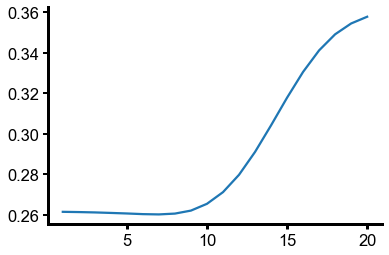

In [829]:
plt.plot(GLM_Data['loss_regcv'][0,:,15])

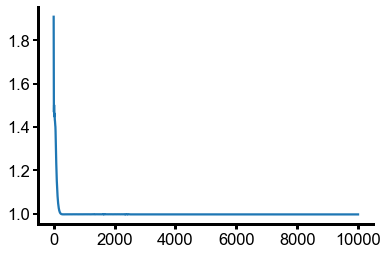

In [585]:
plt.plot(GLM_Data['vloss_trace_all'][4].T)
plt.show()

### Tuning Histograms

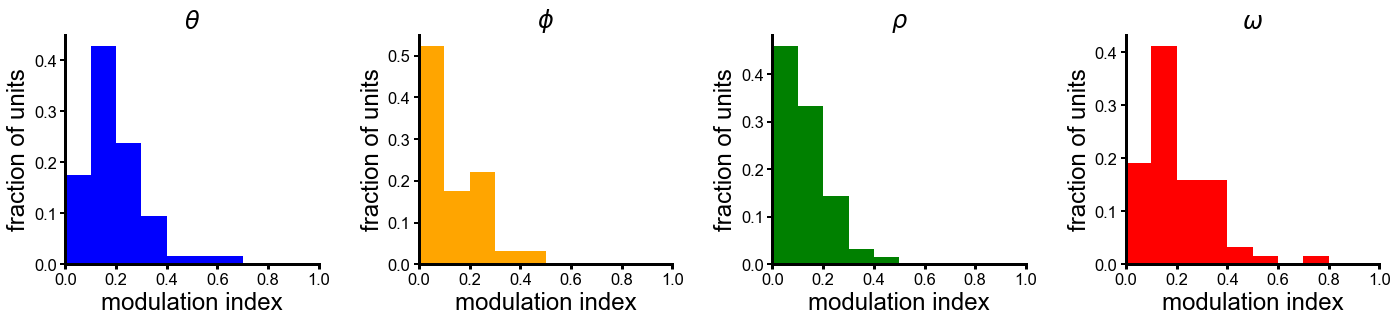

In [33]:
clrs = ['blue','orange','green','red']
titles = np.array(['theta', 'phi', 'rho', 'omega'])
fontsize=24
fig, ax = plt.subplots(1,4,figsize=(20,5))
ax = ax.flatten()
dwidth = .1
for modeln in np.arange(len(titles)):
    count,edges = np.histogram(tuning_sig[:,modeln], bins=np.arange(0,1.1,dwidth))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax[modeln].bar(edges_mid, count/len(tuning_sig[:,modeln]),color=clrs[modeln],width=dwidth)
    ax[modeln].set_title(r'$\{}$'.format(titles[modeln].lower()), fontsize=fontsize)
    ax[modeln].set_xlabel('modulation index', fontsize=fontsize)
    ax[modeln].set_ylabel('fraction of units', fontsize=fontsize)
    ax[modeln].set_xlim(0,1)
#     ax[modeln].set_ylim(0,.2)
plt.tight_layout()
# fig.savefig(fig_dir/'Modulation_hist.pdf',facecolor='white', transparent=True, bbox_inches='tight')

In [ ]:
celln = 126
fontsize = 24
fig, axs = plt.subplots(1,4, figsize=(25,5))
# Tuning Curves
for i,modeln in enumerate(range(len(titles))):
    metric = move_data[:,modeln]
    axs[modeln].plot(edge_mids,tuning_curves[celln,modeln],'.-', ms=25, lw=7,c=clrs[modeln])
    axs[modeln].set_xlim(-30,30)
    axs[modeln].set_xlabel('angle (deg)',fontsize=fontsize)
    axs[modeln].set_ylabel('sp/sec',fontsize=fontsize)
    axs[modeln].set_title(r'$\{}$'.format(titles[modeln]),fontsize=fontsize)
    axs[modeln].set_ylim(bottom=0,top=np.nanmax(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
plt.tight_layout()
fig.savefig(fig_dir/'Turning_Curve_cell{}.pdf'.format(celln),facecolor='white', transparent=True, bbox_inches='tight')

### Raster Plots

In [10]:

ephys_file = params['save_dir']/'RawEphysData.h5'
ephys_data = pd.read_hdf(ephys_file)
spikeT = ephys_data['spikeT']
Tmin = 0
Tmax = 5
cell_spikes = []
for celln,spks in spikeT.iteritems():
    cell_spikes.append(spks[(spks>Tmin) &(spks < Tmax)])


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/tables/__init__.py:99: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from .utilsextension import (
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/tables/__init__.py:99: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from .utilsextension import (
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/tables/array.py:241: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (oid, self.atom, self.shape, self._v_chunkshape) = self._open_array()
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/tables/array.py:241: DeprecationWarning: `np.object` is a deprecated alias for the bui

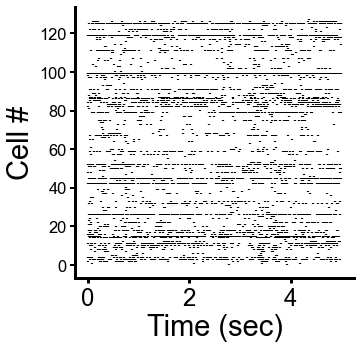

In [12]:
fontsize=24
fig,axs = plt.subplots(figsize=(5,5))
ax = axs
ax.eventplot(cell_spikes,color='k',linelengths=.5)
ax.set_xlabel('Time (sec)',fontsize=fontsize+5)
ax.set_ylabel('Cell #',fontsize=fontsize+5)
# ax.set_yticks(np.arange(0,params['Ncells'],2))
# ax.set_yticklabels(np.arange(0, params['Ncells'], 2),fontsize=fontsize)
ax.set_xticks(np.arange(0, 6, 2))
ax.set_xticklabels(np.arange(0, 6, 2), fontsize=fontsize)

plt.show()
# fig.savefig(fig_dir/'SpikeRaster.pdf', facecolor='white', transparent=True, bbox_inches='tight')


### WorldCam/EyeCam/IMU Example

In [ ]:
celln = 12
bin_length=40
titles = np.array(['theta', 'phi', 'rho', 'omega'])
clrs = ['blue', 'orange', 'green', 'red']
fontsize=24
fig, axs = plt.subplots(4,1,figsize=(10,5),sharex=True)
for modeln,ax in enumerate(axs):
    sp_smooth = ((np.convolve(GLM_Vis['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    smooth_move = np.zeros((len(titles), sp_smooth.shape[0]))
    smooth1 = ((np.convolve(move_test[:,modeln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    smooth_move[modeln] = (smooth1 - np.nanmean(smooth1))/np.max(smooth1)
    ax.plot(np.arange(smooth_move[modeln].shape[0])*params['model_dt'], smooth_move[modeln],c=clrs[modeln], label=r'$\{}$'.format(titles[modeln]),alpha=.75)
    ax.set_yticks([])
axs[-1].tick_params(axis='x', labelsize=fontsize)
axs[-1].set_xlabel('Time (sec)',fontsize=fontsize)
fig.savefig(fig_dir/'IMU_Example.pdf', facecolor='white', transparent=True, bbox_inches='tight')


In [ ]:
WC_raw = np.load('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/uncorrected_worldcam_dt050.npy')

In [ ]:
WC_raw.shape,data['model_vid_sm'].shape

In [ ]:
fig,axs = plt.subplots(1,figsize=(2,2))
# axs.imshow(WC_raw[1000], cmap='gray')
axs.imshow(model_vid_sm_shift[2000], cmap='gray')
axs.axis('off')
fig.savefig(fig_dir/'WC_DSIm.pdf', facecolor='white', transparent=True, bbox_inches='tight')

# axs[1].imshow(model_vid_sm_shift[1000])

### Position Only

In [ ]:
celln = 101
bin_length=40
Nepochs = 5000
fontsize = 24
for Kfold in range(3):
    move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    GLM_Mot = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, Nepochs, Kfold))
    GLM_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000, Kfold))
    GLM_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs, Kfold))
    GLM_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, Nepochs, Kfold))

    fig,ax = plt.subplots(figsize=(20,5))
    sp_smooth = ((np.convolve(GLM_Vis['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

    pred_smooth_Mot = ((np.convolve(GLM_Mot['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_Vis = ((np.convolve(GLM_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

    pred_smooth_Add = ((np.convolve(GLM_Add['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_Mul = ((np.convolve(GLM_Mul['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

    ax.plot(np.arange(len(sp_smooth))*params['model_dt'],sp_smooth, 'k', lw=2,label='Actual')
    ax.plot(np.arange(len(pred_smooth_Mot))*params['model_dt'],pred_smooth_Mot,'r', lw=2,label='Mot')
    ax.plot(np.arange(len(pred_smooth_Vis))*params['model_dt'],pred_smooth_Vis,'b', lw=2,label='Vis')
    ax.plot(np.arange(len(pred_smooth_Add))*params['model_dt'],pred_smooth_Add,'m', lw=2,label='Add')
    ax.plot(np.arange(len(pred_smooth_Mul))*params['model_dt'],pred_smooth_Mul,'g', lw=2,label='Mul')
    ax.legend(labelcolor='linecolor', fontsize=18, handlelength=0, handletextpad=0, fancybox=True)
    ax.set_xlabel('Time (s)',fontsize=fontsize)
    ax.set_ylabel('Spike Rate',fontsize=fontsize)
    r2_Mot = np.corrcoef(sp_smooth,pred_smooth_Mot)[0,1]**2
    r2_Vis = np.corrcoef(sp_smooth,pred_smooth_Vis)[0,1]**2
    r2_Add = np.corrcoef(sp_smooth,pred_smooth_Add)[0,1]**2
    r2_Mul = np.corrcoef(sp_smooth,pred_smooth_Mul)[0,1]**2
    ax.set_title('Kfold:{:02d}, Mot:{:.03}, Vis:{:.03}, Add:{:.03}, Mul:{:.03}'.format(Kfold, r2_Mot,r2_Vis,r2_Add,r2_Mul))
    fig.savefig(fig_dir/'ExamplePredFR_celln{}_Kfold{:02d}.png'.format(celln,Kfold), facecolor='white', transparent=True, bbox_inches='tight')


In [ ]:
Kfold = 2
Nepochs=5000
bin_length = 40
move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
GLM_Mot = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mot',int(params['model_dt']*1000), params['nt_glm_lag'], 0, 5000, Kfold))
GLM_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000, Kfold))
GLM_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Add',int(params['model_dt']*1000), params['nt_glm_lag'], 2, 5000, Kfold))
GLM_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Mul',int(params['model_dt']*1000), params['nt_glm_lag'], 2, 5000, Kfold))


In [ ]:

celln = 101
t = 1200
dt = 2000
fontsize=24
fig,ax = plt.subplots(figsize=(15,5))
sp_smooth = ((np.convolve(GLM_Vis['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

pred_smooth_Mot = ((np.convolve(GLM_Mot['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth_Vis = ((np.convolve(GLM_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth_Add = ((np.convolve(GLM_Add['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth_Mul = ((np.convolve(GLM_Mul['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]

r2_Mot = np.corrcoef(sp_smooth,pred_smooth_Mot)[0,1]**2
r2_Vis = np.corrcoef(sp_smooth,pred_smooth_Vis)[0,1]**2
r2_Add = np.corrcoef(sp_smooth,pred_smooth_Add)[0,1]**2
r2_Mul = np.corrcoef(sp_smooth,pred_smooth_Mul)[0,1]**2

ax.plot(np.arange(len(sp_smooth[t:t+dt]))*params['model_dt'],sp_smooth[t:t+dt], 'k', lw=5,label='Actual', zorder=0)
ax.plot(np.arange(len(pred_smooth_Mot[t:t+dt]))*params['model_dt'],pred_smooth_Mot[t:t+dt],'r', lw=5,label='Pos: $r^2$={:.02f}'.format(r2_Mot), zorder=4)
ax.plot(np.arange(len(pred_smooth_Vis[t:t+dt]))*params['model_dt'],pred_smooth_Vis[t:t+dt],'b', lw=5,label='Vis: $r^2$={:.02f}'.format(r2_Vis), zorder=3)
ax.plot(np.arange(len(pred_smooth_Add[t:t+dt]))*params['model_dt'],pred_smooth_Add[t:t+dt],'m', lw=5,label='Add: $r^2$={:.02f}'.format(r2_Add), zorder=2)
ax.plot(np.arange(len(pred_smooth_Mul[t:t+dt]))*params['model_dt'],pred_smooth_Mul[t:t+dt],'g', lw=5,label='Mul: $r^2$={:.02f}'.format(r2_Mul), zorder=1)
ax.legend(labelcolor='linecolor', fontsize=18, handlelength=0, handletextpad=0, fancybox=True, bbox_to_anchor=(1.01, 1))
ax.set_xlabel('Time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)

fig.savefig(fig_dir/'Mul_ExamplePredFR_celln{}_Kfold{:02d}.pdf'.format(celln,Kfold), facecolor='white', transparent=True, bbox_inches='tight')